# [Collision Avoidance Challenge](https://kelvins.esa.int/collision-avoidance-challenge/home/)
## Introduction
Today, active **collision avoidance** among orbiting satellites has become a routine task in space operations, relying on validated, accurate and timely space surveillance data. For a typical satellite in Low Earth Orbit, hundreds of alerts are issued every week corresponding to possible close encounters between a satellite and another space object (in the form of conjunction data messages CDMs). After automatic processing and filtering, there remain about 2 actionable alerts per spacecraft and week, requiring detailed follow-up by an analyst. On average, at the European Space Agency, more than one collision avoidance manoeuvre is performed per satellite and year.


In this challenge, you are tasked to build a model to predict the final collision risk estimate between a given satellite and a space object (e.g. another satellite, space debris, etc). To do so, you will have access to a database of real-world conjunction data messages (CDMs) carefully prepared at ESA. Learn more about the challenge and the data.

This competition is organized by ESA's Advanced Concepts Team (ACT) in partnership with ESA's Space Debris Office

Experts from both teams are available for interactions during the competition.

## Challenge

As of estimations done in January 2019, more than 34,000 objects with a size larger than 10cm are orbiting our planet. Of these, 22,300 are tracked by the Space Surveillance Network and their position released in the form of a globally shared catalogue.


ESA's Space Debris Office supports collision avoidance activities covering the ESA missions Aeolus, Cryosat-2 and the constellation of Swarm-A/B/C in low-Earth orbit and Cluster-II in highly eccentric orbit approaching the Geostationary (GEO) region. On top of these, more than a dozen spacecraft of partner agencies and commercial operators are supported.

![Alt text](https://kelvins.esa.int/media/public/ckeditor_uploads/2021/08/05/new_swarm.png "Title")

In the context of this activity, the orbits of these satellites are propagated and when a close approach with any object in the catalogue is detected a **Conjunction Data Message** (CDM) is assembled and released. Each CDM **contains multiple attributes** about the approach, such as the identity of the satellite in question, the object type of the potential collider, the time of closest approach (TCA), the uncertainty (i.e. covariances), etc. It also contains a **self-reported** risk, which is computed using some of the attributes from the CDM. In the days following the first CDM, as the uncertainties of the objects positions become smaller, other CDMs are released refining the knowledge acquired on the close encounter.

Typically, a **time series** of CDMs covering one week is released **for each unique close approach**, with about 3 CDMs becoming available per day. For a given close approach the last obtained CDM, including the computed risk, can be assumed to be the **best knowledge** we have about the potential collision and the state of the two objects in question. In most cases, the Space Debris Office will alarm control teams and start thinking about a potential avoidance manoeuvre 2 days prior to the close approach in order to avoid the risk of collision, to then make a final decision 1 day prior. In this challenge, we ask to **build a model** that makes use of the CDMs recorded up to 2 days prior to the closest approach to **predict the final risk** (i.e. the risk predicted in the last available CDM prior to close approach).

More about the dataset used in this competition and the attributes contained in the various CDMs can be found in the data section. You can also learn some more about the current way ESA's Space Debris office deals with collision avoidance manoeuvres reading this [paper](https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/SDC7-paper1017.pdf).

We thank the US Space Surveillance Network for the provision of surveillance data supporting safe operations of ESA’s spacecraft. Specifically, we are grateful to the agreement which allows to publicly release the dataset for the purpose of this competition.

## Data

### Differences Between Training and Testing Data
Each dataset is made of several unique events (close encounters betwen two objects) which are indexed by a unique number in the `event_i` column.

- The `training` set has 162634 rows and **13154 unique events** (giving on average about 12 rows/CDMs per close encounter).

- The `testing` set has 24484 rows and **2167 unique events** (giving on average about 11 rows/CDMs per close encounter).

**Important: Note that the `testing` set and the `training` set have not been randomly sampled from the database. In other words, while they come from the same database, with the same collection process and the same features, they have been hand picked in order to over-represent high risk events and to create an interesting predictive model. This is a characterstic of this competition where high risk events are scarce, but represent the true final target of a useful predictive model.**

In particular, the `testing` data differs in two major ways compared to the `training` set:

 * It only contains events for which the latest CDM is within 1 day ( `time_to_tc` < 1) of the time to closest approach (TCA). This is because, in some cases, the latest available CDM is days away from the (known) time to closest approach. It would be wrong to assume that the computed risk 7 days before the actual time to closest approach can be a good approximation to the risk at TCA. Furthermore, predicting the risk many days prior the time to closest approach is not of great interest to us. On the other hand, the `training` set is unfiltered and you will find many cases where the latest available CDMs is days away from the TCA. We have chosen to keep these collision events in the training set because they may still be useful when it comes to predicting events from the test set.

 * There are no CDMs to learn from which are within 2 days of the TCA. In other words, the data available closest to the TCA will be at least 2 days away. This is because, as mentioned in the challenge section, a potential avoidance manoeuvre is planned at least 2 days prior to closest approach. Similarly to the above, the `training` set will contain all cases, including events where no data is available at least 2 days prior to closest approach (i.e. events with all their CDMs being within 2 days of TCA are still present in the dataset).
 
### Columns Description

The dataset is represented as a table, where each row correspond to a single CDM, and each CDM contains 103 recorded characteristics/features. There are thus 103 columns, which we describe below. The dataset is made of several unique collision/close approach events, which are identified in the `event_id` column. In turn, each collision event is made of several CDMs recorded over time. Therefore, a single collision event can be thought of as a times series of CDMs. From these CDMs, for every collision event, we are interested in predicting the final risk which is computed in the last CDM of the time series (i.e. the risk value in the last row of each collision event).

For the column description, we first describe columns which have unique names and then the columns whose name difference only depends on whether they are referring to the target object (if the column name starts with a **t**) or the chaser object (if the column name starts with a **c**). Here, target refers to the ESA satellites while chaser refers to the space debris/object we want to avoid. describe the column names shared for both the chaser and the target, we replace **t** and **c** with the placeholder **x**. For instance, `c_sigma_r` and `t_sigma_r` both correspond to the description of `x_sigma_r`.

Note that all the columns are numerical except for `c_object_type`.

#### Uniquely Named Columns

| Column      | Description |
| :---------: | :---------- |
| `risk`|self-computed value at the epoch of each CDM [base 10 log]. **In the test set, this value is to be predicted, at the time of closest approach for each `event_id`. Note that, as mentioned above, in the `test` set, we do not know the actual data contained in CDMs that are within 2 days to closest approach, since they happen in the "future".**|
| `event_id`| Unique id per collision event|
| `time_to_tca`| Time interval between CDM creation and time-of-closest approach [days]|
| `mission_id`| Identifier of mission that will be affected|
| `max_risk_estimate`| Maximum collision probability obtained by scaling combined covariance|
| `max_risk_scaling`| Scaling factor used to compute maximum collision probability|
| `miss_distance`| Relative position between chaser & target at tca [m]|
| `relative_speed`| Relative speed between chaser & target at tca [m/s]|
| `relative_position_n`| Relative position between chaser & target: normal (cross-track) [m]|
| `relative_position_r`| Relative position between chaser & target: radial [m]|
| `relative_position_t`| Relative position between chaser & target: transverse (along-track) [m]|
| `relative_velocity_n`| Relative velocity between chaser & target: normal (cross-track) [m/s]|
| `relative_velocity_r`| Relative velocity between chaser & target: radial [m/s]|
| `relative_velocity_t`| Relative velocity between chaser & target: transverse (along-track) [m/s]|
| `c_object_type`| Object type which is at collision risk with satellite|
| `geocentric_latitude`| Latitude of conjunction point [deg]|
| `azimuth`| Relative velocity vector: azimuth angle [deg]|
| `elevation`| Relative velocity vector: elevation angle [deg]|
| `F10`| 10.7 cm radio flux index [10−2210−22 W/(m2m2 Hz)]|
| `AP`| Daily planetary geomagnetic amplitude index|
| `F3M`| 81-day running mean of F10.7 (over 3 solar rotations) [10−2210−22 W/(m2m2 Hz)]|
| `SSN`| Wolf sunspot number|

#### Shared Column Names Between the Chaser and the Target Object
| Column      | Description |
| :---------: | :---------- |
 | `x_sigma_rdot`| Covariance; radial velocity standard deviation (sigma) [m/s]
 | `x_sigma_n`| Covariance; (cross-track) position standard deviation (sigma) [m]
 | `x_cn_r`| Covariance; correlation of normal (cross-track) position vs radial position
 | `x_cn_t`| Covariance; correlation of normal (cross-track) position vs transverse (along-track) position
 | `x_cndot_n`| Covariance; correlation of normal (cross-track) velocity vs normal (cross-track) position
 | `x_sigma_ndot`| Covariance; normal (cross-track) velocity standard deviation (sigma) [m/s]
 | `x_cndot_r`| Covariance; correlation of normal (cross-track) velocity vs radial position
 | `x_cndot_rdot`| Covariance; correlation of normal (cross-track) velocity vs radial velocity
 | `x_cndot_t`| Covariance; correlation of normal (cross-track) velocity vs transverse (along-track) position
 | `x_cndot_tdot`| Covariance; correlation of normal (cross-track) velocity vs transverse (along-track) velocity
 | `x_sigma_r`| Covariance; radial position standard deviation (sigma) [m]
 | `x_ct_r`| Covariance; correlation of transverse (along-track) position vs radial position
 | `x_sigma_t`| Covariance; transverse (along-track) position standard deviation (sigma) [m]
 | `x_ctdot_n`| Covariance; correlation of transverse (along-track) velocity vs normal (cross-track) position
 | `x_crdot_n`| Covariance; correlation of radial velocity vs normal (cross-track) position
 | `x_crdot_t`| Covariance; correlation of radial velocity vs transverse (along-track) position
 | `x_crdot_r`| Covariance; correlation of radial velocity vs radial position
 | `x_ctdot_r`| Covariance; correlation of transverse (along-track) velocity vs radial position
 | `x_ctdot_rdot`| Covariance; correlation of transverse (along-track) velocity vs radial velocity
 | `x_ctdot_t`| Covariance; correlation of transverse (along-track) velocity vs transverse (along-track) position
 | `x_sigma_tdot`| Covariance; transverse (along-track) velocity standard deviation (sigma) [m/s]
 | `x_position_covariance_det`| Determinant of covariance (~volume)
 | `x_cd_area_over_mass`| Ballistic coefficient [m2m2/kg]
| `x_cr_area_over_mass`| Solar radiation coefficient . A/m (ballistic coefficient equivalent)
 | `x_h_apo`| Apogee (-RearthRearth) [km]
 | `x_h_per`| Perigee (-RearthRearth)[km]
 | `x_j2k_ecc`| Eccentricity
 | `x_j2k_inc`| Inclination [deg]
 | `x_j2k_sma`| Semi-major axis [km]
 | `x_sedr`| Energy dissipation rate [W/kg]
 | `x_span`| Size used by the collision risk computation algorithm (minimum 2 m diameter assumed for the chaser) [m]
 | `x_rcs_estimate`| Radar cross-sectional area [m2m2]
 | `x_actual_od_span`| Actual length of update interval for orbit determination [days]
 | `x_obs_available`| Number of observations available for orbit determination (per CDM)
 | `x_obs_used`| Number of observations used for orbit determination (per CDM)
 | `x_recommended_od_span`| Recommended length of update interval for orbit determination [days]
 | `x_residuals_accepted`| Orbit determination residuals
 | `x_time_lastob_end`| End of the time interval in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 | `x_time_lastob_start`| Start of the time in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 | `x_weighted_rms`| Root-mean-square in least-squares orbit determination

# Exploratory Data Analysis (EDA)

The development of any Machine Learning model requires a solid knowledge of the data available for its training and subsequent development in order to guarantee a successful deployment and applicability to real-world problems. For this purpose, in this section we develop a comprehensive *Exploratory Data Analysis* (EDA) on the Kelvins Collision Avoidance Challenge `training` and `test` datasets with two main objectives in mind:
 - Acquire a solid understanding of real data received in a conventional Conjunction Data Message (CDM); this involves a basic analysis of the data distribution and its potential common patterns for ***Target*** and ***Chaser*** objects, and cluster identification for conjunction events.
 
- Develop a Synthetic Data Generation (SDG) process that can reliably produce additional virtual (non-existing) data with the objective to enrich the Time-Series Forecasting Deep Learning model and improve its performance in production by reinforcing its training process.

For this purpose, this notebook is structured in the following sections:

1. Data import and initial exploration.
2. Data distribution analysis.
3. Synthetic data generation using estimated Probability Densities computed with Parametric and Non-Parametric approaches.
4. Virtual Conjunction Data Message (CDM) creation

## Required libraries
All the relevant libraries required to perform the EDA, SDG, and CDM creation in this notebook are imported in the code block below:

In [1]:
# Import libraries required for EDA
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import os
import warnings

import json

# Import Scikit-learn required libraries
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize



# Import file system libraries
from pathlib import Path

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc, gridspec

format_json = lambda x: json.dumps(x, indent=4)

# Set pandas DataFrame visualization parameters
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)

# Import custom libraries from local folder.
import sys
sys.path.append("..")

from library.irplib import utils, statistics

Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Custom Python functions and classes
### General purpose functions and classes

| Function/class      | Description |
| :---------: | :---------- |
| `outliers_boundaries`| Compute the outliers upper and lower limits from a data distribution.|
| `nbins`| Computes the bin width and number of bins from a data distribution according to one of the following rules: **Sturge**, **Scott**, **Rice**, or **Freedman-Diaconis’s** rules ([more information on the rules here](https://www.statisticshowto.com/choose-bin-sizes-statistics/)).|
| `round_by_mo`| Round up or down a float using its order of magnitude and a given threshold between 0 and 1.|
| `FitScipyDistribution`| Get all the SciPy Stats models available in the library.|

In [2]:
def df_to_latex(df, column_format='c'):
    """Convert pandas DataFrame to latex table."""

    column_format = 'c'*(len(df.columns)+1) if column_format=='c' else column_format
    
    new_column_names = dict(zip(df_lastCDM.columns, ["\textbf{" + c + "}" for c in df_lastCDM.columns]))
    
    df.rename(new_column_names, axis='columns', inplace=True)
    
    table = df.style.to_latex(column_format=column_format)
    table = table.replace('\n', '').encode('unicode-escape').decode()\
            .replace('%', '\\%').replace('\\\\', '\\') \
            .replace('\\\\count', '\\\\\\hline count')
        
    return table


# Define function to round by magnitude order.
def round_by_mo(value, method='ceil', threshold=1.0):
    """Round up/down float using its order of magnitude given a threshold."""
    
    # Return 0 if value is 0
    if value==0: return 0

    
    # Compute order of magnitude
    om = 10**(math.floor(math.log(abs(value), 10)))
    methods = {'ceil':math.ceil, 'floor':math.floor}
    
    threshold = threshold if method=='floor' and value>0 else threshold-1
    if method in ['ceil', 'floor']:
        return (methods[method](value/om)+threshold*value/abs(value))*om
    else:
        return None

### Statistics specific functions
The following functions based on SciPy library are developed:

| Function      | Description |
| :---------: | :---------- |
| `get_scipy_distributions`| Get all the SciPy Stats models available in the library.|
| `find_best_distribution`| Fits all SciPy stats models to the data distribution, evaluates the coefficient of determination R<sup>2</sup> and returns the outputs of the fitting.|
| `plot_scipy_pdf`| Plots the probability density function and the data distribution histogram on a single chart for a visual interpretation of the probability density estimation. It supports the reader/data analyst to check appropriate fitting.|

In [3]:
# Get scipy distributions
scipy_distributions = statistics.get_scipy_distributions(cwd=cwd)

In [4]:
def plot_scipy_pdf(data, stdist, **kwargs):
    """Plot histogram and PDF based on a given distribution and its parameters"""

    # Display plot
    plt.figure(figsize=(7,3))
    
    # Describe PDF fitting parameters if user wants
    if kwargs.get('describe', False)==True:
        
        # Create string with all parameters to print into the plot's title
        text = r'Function: \texttt{' + stdist.name + r'}' + '\n' +  \
               r'$R^2$ = {:.5f}'.format(stdist.r2_score()) + '\n' +  \
               r'$n$ = {:d}'.format(len(stdist.data))
    
        if stdist.params!=None:
            text = text + '\n\nParameters:\n' + \
                    "\n".join([r"- ${}={:0.5f}$".format(k,v) \
                    for k,v in zip(stdist.params['names'], stdist.params['values'])])
    
        ax = plt.axes()
        t = ax.text(1.04, 0.5, text, size=10, ha='left', va='center', c='black', transform=ax.transAxes, 
                  bbox=dict(facecolor='white', edgecolor='black', alpha=0.75, pad=5))
    
    # Calculate number of bins to use in the histogram
    bins = utils.nbins(data, kwargs.get('bins_method', 'fd'))
    
    # Plot the Probability density function
    plt.plot(stdist.pdf().index.to_numpy(), stdist.pdf().values, 
             lw=1.5, color = "orange", label="Estimated")
    
    # Plot histogram
    n, bin_edges, patches = plt.hist(data, bins=bins['n'], density=True, histtype='bar', 
                            color="dimgrey", edgecolor = "white", label="Actual")
    
    # Get standard data boundaries for better readability of the plot
    std_lims = utils.outliers_boundaries(data, positive_only = (np.sum(data<0)==0))
    
    # Set X and Y-axis limits
    plt.xlim(max(bin_edges[0]  - bins['width'],std_lims[0]) , 
             min(bin_edges[-1] + bins['width'],std_lims[1]))
    plt.ylim(0, np.max(n)*1.5)
    
    # Set title and axis labels
    plt.title(r'Actual vs estimated probability density', fontsize=10)
    if 'xlabel' in kwargs.keys(): plt.xlabel(r'' + kwargs['xlabel'])
    plt.ylabel(r"Probability density")
    plt.grid(True, linestyle="dashed", alpha=0.5)
    plt.legend(loc="best", fontsize=10)
    plt.show()
    
    return

## 1. - Data import and initial exploration

For the ease of the development of this notebook, the required Kelvins datasets (`training` and `test`) are stored in the same repository as the present notebook. In this section, both datasets are imported locally with the aim to explore the data provided in the competition and identify all those aspects relevant for the SDG, CDM creation processes and the Time-Series Forecasting problem.

In [5]:
# Import training dataset
df = pd.read_csv(os.path.join(cwd,'data','esa-challenge','train_data.csv'), 
                 sep=',', header=0, index_col=None, skipinitialspace=False)

# Sort values of dataframe by event_id and time_to_tca and re-index
df.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Show first data points to explore data types
df.head(10)

event_id  time_to_tca  mission_id       risk  max_risk_estimate  \
0         0     1.566798           5 -10.204955          -7.834756   
1         0     1.207494           5 -10.355758          -7.848937   
2         0     0.952193           5 -10.345631          -7.847406   
3         0     0.579669           5 -10.337809          -7.845880   
4         0     0.257806           5 -10.391260          -7.852942   
5         1     6.530455           5  -7.561299          -7.254301   
6         1     5.561646           5  -9.315693          -7.468904   
7         1     5.226504           5  -7.422508          -7.051001   
8         1     3.570013           5  -9.248105          -7.327533   
9         2     6.983474           2 -10.816161          -6.601713   

   max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
0          8.602101        14923.0         13792.0                453.8   
1          8.956374        14544.0         13792.0                474.3   
2          8.932195        14475.0         13792.0                474.6   
3          8.913444        14579.0         13792.0                472.7   
4          9.036838        14510.0         13792.0                478.7   
5          2.746782         2392.0          3434.0                 74.3   
6          7.223137         3587.0          3434.0                 99.0   
7          2.956639         7882.0          3434.0                -50.0   
8          7.425994        26899.0          3434.0                -82.0   
9         13.293159        22902.0         14348.0              -1157.6   

   relative_position_t  relative_position_n  relative_velocity_r  \
0               5976.6             -13666.8                 -7.2   
1               5821.2             -13319.8                 -7.0   
2               5796.2             -13256.1                 -7.0   
3               5838.9             -13350.7                 -7.0   
4               5811.1             -13288.0                 -7.0   
5               2317.1               -589.4                 25.9   
6               3475.4               -885.1                 24.7   
7              -7638.3               1945.7                 36.8   
8             -26067.0               6638.2                 56.8   
9              -6306.2              21986.3                 15.8   

   relative_velocity_t  relative_velocity_n  t_time_lastob_start  \
0             -12637.0              -5525.9                  1.0   
1             -12637.0              -5525.9                  1.0   
2             -12637.0              -5525.9                  1.0   
3             -12637.0              -5525.9                  1.0   
4             -12637.0              -5525.9                  1.0   
5               -847.8              -3328.2                  1.0   
6               -847.8              -3328.2                  1.0   
7               -847.7              -3328.2                  1.0   
8               -847.8              -3328.2                  1.0   
9             -13792.0              -3957.1                  1.0   

   t_time_lastob_end  t_recommended_od_span  t_actual_od_span  \
0                0.0                   3.78              3.78   
1                0.0                   3.79              3.79   
2                0.0                   3.79              3.80   
3                0.0                   3.86              3.86   
4                0.0                   3.86              3.86   
5                0.0                   4.06              4.06   
6                0.0                   3.91              3.91   
7                0.0                   3.99              3.99   
8                0.0                   4.04              4.04   
9                0.0                   3.92              3.92   

   t_obs_available  t_obs_used  t_residuals_accepted  t_weighted_rms  \
0              459         458                  98.9           1.265   
1              456         455                  

In [6]:
# Cast c_object_type as category
df['c_object_type'] = df['c_object_type'].astype('category')

# Show categories
print(df['c_object_type'].cat.categories)

# Show category codes
# df['c_object_type'].cat.codes

Index(['DEBRIS', 'PAYLOAD', 'ROCKET BODY', 'TBA', 'UNKNOWN'], dtype='object')



As described in the introduction of Kelvins competition, both `training` and `test` datasets contain several CDMs per `event_id`, being the **last CDM** for a given `event_id` the one with the **most accurate collision probability risk estimation**. Following the same assumption for the *Keplerian Elements* measurements (most accurate data in the latest CDM received), a subset `df_lastCDM` from the origin datasets is created containing only the last CDM. 

The dataset containing only the lasts CDM per event is used as the baseline in the present notebook to get a basic understanding on how ASOs are distributed in the near Earth space enviuronment, which allows for the creation of additional synthetic CDMs using a tailored SDG process.

In [7]:
# Get only last CDM data from every event_id
df_lastCDM = df.drop_duplicates('event_id', keep='last')

# Show first n rows of dataframe with only final CDMs.
df_lastCDM.head(10)

event_id  time_to_tca  mission_id       risk  max_risk_estimate  \
4           0     0.257806           5 -10.391260          -7.852942   
8           1     3.570013           5  -9.248105          -7.327533   
28          2     0.401947           2 -30.000000          -7.449283   
49          3     0.283061          19 -30.000000          -8.439735   
58          4     0.273166          19 -27.650917          -7.819587   
78          5     0.084142           5 -30.000000          -5.238523   
99          6     0.040905           1 -30.000000          -5.552222   
106         7     0.613721          15 -30.000000          -7.351835   
126         8     0.314986           4 -18.693361          -6.105186   
146         9     0.005807          19 -14.544394          -7.049392   

     max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
4            9.036838        14510.0         13792.0                478.7   
8            7.425994        26899.0          3434.0                -82.0   
28       37296.168207        18708.0         14347.0               -717.9   
49       45859.719269        23861.0         13574.0                 51.8   
58          50.584357        23080.0         12093.0                187.1   
78         387.328405          329.0          2001.0                -12.6   
99        8226.920075        10905.0         10027.0                133.2   
106       1374.856236        31985.0         12410.0               -657.1   
126         33.498017         4643.0         12218.0                334.1   
146         21.310744        29824.0         14072.0                 84.7   

     relative_position_t  relative_position_n  relative_velocity_r  \
4                 5811.1             -13288.0                 -7.0   
8               -26067.0               6638.2                 56.8   
28               -5159.0              17968.9                 14.4   
49               10055.9              21639.4                -39.6   
58              -13552.1              18682.4                 19.3   
78                -326.2                -44.4                  0.5   
99               -8174.0              -7217.8                  8.7   
106             -17882.8             -26511.3                 -8.4   
126               2643.2               3803.1                 32.7   
146             -10118.0             -28056.1                  3.6   

     relative_velocity_t  relative_velocity_n  t_time_lastob_start  \
4               -12637.0              -5525.9                  1.0   
8                 -847.8              -3328.2                  1.0   
28              -13791.4              -3957.2                  1.0   
49              -12310.9               5718.9                  1.0   
58               -9788.5              -7101.8                  1.0   
78                -268.6               1983.8                  1.0   
99               -6638.6               7515.2                  1.0   
106             -10289.2               6939.0                  1.0   
126             -10036.0               6969.6                  1.0   
146             -13237.8               4775.6                  1.0   

     t_time_lastob_end  t_recommended_od_span  t_actual_od_span  \
4                  0.0                   3.86              3.86   
8                  0.0                   4.04              4.04   
28                 0.0                   3.56              3.56   
49                 0.0                   7.56              7.56   
58                 0.0                   6.66              6.66   
78                 0.0                   3.91              3.91   
99                 0.0                   3.62              3.62   
106                0.0                   3.46              3.46   
126                0.0                   6.61              6.61   
146                0.0                   6.67              6.67   

     t_obs_available  t_obs_used  t_residuals_accepted  t_weighted_rms  \
4         

## 2. - Data distribution analysis

In order to generate synthetic data with similar features to the current ASOs population in the near Earth space environment it is crucial to analyse not only the features of every conjunction such as the miss distance or the estimated risk but also the features of the Target and Chaser objects orbits and the parameters inherent from their observations.  For this purpose, the following clusters of data are segregated for its later analysis:
 * **Conjunction IDs (`ids`)**: this cluster only contains information related to the conjunction identification. As it is purely categorical data to identify CDM from a given conjunction, this cluster is not included in the analysis. 
 * **Conjunction assessment data (`conjunction`)**: this cluster includes information on the conjunction such as the miss distance, the estimated risk of collision, geometric latitude, azimuth, elevation, and some other factors with potential impact on the conjunction itself.
 * **Relative state vector (`relative_state`)**: includes information on the relative position and velocity in the RTN framework between *Target* and *Chaser*. The data in this cluster can be derived from the position of both objects, which is given by the `conjunction` cluster (such as `geocentric_latitude`, `azimuth`, and `elevation`) and the orbital elements of both objects. Therefore, its data analysis is trivial and will not be part of the present EDA nor the SDG process.
 * **Objects orbits and observational derived data (`target` and `chaser`)**: includes data that describes the orbit and the uncertainty inherent from the observation methods of the position and velocity vectors. It is structured in four clusters:
     - **Orbital elements (`orb_elements`)**: orbital elements that describe the objects orbit.
     - **Covariance matrix (`cov`)**: all elements from the covariance matrix of the objects state vector.
     - **Coefficients (`coeff`)**: Radiation and ballistic coefficient that describes de aerodynamics of the objects.
     - **Miscellaneous data (`misc`)**: miscellaneous data containing information about observations, residuals, root-mean-square results... etc. This sub-cluster has a negligible impact on the development of the conjunction between both objects. For this reason, no focus will be placed on its analysis in the present EDA.


In the code block below the clustering of the columns is performed in order to give structure to the EDA and SDG design process throughout this document.


In [8]:
# Get all columns from the dataset
columns = df.columns

# Identify columns from the covariance matrix for both objects
cov_matrix = [c for c in columns if c[5:]!='area_over_mass' and 
              any(i in c.split("_") for i in ['cr','ct','cn','crdot','ctdot','cndot','sigma'])]

# Identify columns containing data related to the CDM, the conjunction and the state.
column_clusters = {'ids': [c for c in columns if c.split("_")[-1]=='id'],
                   'conjunction': [c for c in columns if (c.split("_")[0] not in ['t','c','relative']) and 
                                   (c.split("_")[-1]!='id')],
                   'relative_state': [c for c in columns if c.split("_")[0]=='relative']}

clustered = [c for sublist in list(column_clusters.values()) for c in sublist]


# Cluster data from both objects into the coefficient, covariance, orbital elements, and miscellaneous groups
for obj in ['target', 'chaser']:
    
    column_clusters[obj]={'coeff': sorted([c for c in columns if c[0]==obj[0] and c[5:]=='area_over_mass']),
                          'cov':   sorted([c for c in cov_matrix if c[0]==obj[0]]),
                          'orb_elements': sorted([c for c in columns 
                                           if c[0]==obj[0] and any(i in ['h','j2k'] for i in c.split("_"))])}
    clustered = clustered + [c for sublist in list(column_clusters[obj].values()) for c in sublist]


# Group miscellaneous data within the objects clusters.
miscellaneous = [c for c in columns if c not in clustered]

for obj in ['target', 'chaser']:
    column_clusters[obj]['misc'] = sorted([c for c in miscellaneous if c[0]==obj[0]])


print(format_json(column_clusters))

{
    "ids": [
        "event_id",
        "mission_id"
    ],
    "conjunction": [
        "time_to_tca",
        "risk",
        "max_risk_estimate",
        "max_risk_scaling",
        "miss_distance",
        "geocentric_latitude",
        "azimuth",
        "elevation",
        "mahalanobis_distance",
        "F10",
        "F3M",
        "SSN",
        "AP"
    ],
    "relative_state": [
        "relative_speed",
        "relative_position_r",
        "relative_position_t",
        "relative_position_n",
        "relative_velocity_r",
        "relative_velocity_t",
        "relative_velocity_n"
    ],
    "target": {
        "coeff": [
            "t_cd_area_over_mass",
            "t_cr_area_over_mass"
        ],
        "cov": [
            "t_cn_r",
            "t_cn_t",
            "t_cndot_n",
            "t_cndot_r",
            "t_cndot_rdot",
            "t_cndot_t",
            "t_cndot_tdot",
            "t_crdot_n",
            "t_crdot_r",
            "t_crdot_t",
   

##### Multiconilearity analysis using the Variance Inflation Factor (VIF)

Once the different clusters of CDM features have been seggregated and identified, it is important to analyse the multicollinearity that underlies the dataset as it can raise the variance of coefficient estimates, leading to larger confidence intervals (greater uncertainty). To summarise, even though multicollinearity may not interfere with model performance, it does negatively impact the interpretation of the predictors used to build the model.

In order to detect all features in the dataset that are multicollinear, the Variance Inflation Factor is used. The Variance Inflation Factor (VIF) directly measures the ratio of the variance of the entire model to the variance of a model with only the feature in question. The mathematical expression is the following:

$$VIF = \frac{1}{1-R^{2}}$$

where $R^{2}$ is the coefficient of determination, a measure of the variation in the dependent variable that is predictable from the independent variable(s). A VIF of 1 ($R^{2}=0$) indicates that the feature has no correlation with any of the other features. Typically, any feature with a VIF value exceeding 5 ($R^{2} \geq 0.8$) is considered to be too high; that is, it is very likely contributing to multicollinearity.

In the code-block below two functions are developed to compute VIF and to use this factor to remove features with multicollinearity according to a given threshold.

In [9]:
def print_collinearity(df_input: pd.DataFrame, features:list, max_vif:float=5) -> None:
    """Print results of collinearity analysis."""
    
    collinearity = utils.vif_selection(df_input[features], max_vif=max_vif)
    
    print('MULTICOLLINEARITY ANALYSIS (R2 score > %.2f):\n %s' % 
          (1-1/max_vif, format_json(collinearity)))
    
    return None

### 2.1. - Conjunction data distribution analysis

The `conjunction` cluster contains relevant information about the conjunction itself that is important to take into account for the SDG process. The analysis of the data distribution for all the columns in this cluster is key to replicate the same statistical behaviour in the synthetic data population. The histogram for every column in the cluster is generated in the code-block below:

In [10]:
# Analyse multicollinearity in the conjunction cluster using the complete dataset
print_collinearity(df, column_clusters['conjunction'], 5) 

MULTICOLLINEARITY ANALYSIS (R2 score > 0.80):
 {
    "independent": {
        "time_to_tca": 1.4449444220078815,
        "risk": 1.4952638237911025,
        "max_risk_estimate": 1.3424539482290392,
        "max_risk_scaling": 2.107949427776885,
        "miss_distance": 1.4971140858837546,
        "geocentric_latitude": 1.0056087898021873,
        "azimuth": 1.0034456917654409,
        "elevation": 1.000243644383885,
        "mahalanobis_distance": 2.588624975202996,
        "F3M": 1.804772688420372,
        "SSN": 1.8118870260263387,
        "AP": 1.0379047020087064
    },
    "correlated": {
        "F10": 7.071733576605706
    }
}


From the VIF analysis performed above, `F10` is clearly contributing to multicollinearity with `F3M` feature as expected. Therefore one of them can be removed from the TSF model. Looking at the data distributions for every feature below a decision on the Probability Density method to used can be taken:

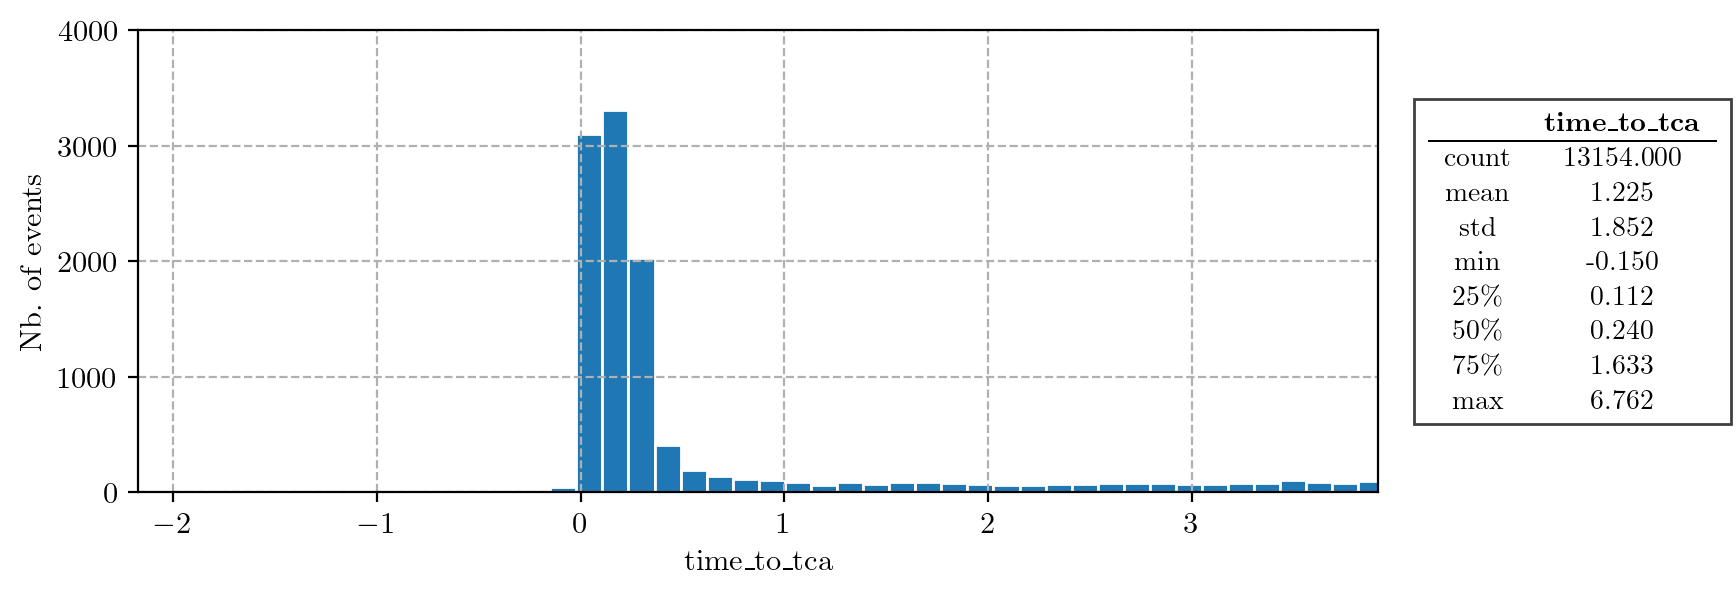

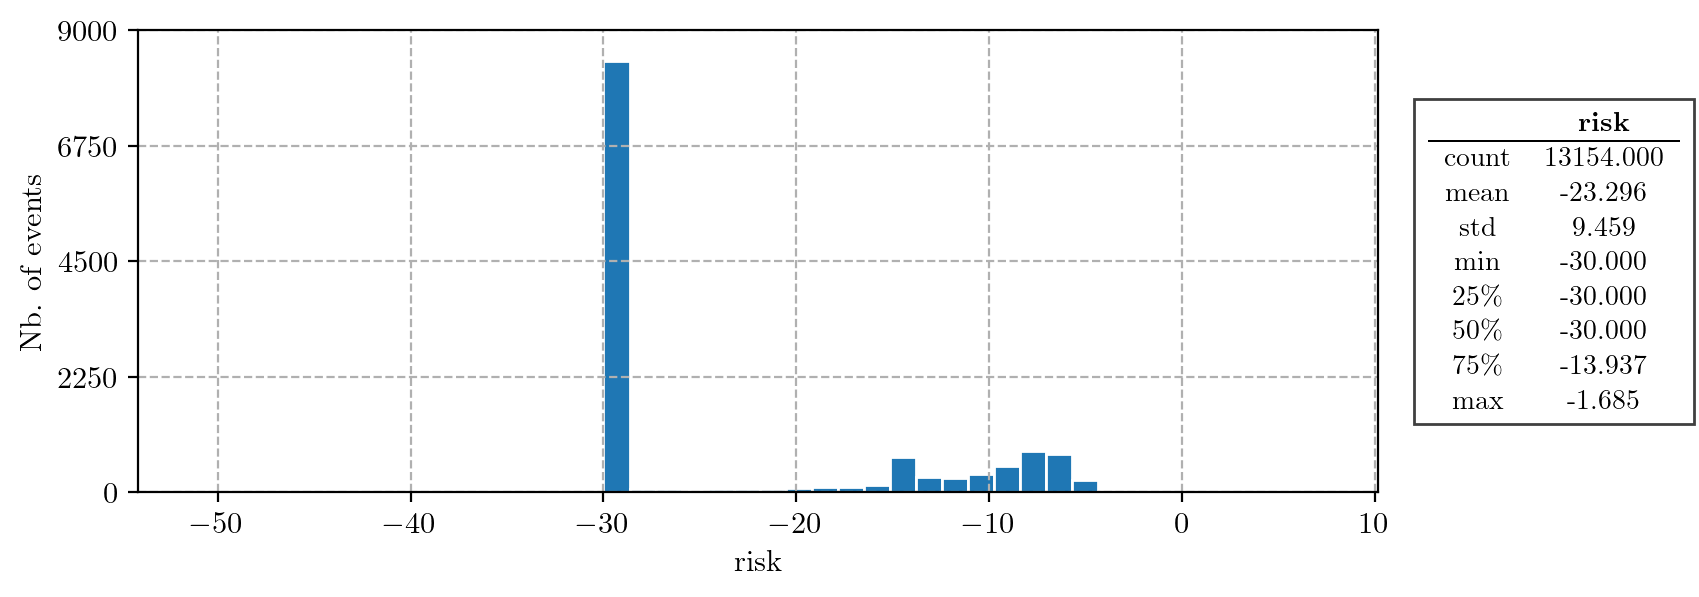

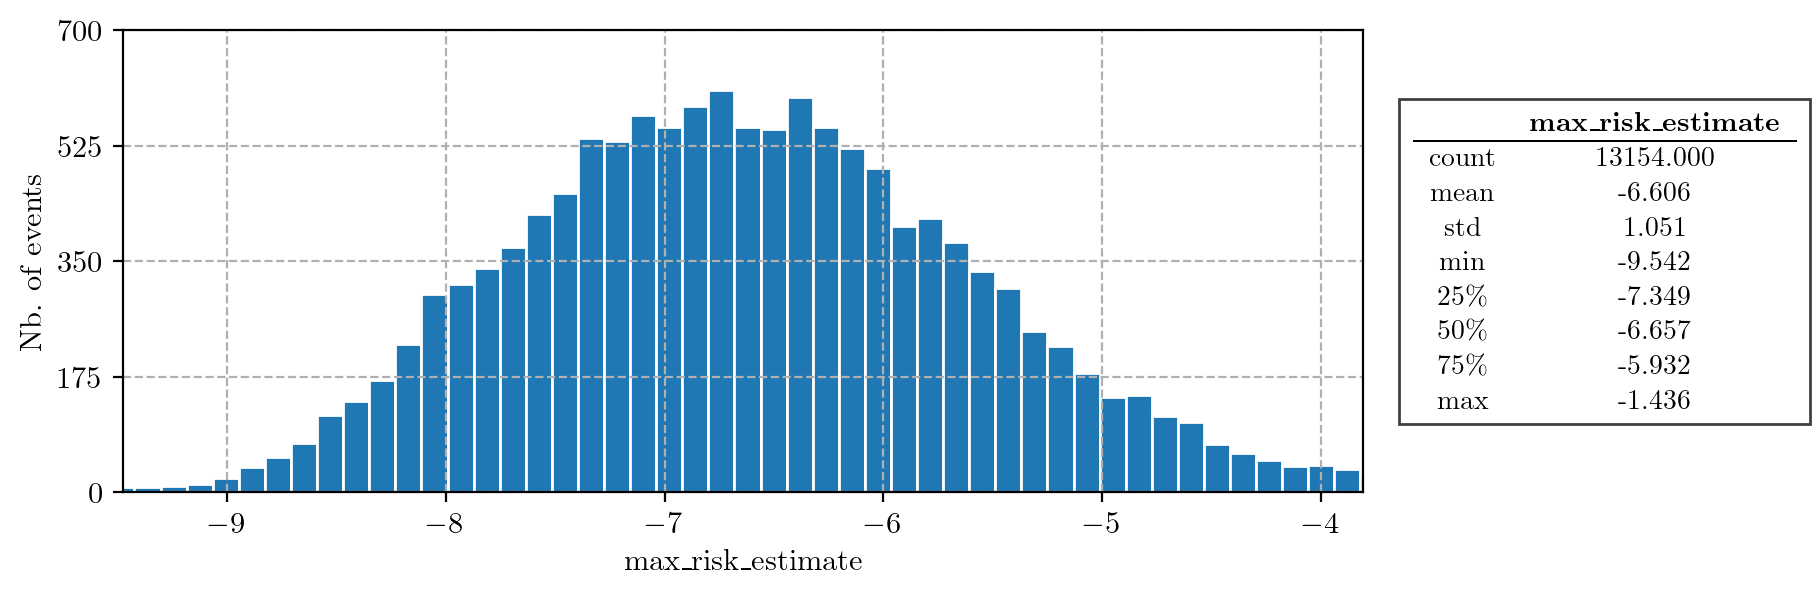

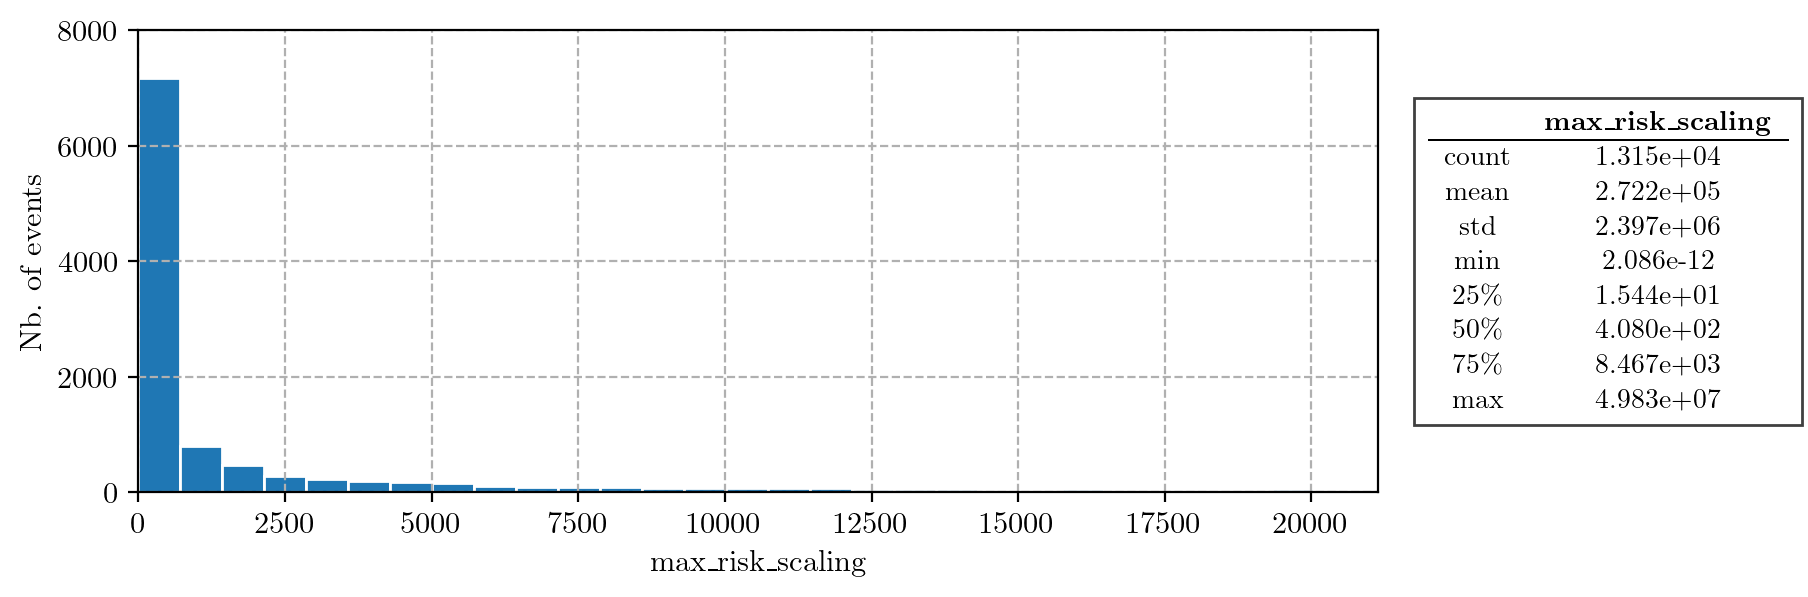

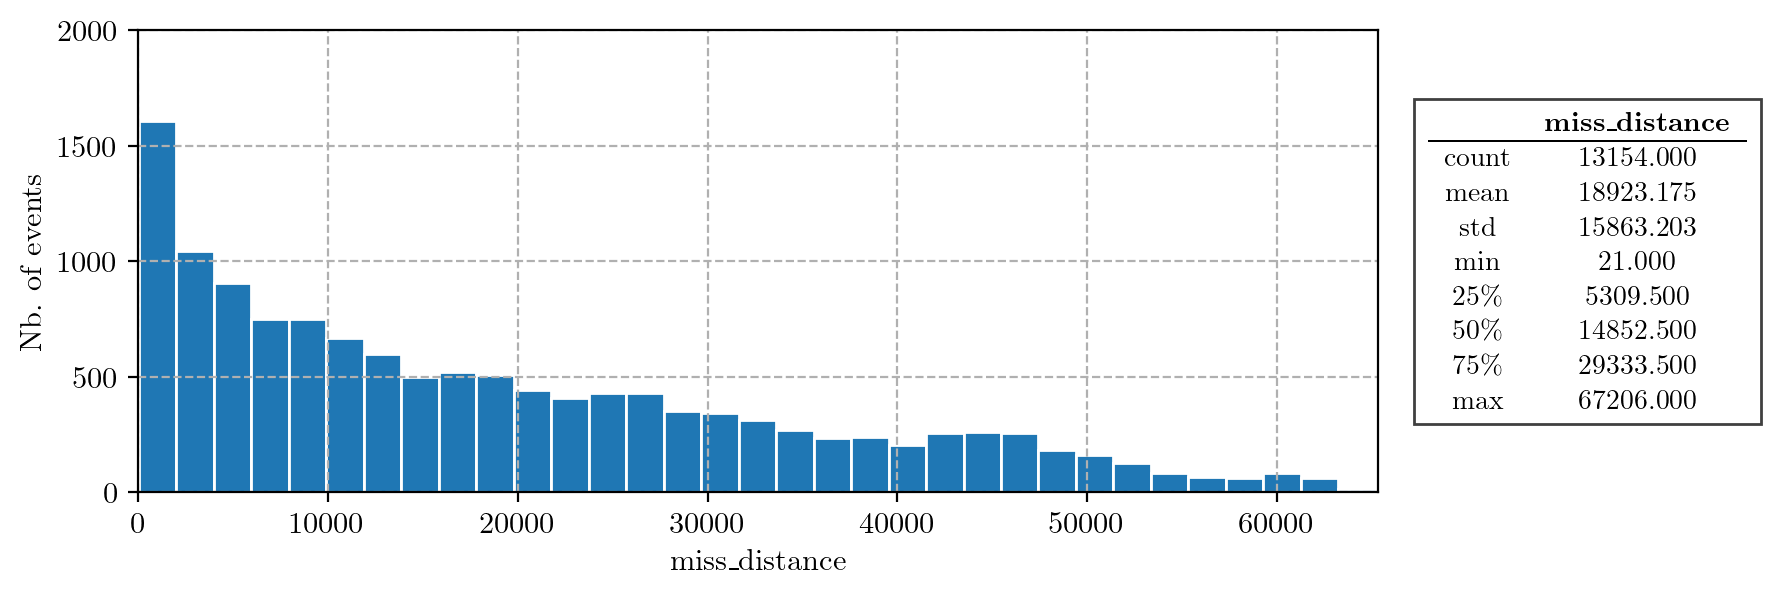

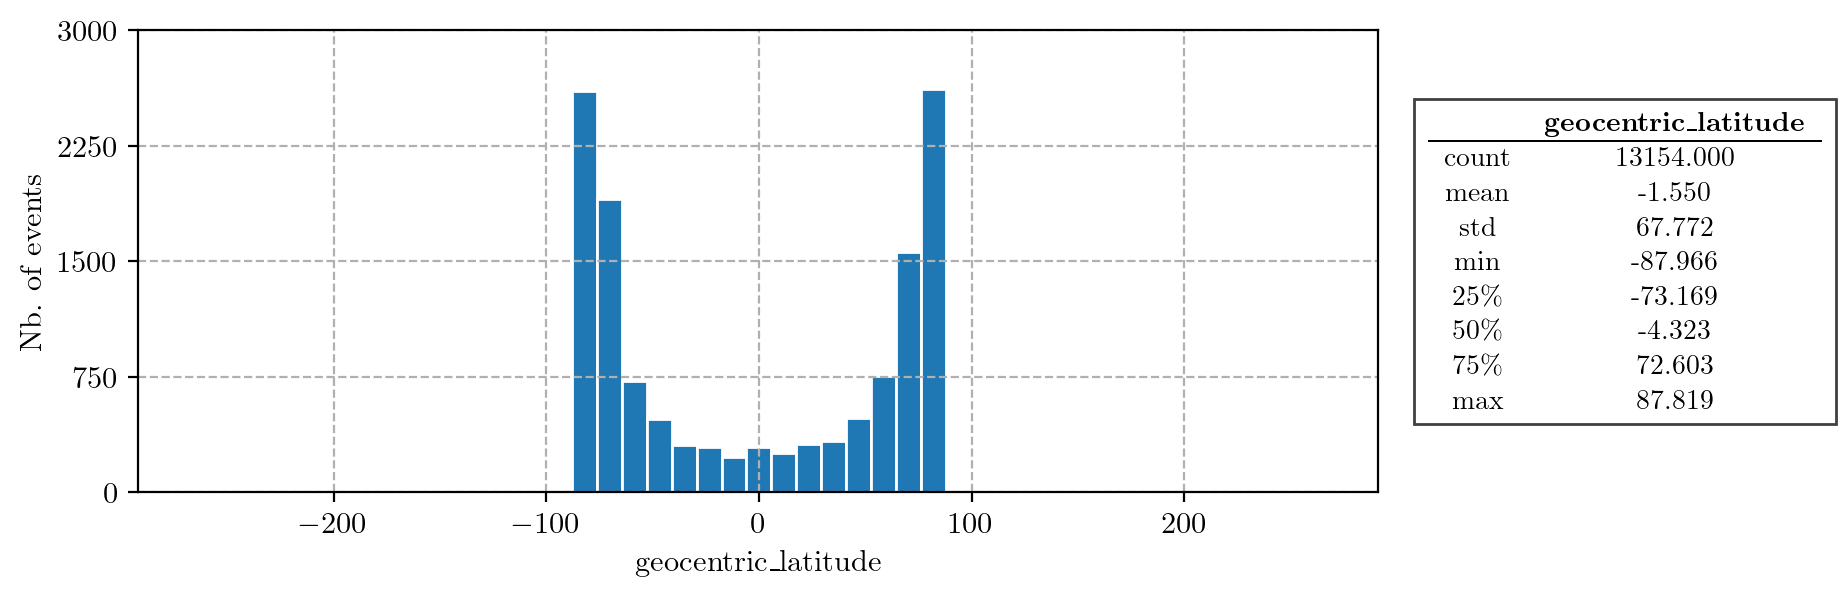

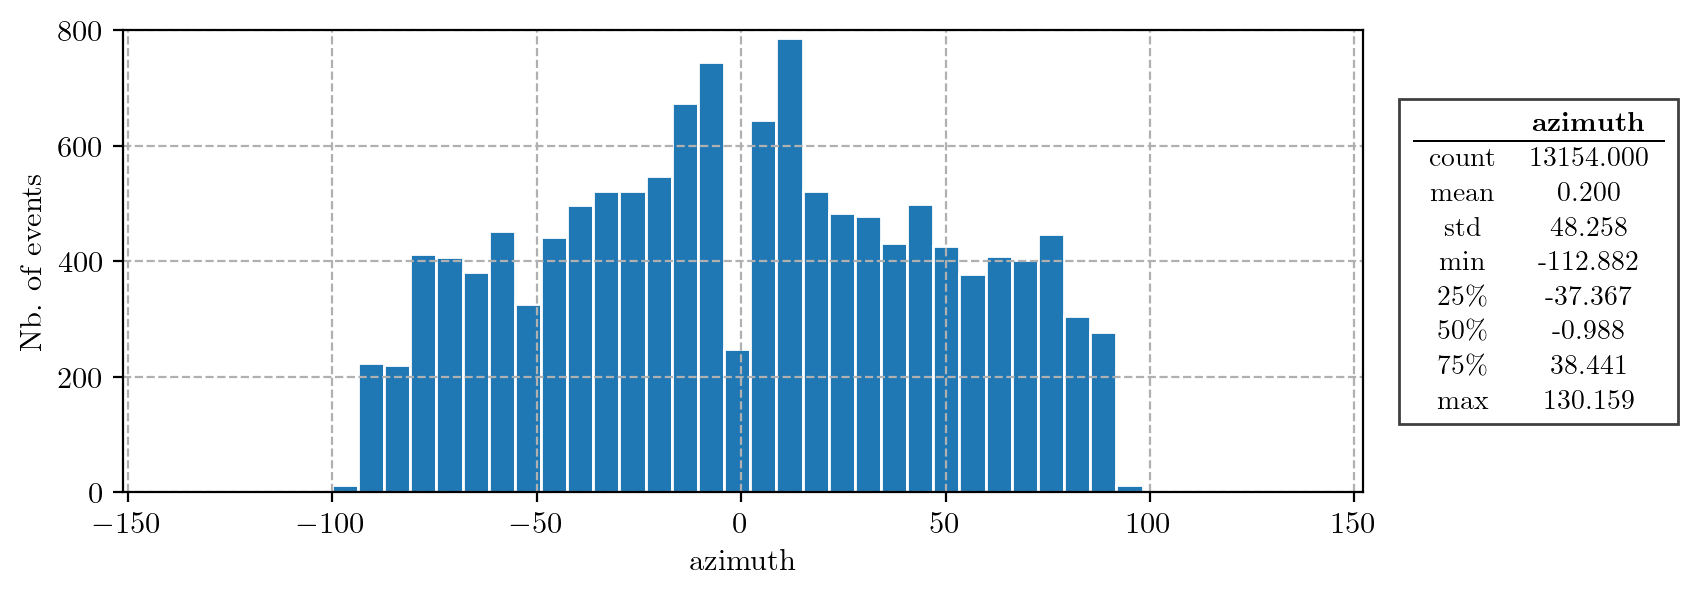

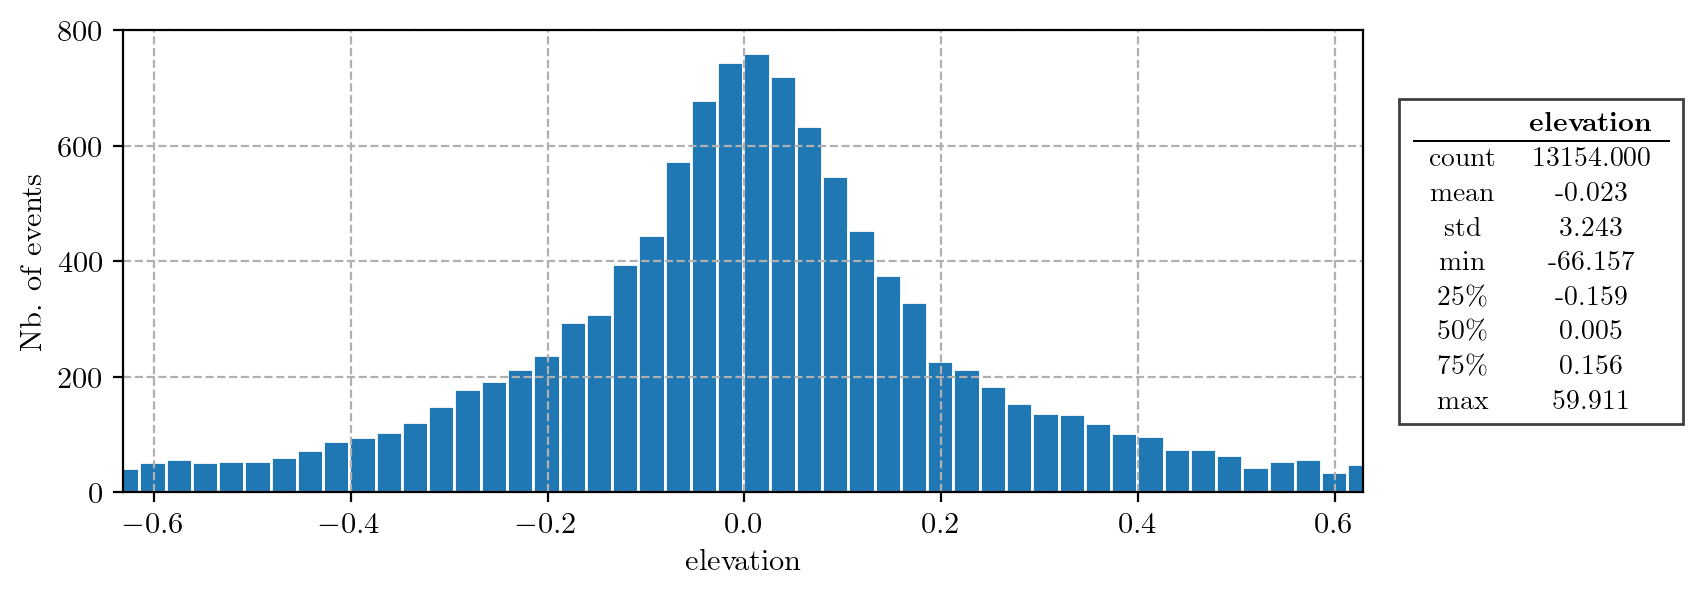

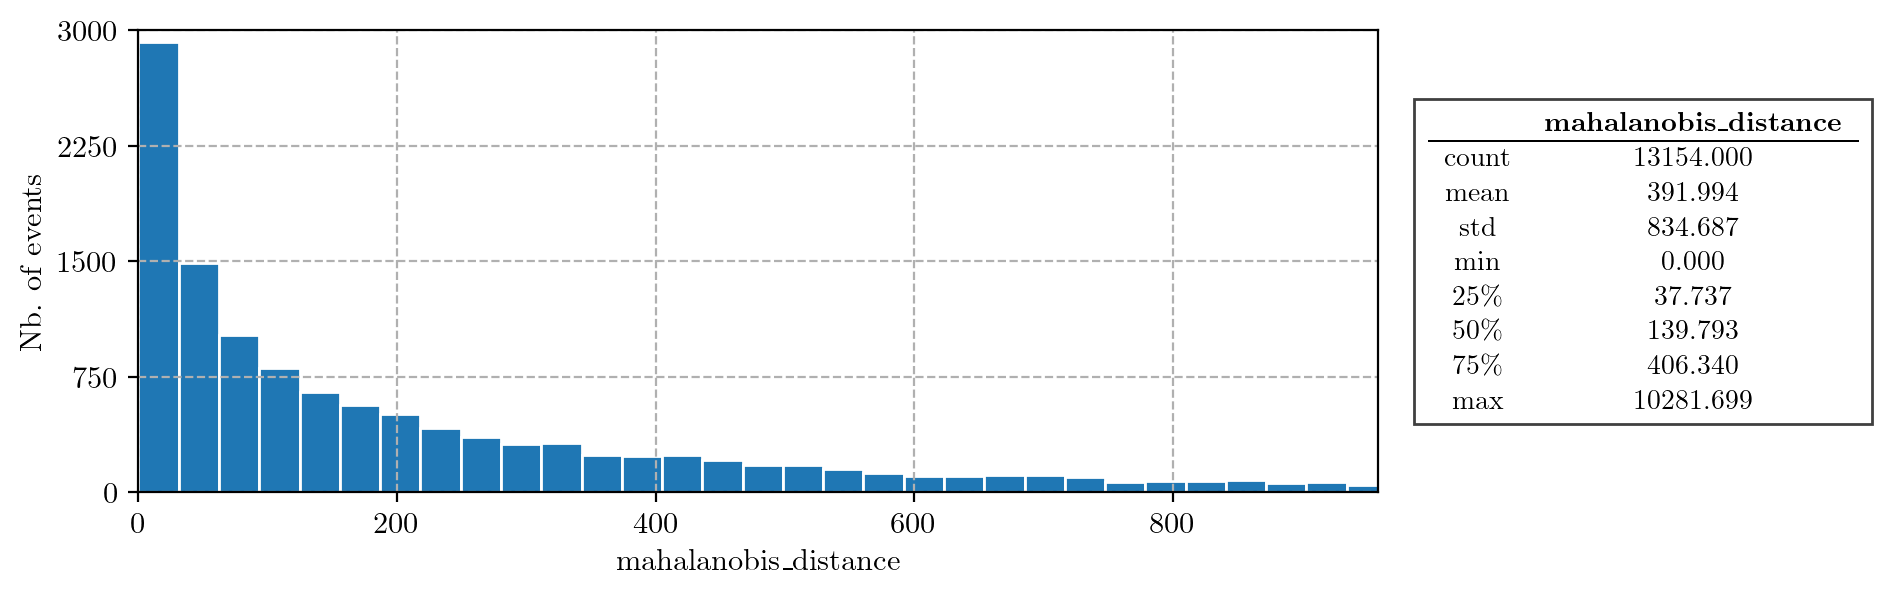

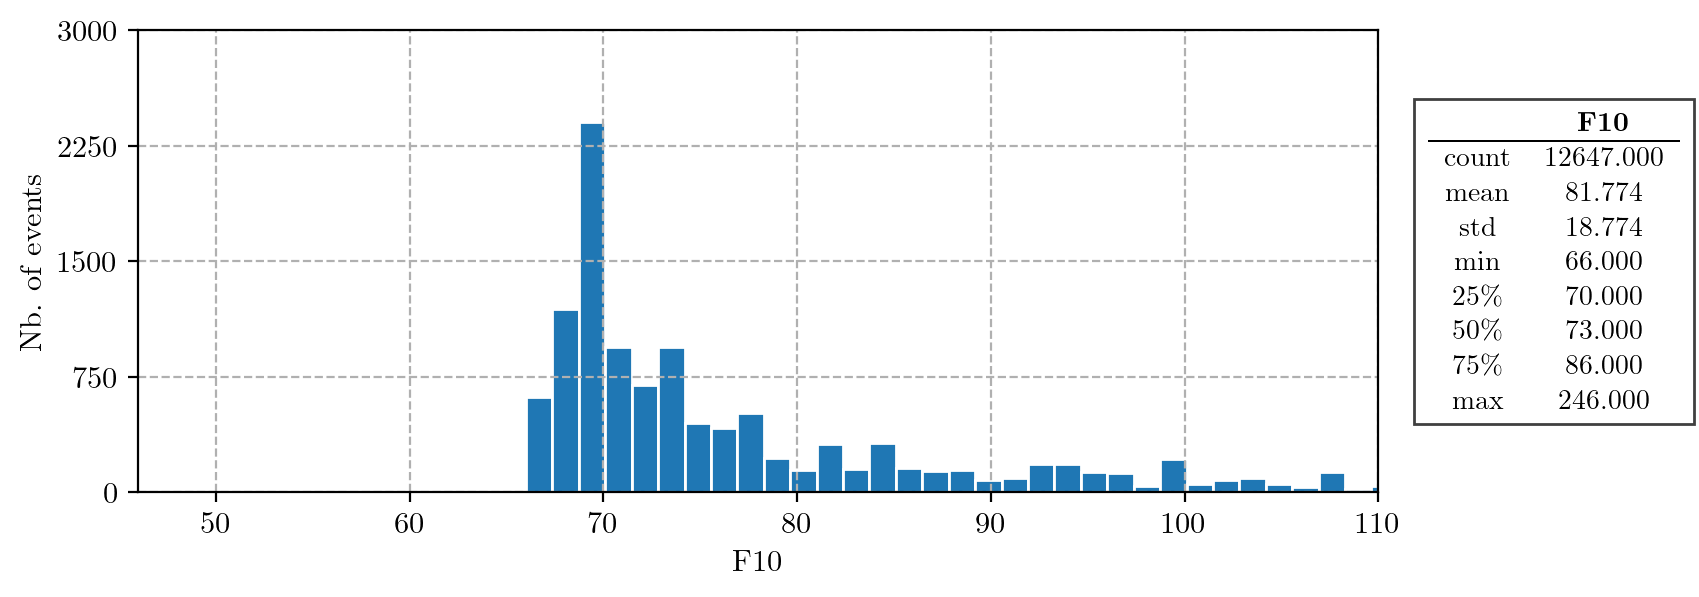

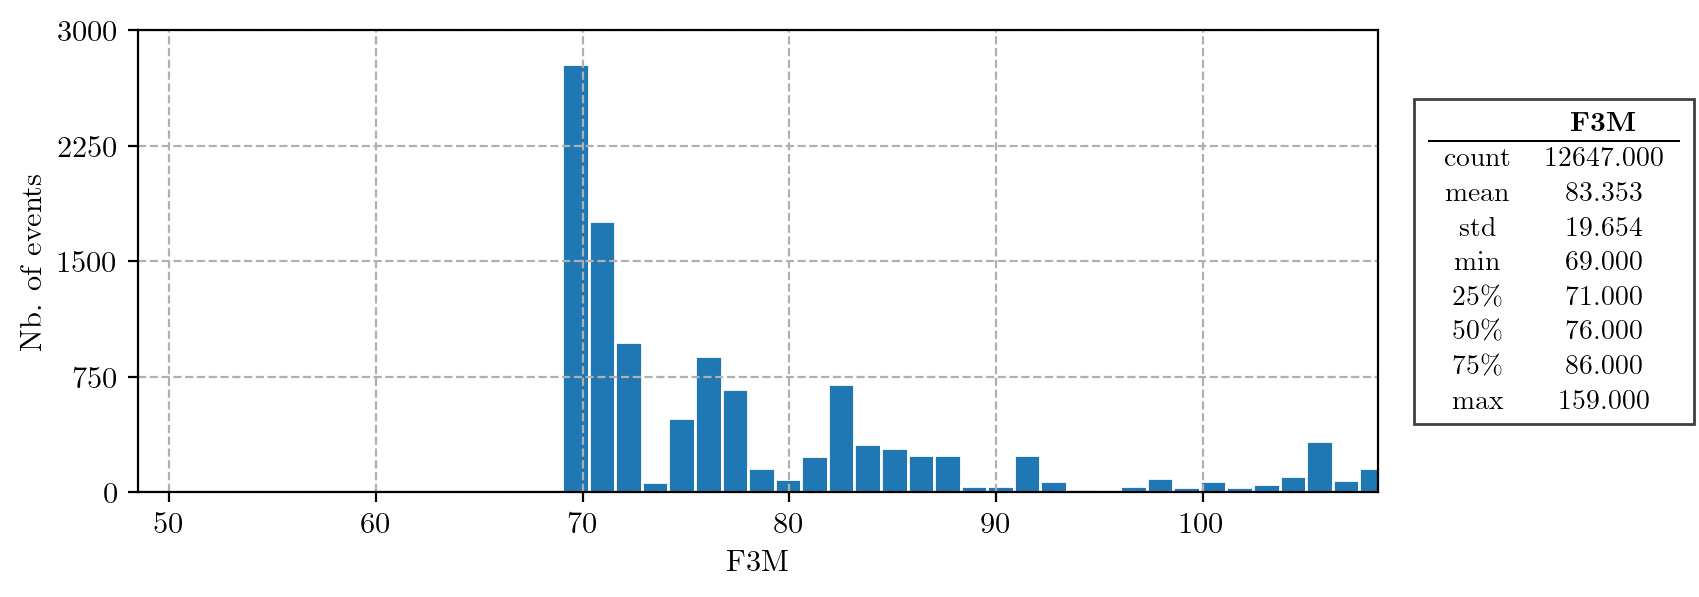

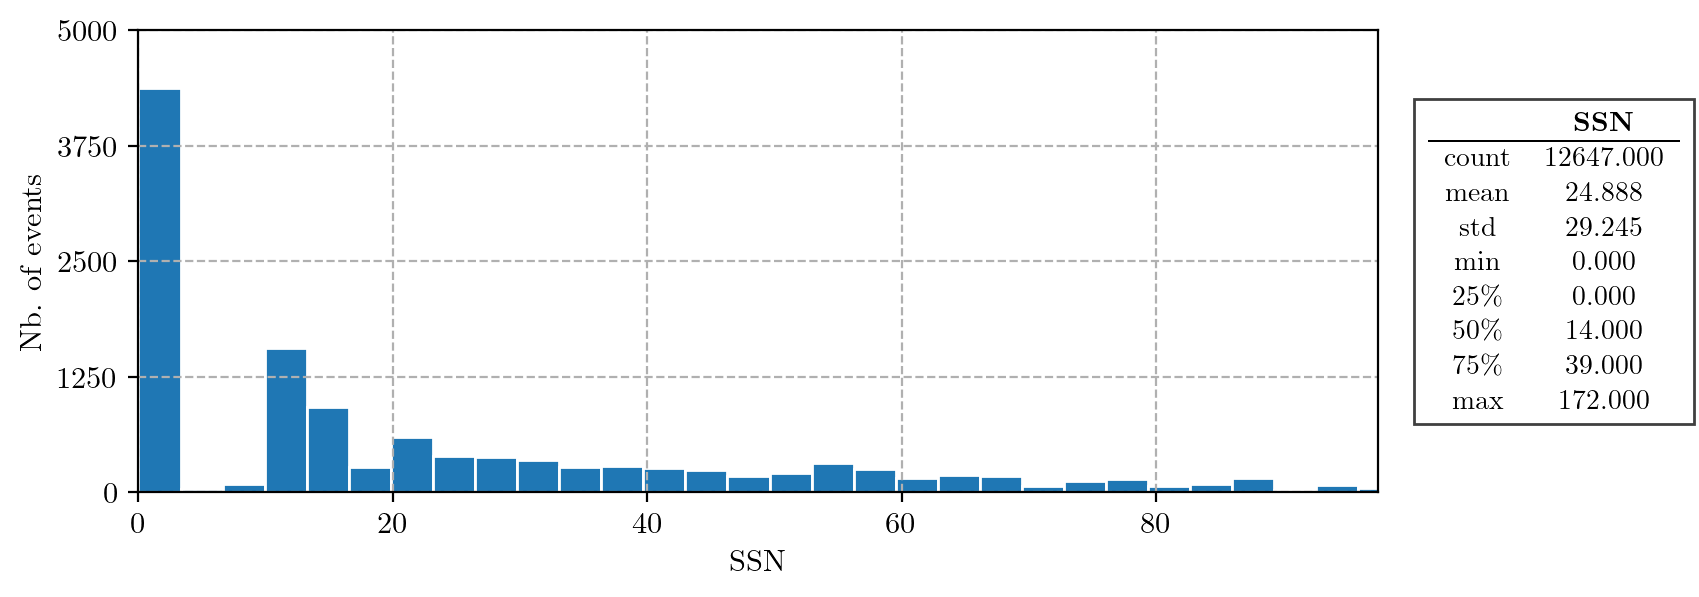

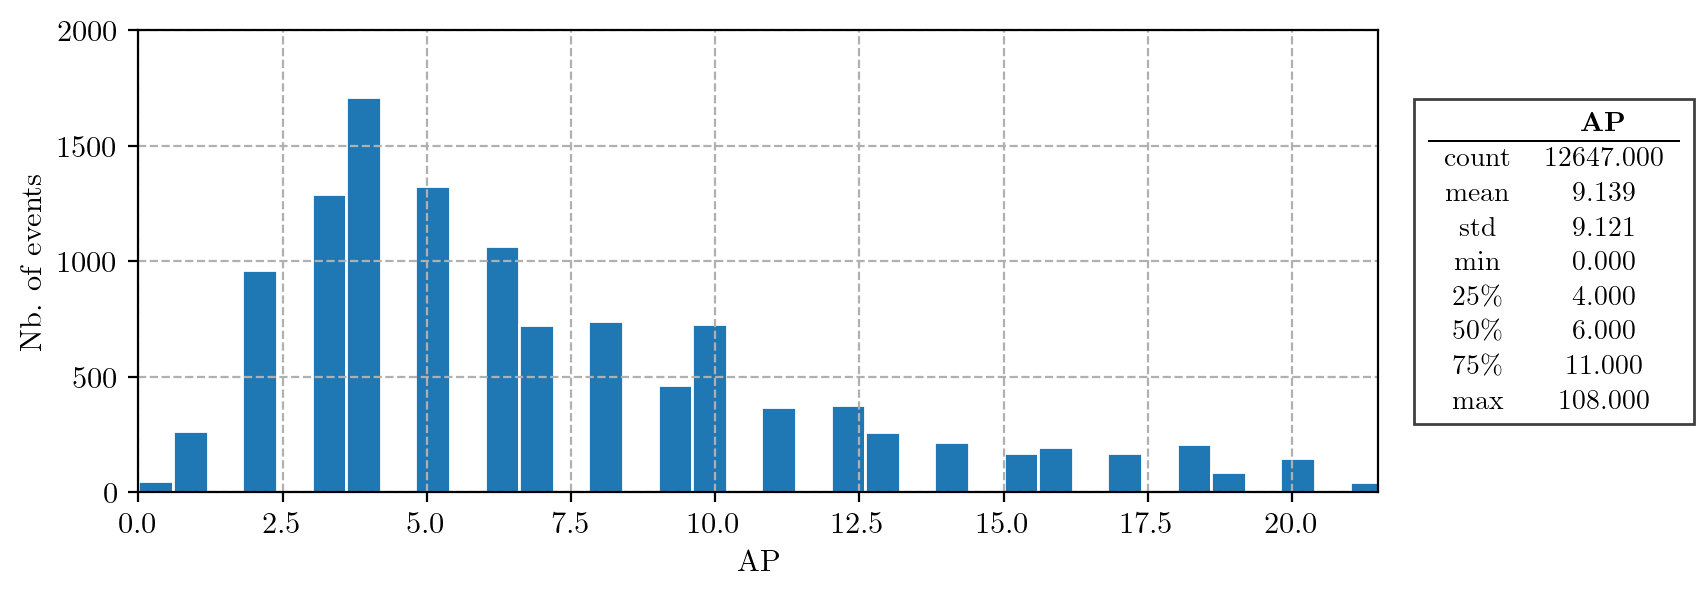

In [11]:
# Analyse the conjunction's data distributions
for column in column_clusters['conjunction'] :

    # Convert pandas series to numpy array for better manipulation
    data = df_lastCDM[column].to_numpy()
    data = data[~np.isnan(data)]
    
    # Get boundaries to identify outliers in order to increase readability in charts.
    xlim = utils.outliers_boundaries(data, threshold = 1.5, positive_only=(np.sum(data<0)==0))
    
    # Plot histograms using the number of bins using Freedman-Diaconis’s rule
    plt.figure(figsize=(8,3))
    
    axes = plt.gca()
     
    # Plot table with a basic statistical description of the data distribution    
    om = max(utils.order_of_magnitude(data.min()), utils.order_of_magnitude(data.max()))
    om = '{:.3e}' if om>=5 else '{:.3f}'

    text = df_to_latex(pd.DataFrame(data=data, columns =[column]).describe().applymap(om.format))

    t = axes.text(1.04, 0.5, text, size=10, ha='left', va='center', c='black', transform=axes.transAxes, 
              bbox=dict(facecolor='white', edgecolor='black', alpha=0.75, pad=5))
    
    # Plot histogram
    n, bin_edges, patches = plt.hist(data, bins = utils.nbins(data, 'fd')['n'], edgecolor='white', color='tab:blue')
    
    # Set both axis limits and ticks
    ylim = (0, round_by_mo(np.max(n), method='ceil', threshold=1.0))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.yticks(np.linspace(0, ylim[1], 5))
    
    # Set both axis labels
    plt.ylabel(r'Nb. of events')
    plt.xlabel(column)
    plt.grid(True, linestyle='--')
    
    plt.show()

### 2.2. - Multicollinearity and data distribution analysis for *Target* and *Chaser* specific features

For object specific data, the User Defined Function (UDF) `plot_target_chaser_hist()` is developed below to visually compare *Target* vs *Chaser* data distributions separately. The logic behind this segregation is to focus on *Targets* objects under the assumption they are the only ones with capabilities to manouvre for collision avoidance.

This function is applied accross all different clusters of features for every objects in the following sections.

In [12]:
def plot_object_hist(df_input, column, bins_rule, **kwargs):
    
    objects = kwargs.get('objects',['c', 't'])
                   
    # Normalize data if passed as argument
    data = {}
    for o in objects:
        
        data[o+'_'+column] = np.array(df_input[o+'_'+column].values).flatten()
        data[o+'_'+column] = data[o+'_'+column][~np.isnan(data[o+'_'+column])]
        
        if kwargs.get('normalize', False):
            data[o+'_'+column] = normalize([data[o+'_'+column]], norm='max').flatten()
    
    # Compute number of outliers for better representation on histogram
    all_data = np.array(list(data.values())).flatten()
    std_lims = utils.outliers_boundaries(all_data, threshold = 1.5, positive_only=np.sum(all_data<0)==0)
        
    # Identify outliers
    outliers = (all_data<std_lims[0]) | (all_data>std_lims[1])
    
    # Calculate number of bins to plot histogram 
    bins = utils.nbins(all_data[~outliers], bins_rule)['n']
    
    # Create figure object
    plt.figure(figsize=(8,3))
    
    axes = plt.gca()
    
    
    # Print statistical summary before the histogram
    if kwargs.get('describe', False): 
        
        om = max(utils.order_of_magnitude(all_data.min()), utils.order_of_magnitude(all_data.max()))
        om = '{:.3e}' if om>=5 else '{:.3f}'
        
        text = df_to_latex(pd.DataFrame(data=data).describe().applymap(om.format))
        
        t = axes.text(1.04, 0.5, text, size=10, ha='left', va='center', c='black', transform=axes.transAxes, 
                  bbox=dict(facecolor='white', edgecolor='black', alpha=0.75, pad=5))


    # Compute new X-axis limits for a better plot representation.
    xlim = kwargs.get('xlim', (round_by_mo(max(std_lims[0], all_data.min()), 'floor', 0.5), 
                               round_by_mo(min(std_lims[1], all_data.max()), 'ceil', 0.5)))
    
    # Plot Target and Chaser histograms
    obj_dict={'t':{'color':'tab:blue',  'label': r'Target'},
              'c':{'color':'tab:orange','label': r'Chaser'}}
    
    plt_kwargs = dict(range=xlim, edgecolor='white', bins=bins, alpha=0.6 if len(objects)>1 else 1.0)
    for o in objects:
        plt.hist(data[o+'_'+column], label=obj_dict[o]['label'], color=obj_dict[o]['color'], **plt_kwargs)
    
    # Compute new Y-axis limits for a better plot representation.
    ylim = kwargs.get('ylim',(axes.get_ylim()[0], round_by_mo(axes.get_ylim()[1], 'ceil')))

    plt.grid(True, linestyle='--')
    plt.yticks(np.linspace(ylim[0],ylim[1],5))
    plt.xlim(xlim)
    plt.ylim(ylim)

    # Set axis labels
    xlabel = r'' + kwargs.get('xlabel', column)
    title  = r'' + kwargs.get('title', 'Histogram') 
    
    plt.ylabel(r'Number of objects') 
    plt.xlabel(xlabel)
    plt.title(title)
    
    # Plot legend and print plot
    plt.legend(loc='upper right', fontsize=12)
    plt.show()
    
    return

#### 2.2.1. - Orbital elements

The analysis of the orbital analysis data distribution for *Targets* objects as well as the multicollinearity underlying data is key in the SCDMG method as it allows the creation of random starting positions of ASOs in orbit (including *Chaser* objects).

Out of the 5 orbital elements present in the raw data (Apogee, Perigee, Semi-major axis, Eccentricity, and Inclination), we expect 2 out of 4 (Apogee, Perigee, Semi-major axis, and Eccentricity) to be highly correlated. This is because within a single revolution (low orbit perturbations), any two features describe very accuretely the other two. To confirm this latter point, a VIF analysis is performed.

MULTICOLLINEARITY ANALYSIS (R2 score > 0.80):
 {
    "independent": {
        "t_j2k_ecc": 1.0520880280169096,
        "t_j2k_inc": 1.950843548832446,
        "t_j2k_sma": 1.9878742622226853
    },
    "correlated": {
        "t_h_apo": Infinity,
        "t_h_per": 673326.365734076
    }
}
MULTICOLLINEARITY ANALYSIS (R2 score > 0.80):
 {
    "independent": {
        "c_h_per": 1.0309486132380805,
        "c_j2k_inc": 1.2150211770663957,
        "c_j2k_sma": 1.1839724588960217
    },
    "correlated": {
        "c_h_apo": Infinity,
        "c_j2k_ecc": 12.729939707670438
    }
}


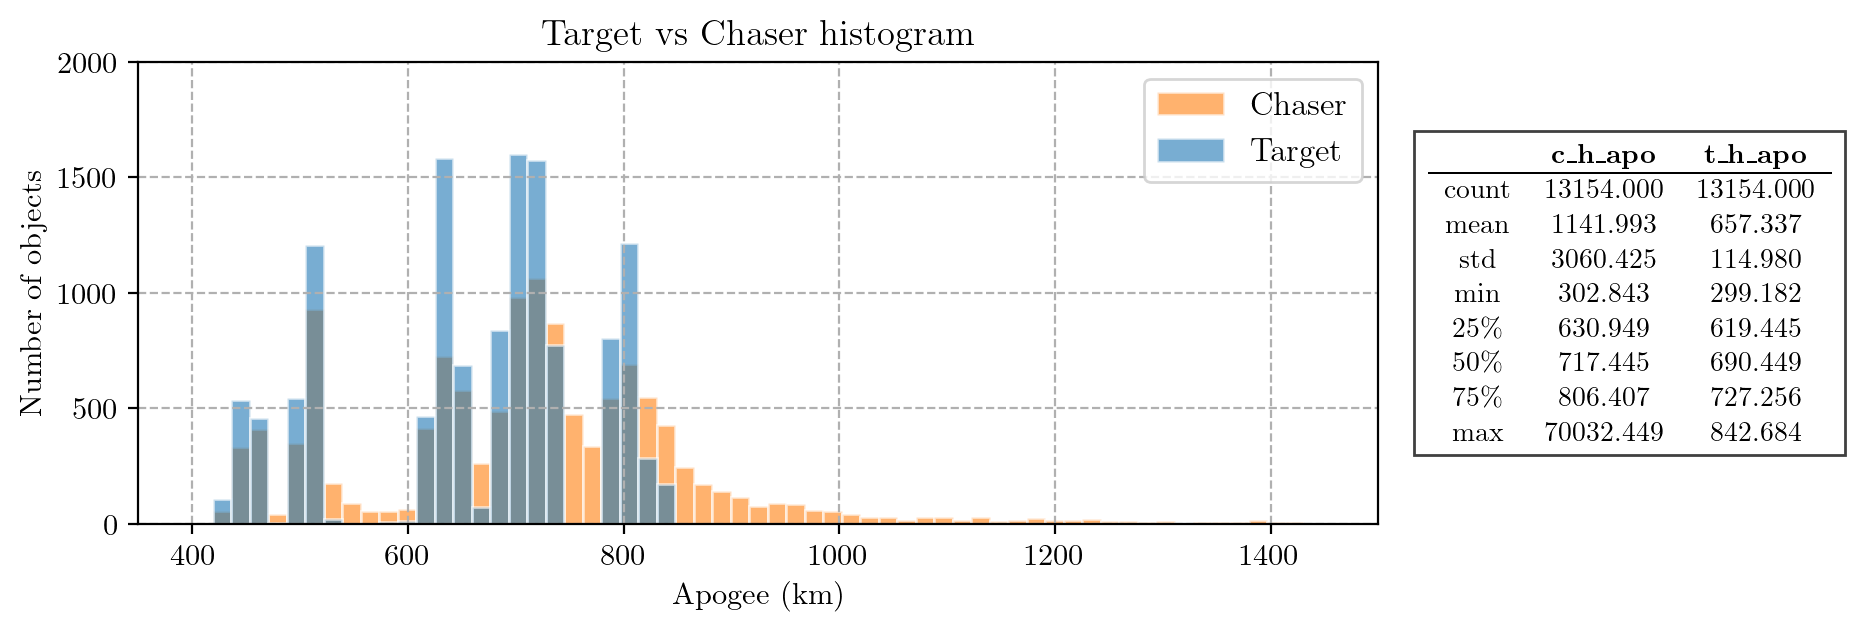

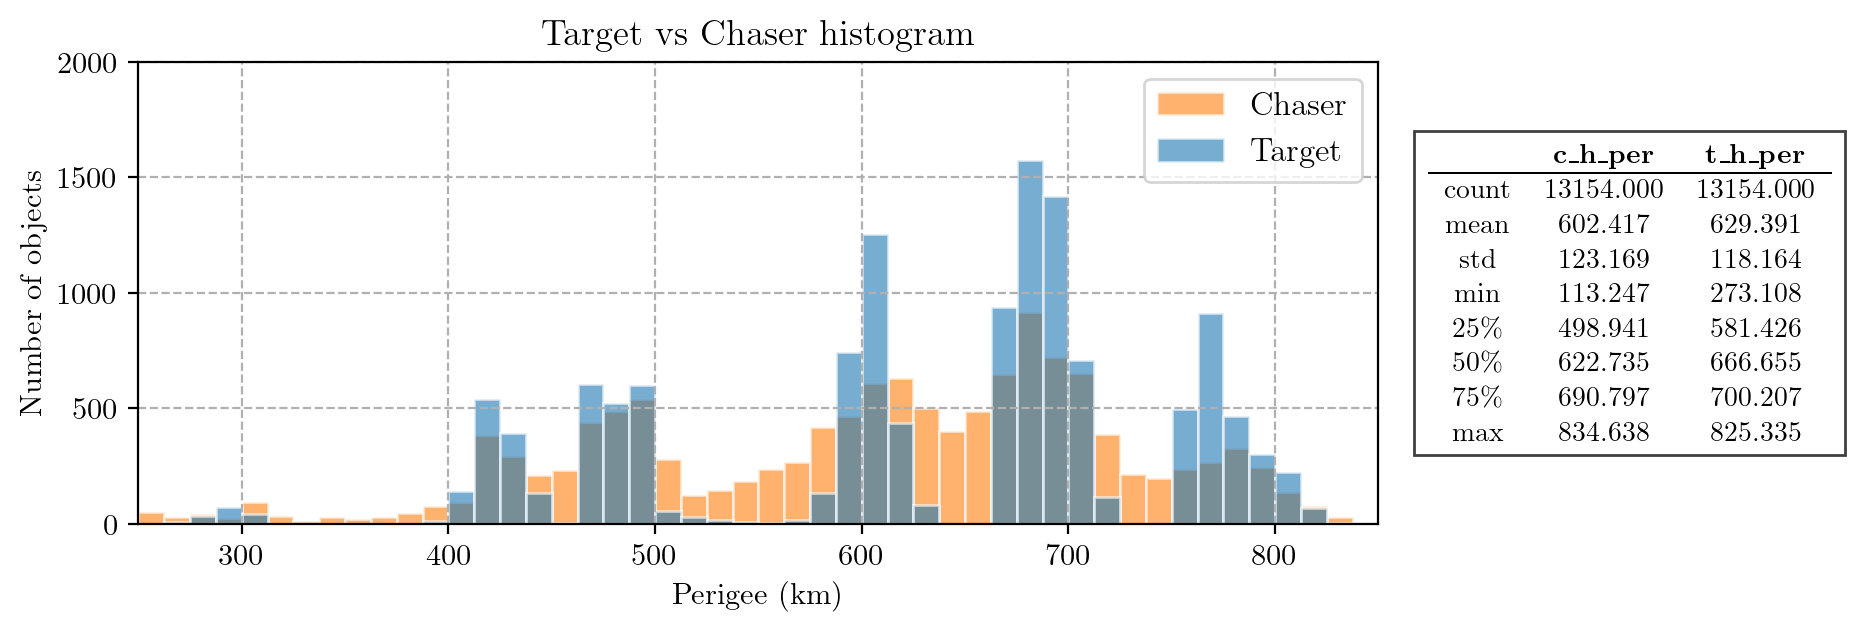

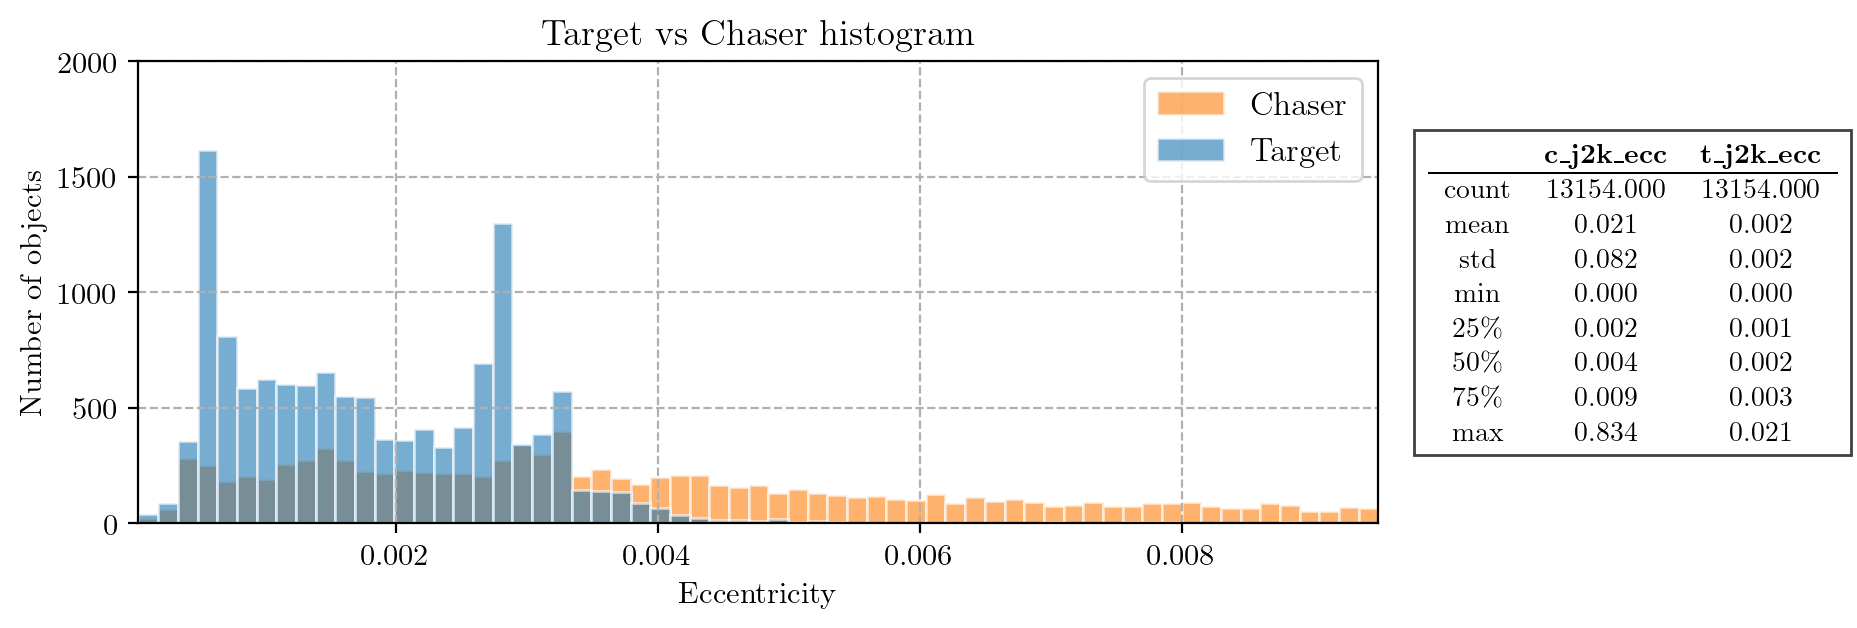

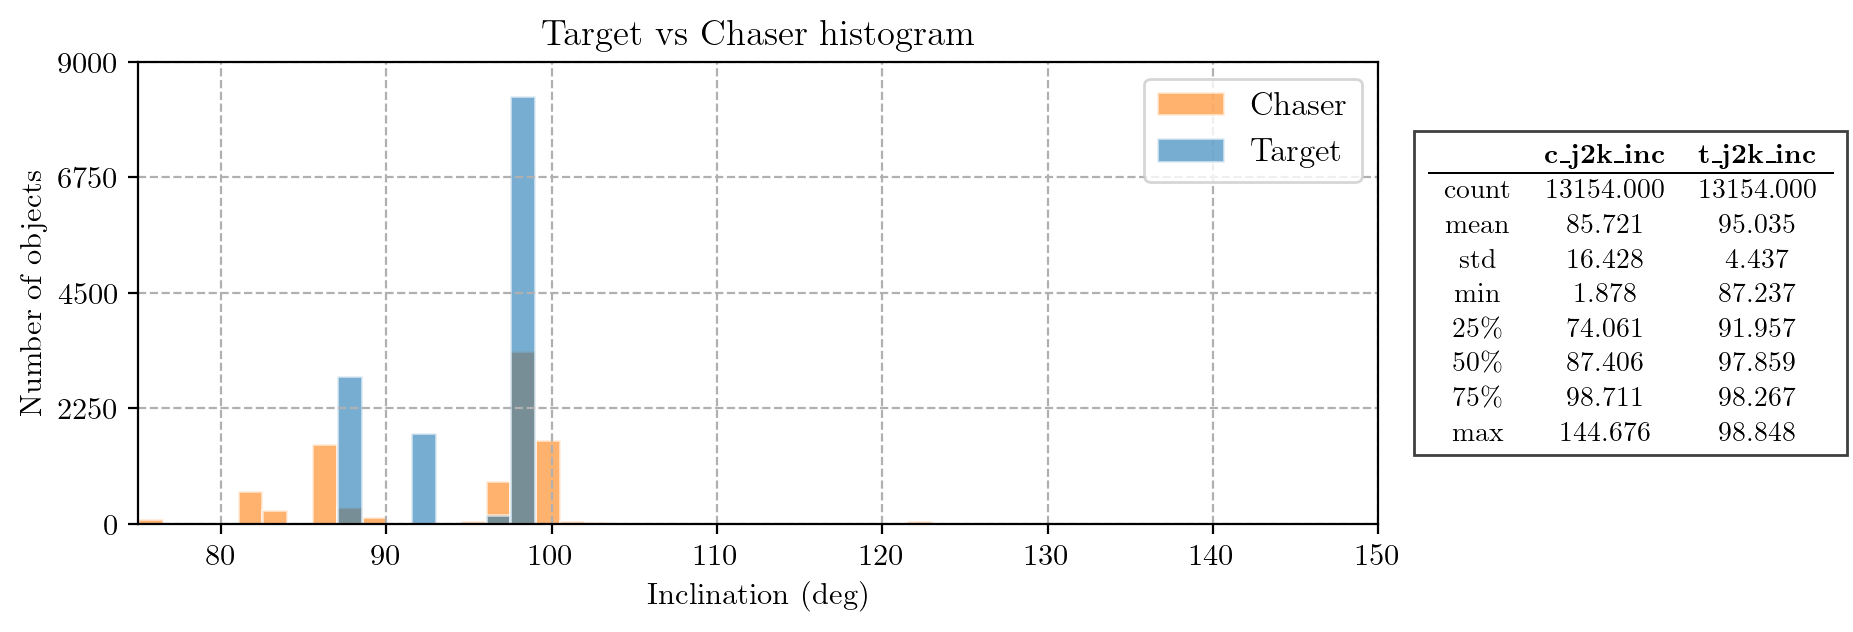

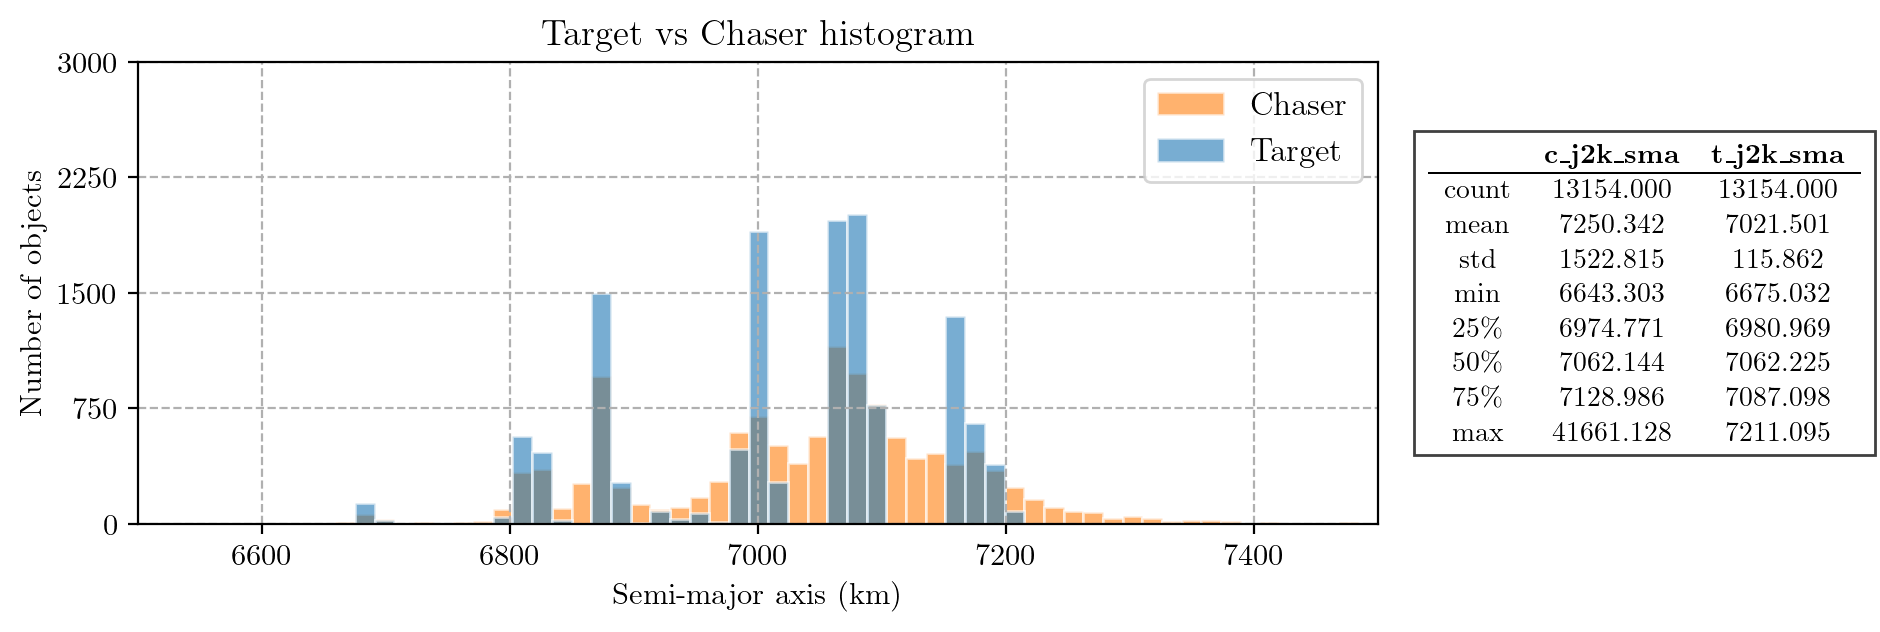

In [13]:
# Define orbital elements columns dictionary
legend = {'h_apo':   'Apogee (km)',
          'h_per':   'Perigee (km)',
          'j2k_sma': 'Semi-major axis (km)',
          'j2k_inc': 'Inclination (deg)',
          'j2k_ecc': 'Eccentricity', 
             }

# Analyse multicollinearity in the conjunction cluster using the complete dataset
for obj in ['target', 'chaser']:
    print_collinearity(df, column_clusters[obj]['orb_elements'], 5)

# Analyse the conjunction's data distributions
for column in column_clusters['target']['orb_elements']:
    
    kwargs = {'xlabel': legend[column[2:]], 
              'title': 'Target vs Chaser histogram',
              'describe': True}
    plot_object_hist(df_lastCDM, column[2:], bins_rule='fd', **kwargs)
    

##### Conclusions
 * Targets operational space regions, and hence their orbital elements, are clearly defined as opposed to Chaser objects. In particular, **Targets *Apogee*, *Perigee*, and *Semi-major axis* data are enclosed into very well defined range of values**. This is because Targets are satellites that are still operational and controlled by their respective operators, whereas Chasers are usually derelict pieces that have drifted from their operational orbits.
 * **Only three Targets orbital elements (features), one of which is the Inclination, are independent**. The selection of the other two will be based on the difficulty to be approached by a robust Probability Density Estimation method. 
 * Targets *Perigee* data is grouped into better defined operational regions than *Apogee*, and *Semi-major axis*. Therefore, **only *Perigee*, *Eccentricity* and *Inclination* orbital elements will be considered for the SCDMG process**. The rest of the orbital elements from Targets and Chasers become trivial.

#### 2.2.2. - Ballistic and solar radiation coefficient per unit of area over mass


MULTICOLLINEARITY ANALYSIS (R2 score > 0.80):
 {
    "independent": {
        "t_cd_area_over_mass": 1.000155993076776,
        "t_cr_area_over_mass": 1.000155993076776
    },
    "correlated": {}
}
MULTICOLLINEARITY ANALYSIS (R2 score > 0.80):
 {
    "independent": {
        "c_cd_area_over_mass": 1.6727647385185236,
        "c_cr_area_over_mass": 1.672764738518524
    },
    "correlated": {}
}


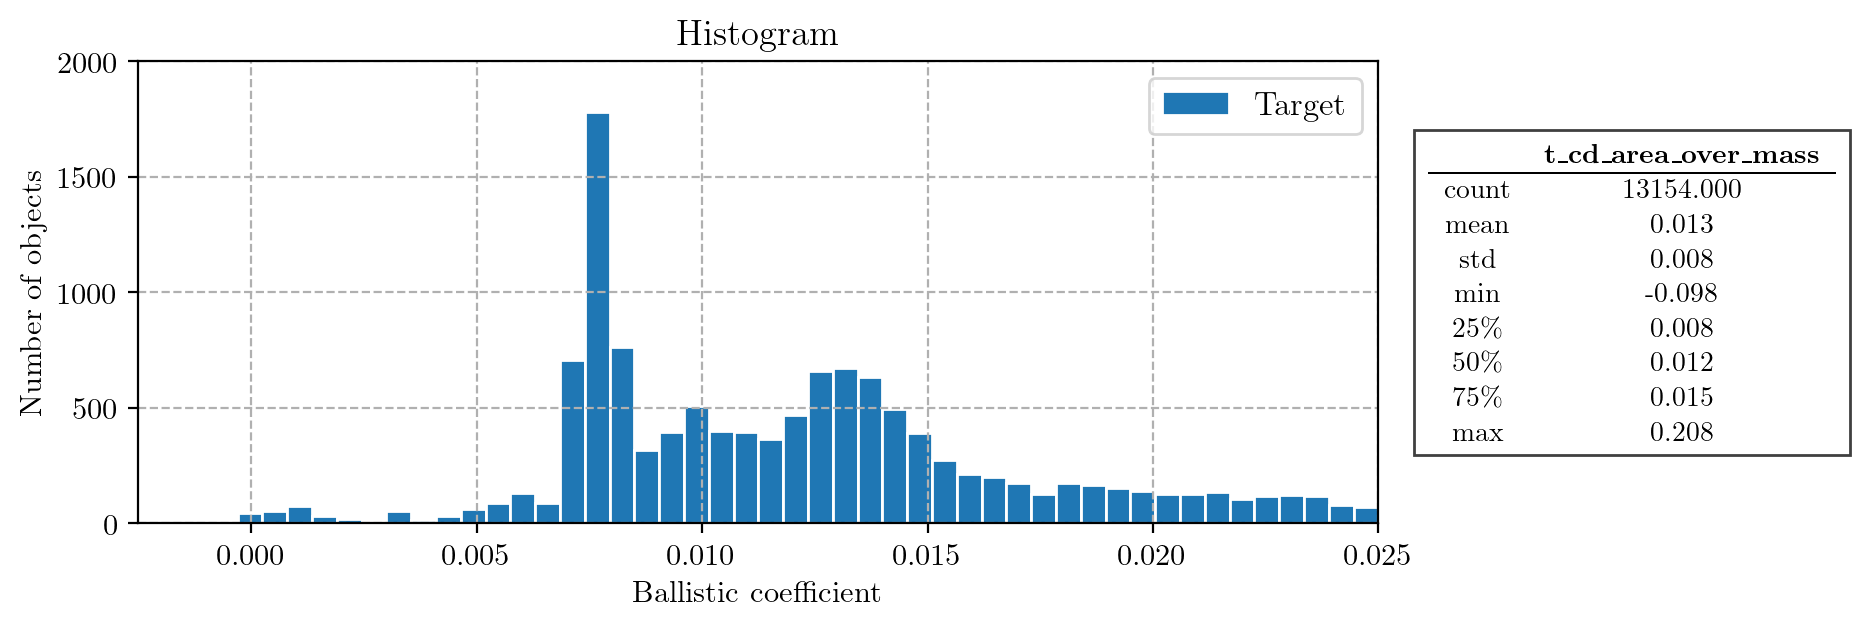

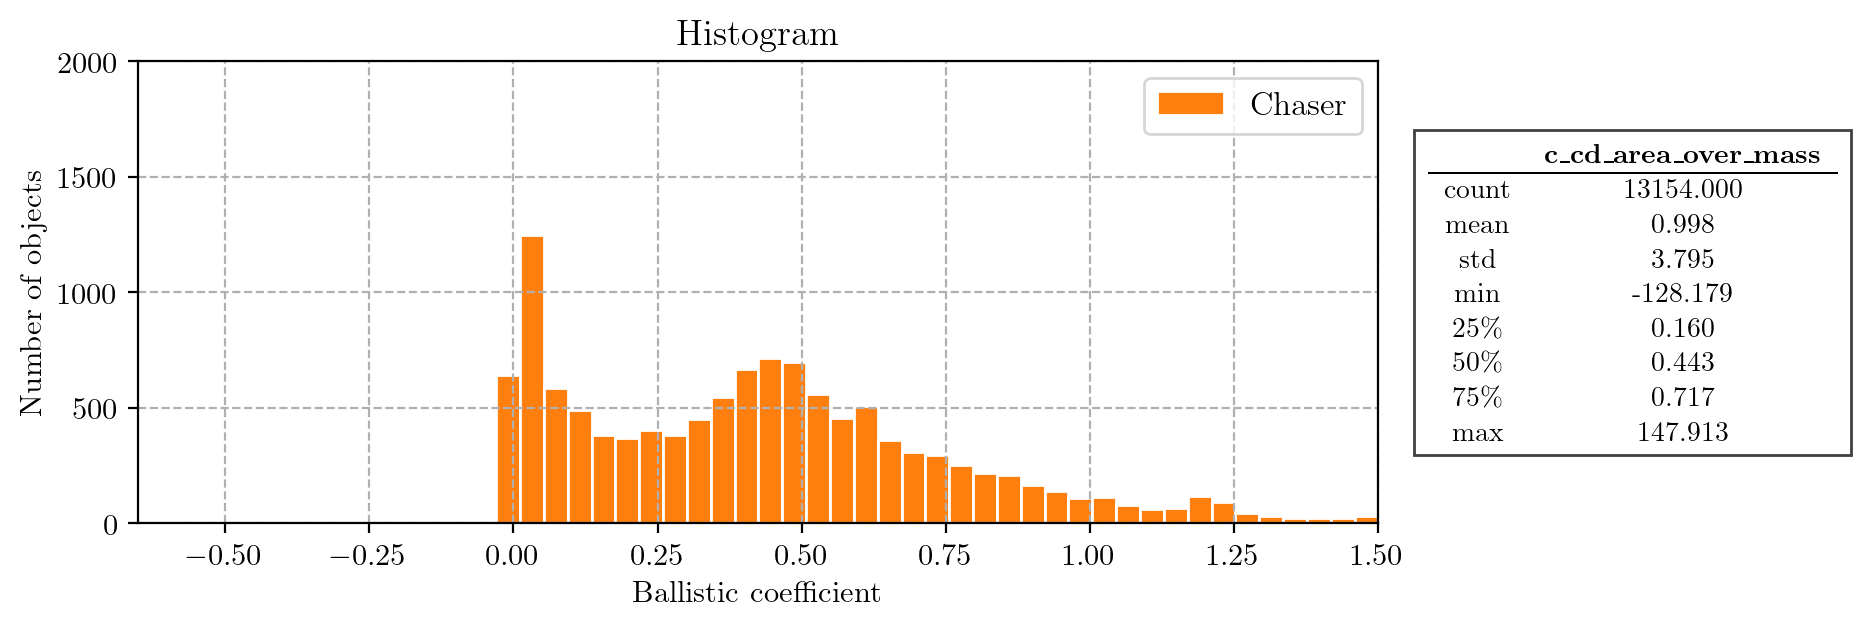

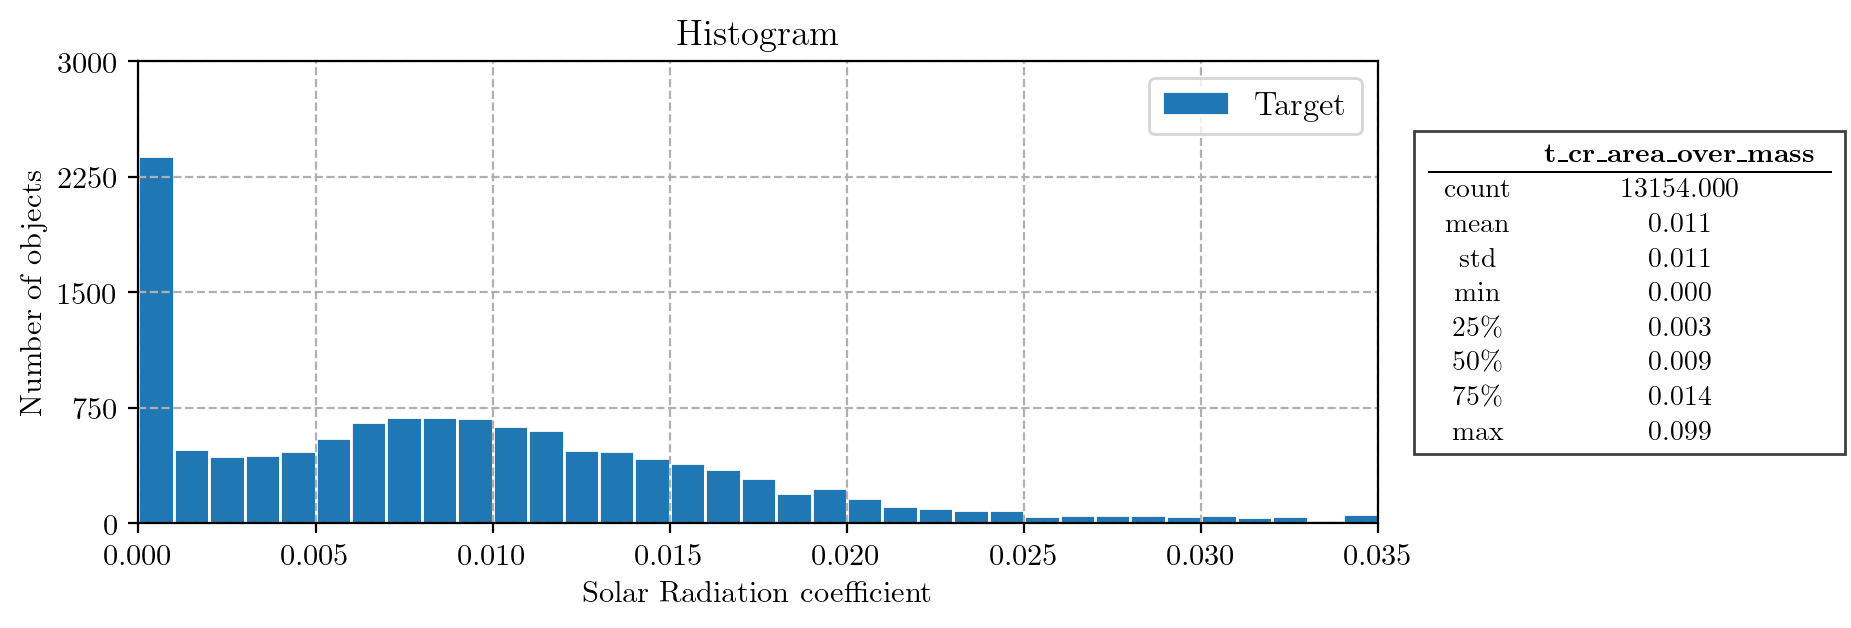

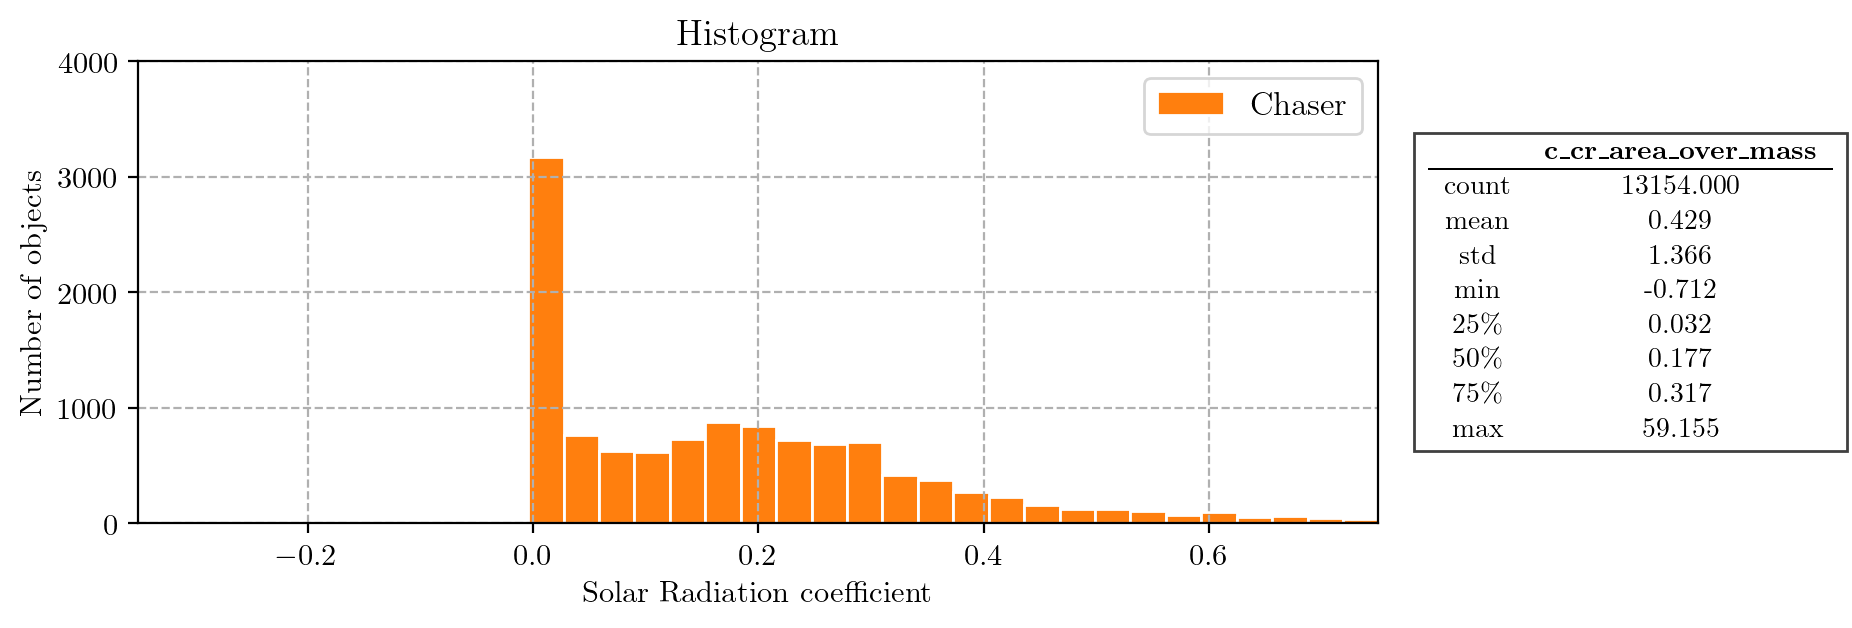

In [14]:
# Define orbital elements columns dictionary
legend = {'cd_area_over_mass':   'Ballistic coefficient',
          'cr_area_over_mass':   'Solar Radiation coefficient'}

# Analyse multicollinearity in the conjunction cluster using the complete dataset
for obj in ['target', 'chaser']:
    print_collinearity(df, column_clusters[obj]['coeff'], 5)

# Analyse the conjunction's data distributions
for column in column_clusters['target']['coeff']:
    for o in ['t', 'c']:
        kwargs = {'objects':[o],
                  'describe': True,
                  'xlabel': legend[column[2:]]}
        plot_object_hist(df_lastCDM, column[2:], bins_rule='fd', **kwargs)


#### 2.2.3. - State vector covariance matrix

The analysis of the covariance matrix in the RTN Coordinate frame of the state vector is key as it is a measure of the error of the orbit prediction. From a mathematical perspective, it is expressed as follows:

$$\newcommand{\cov}{\mathrm{cov}}
\begin{bmatrix}
\sigma^2_{R} & - & - & - & - & - \\
\cov(T,R) & \sigma^2_{T} & - & - & - & - \\
\cov(N,R) & \cov(N,T) & \sigma^2_{N} & - & - & - \\
\cov(\dot{R},R) & \cov(\dot{R},T) & \cov(\dot{R},N) & \sigma^2_{\dot{R}} & - & - \\
\cov(\dot{T},R) & \cov(\dot{T},T) & \cov(\dot{T},N) & \cov(\dot{T},\dot{R}) & \sigma^2_{\dot{T}} & - \\
\cov(\dot{N},R) & \cov(\dot{N},T) & \cov(\dot{N},N) & \cov(\dot{N},\dot{R}) & \cov(\dot{N},\dot{T}) & \sigma^2_{\dot{N}} \\
\end{bmatrix}$$

where the terms above the main diagonal are the same as the one below, that is, is a symmetrical matrix. It takes into account uncertainties inherent from the orbit determination methods used for the creation of the CDM. Therefore, it directly affects the estimated risk of collision and, as a consequence, the DL model to be developed.

For the SCMDG process, the development of a realistic covariance matrix assigned to every CDM is crucial to predict future collisions taking into account limitations of the technology available nowadays. At the same time, the apropriate manipulation of this matrix can help to identify required thresholds for improvement in order to get better predictions of collisions earlier in time.

Since uncertainties need to be replicated in the SCDMG process, a multicollinearity analysis is performed below to avoid trivial data generation, and non-necessary processing:

In [15]:
# Analyse multicollinearity in the conjunction cluster using the complete dataset
for obj in ['target', 'chaser']:
    print_collinearity(df, column_clusters[obj]['cov'], 5)

MULTICOLLINEARITY ANALYSIS (R2 score > 0.80):
 {
    "independent": {
        "t_cn_r": 1.2011982564196426,
        "t_cndot_n": 1.1028619575939915,
        "t_cndot_rdot": 1.0308907831922998,
        "t_cndot_tdot": 1.1497449930920844,
        "t_crdot_n": 1.073613149677004,
        "t_crdot_r": 3.4448270028048658,
        "t_crdot_t": 2.3689289245643925,
        "t_ctdot_r": 2.379184684184574,
        "t_ctdot_t": 3.378190767972183
    },
    "correlated": {
        "t_sigma_tdot": 6642477326505.156,
        "t_sigma_n": 4505852553647.319,
        "t_sigma_ndot": 804860982462.7819,
        "t_sigma_rdot": 31863250548.285507,
        "t_sigma_t": 14952832.79100091,
        "t_ct_r": 64095.34278579925,
        "t_ctdot_n": 154.00746030517172,
        "t_cndot_r": 42.68539821962608,
        "t_sigma_r": 18.866915920672753,
        "t_cn_t": 17.68085868194382,
        "t_ctdot_rdot": 15.350245810426188,
        "t_cndot_t": 11.799271058283837
    }
}
MULTICOLLINEARITY ANALYSIS (R2 score 

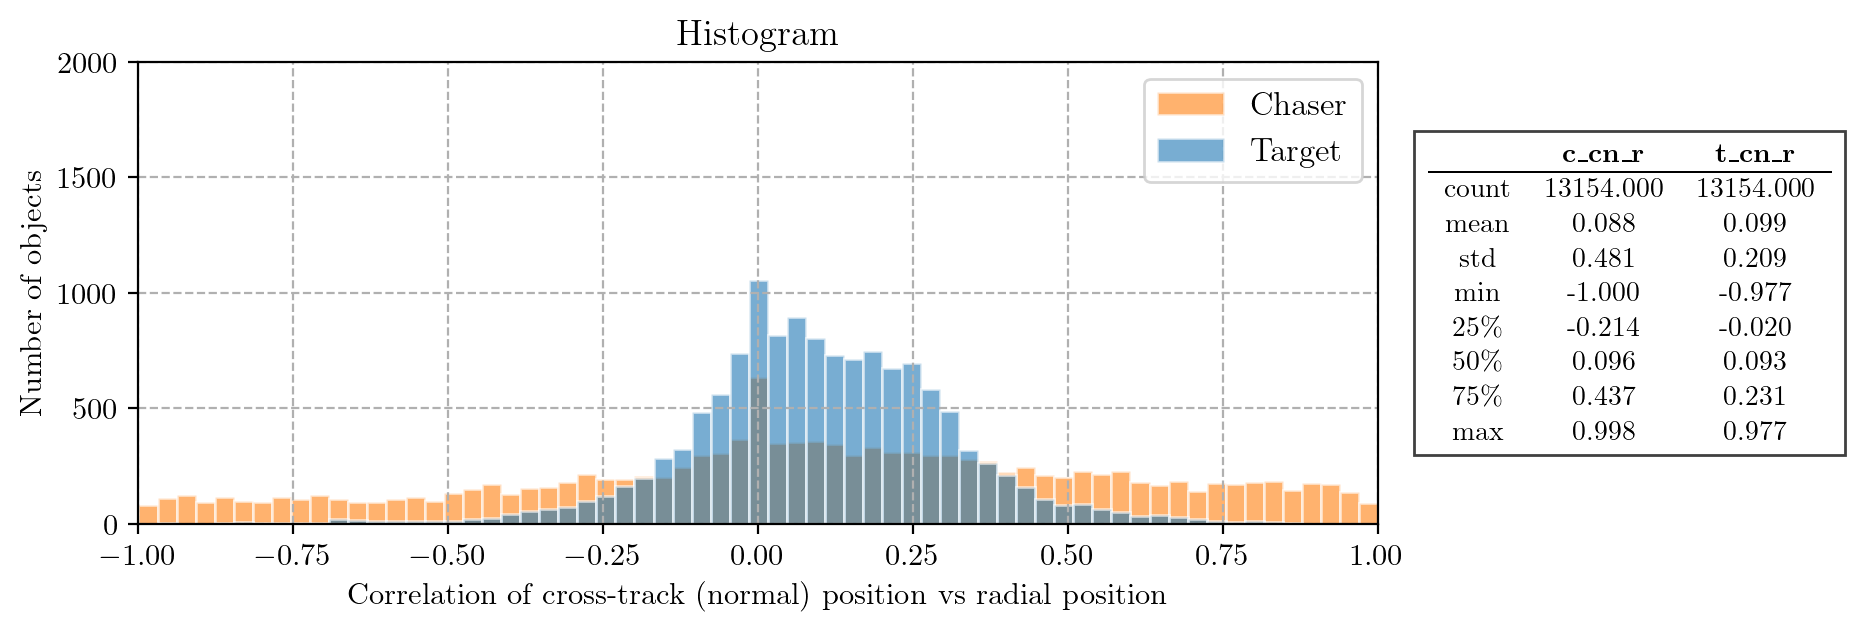

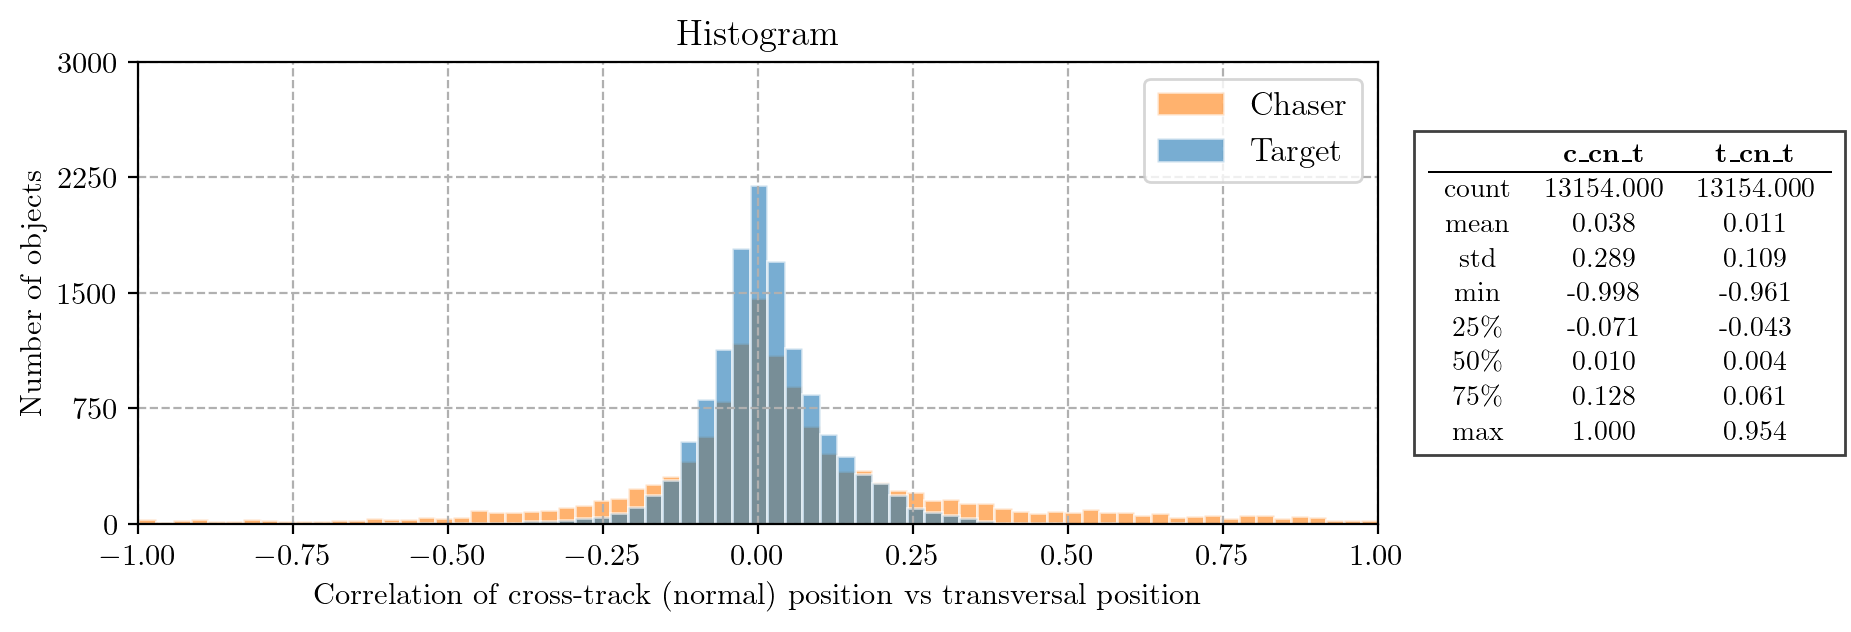

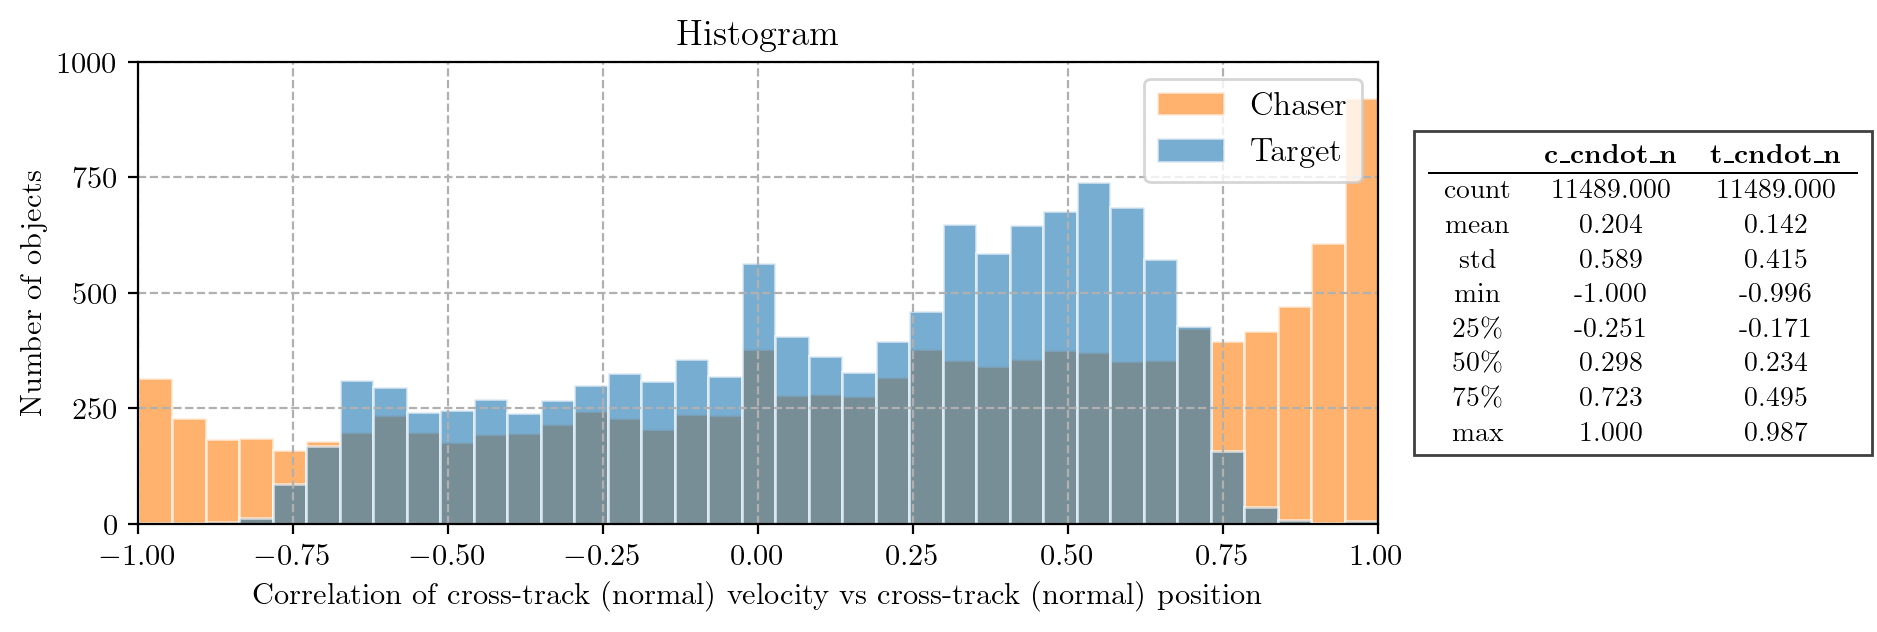

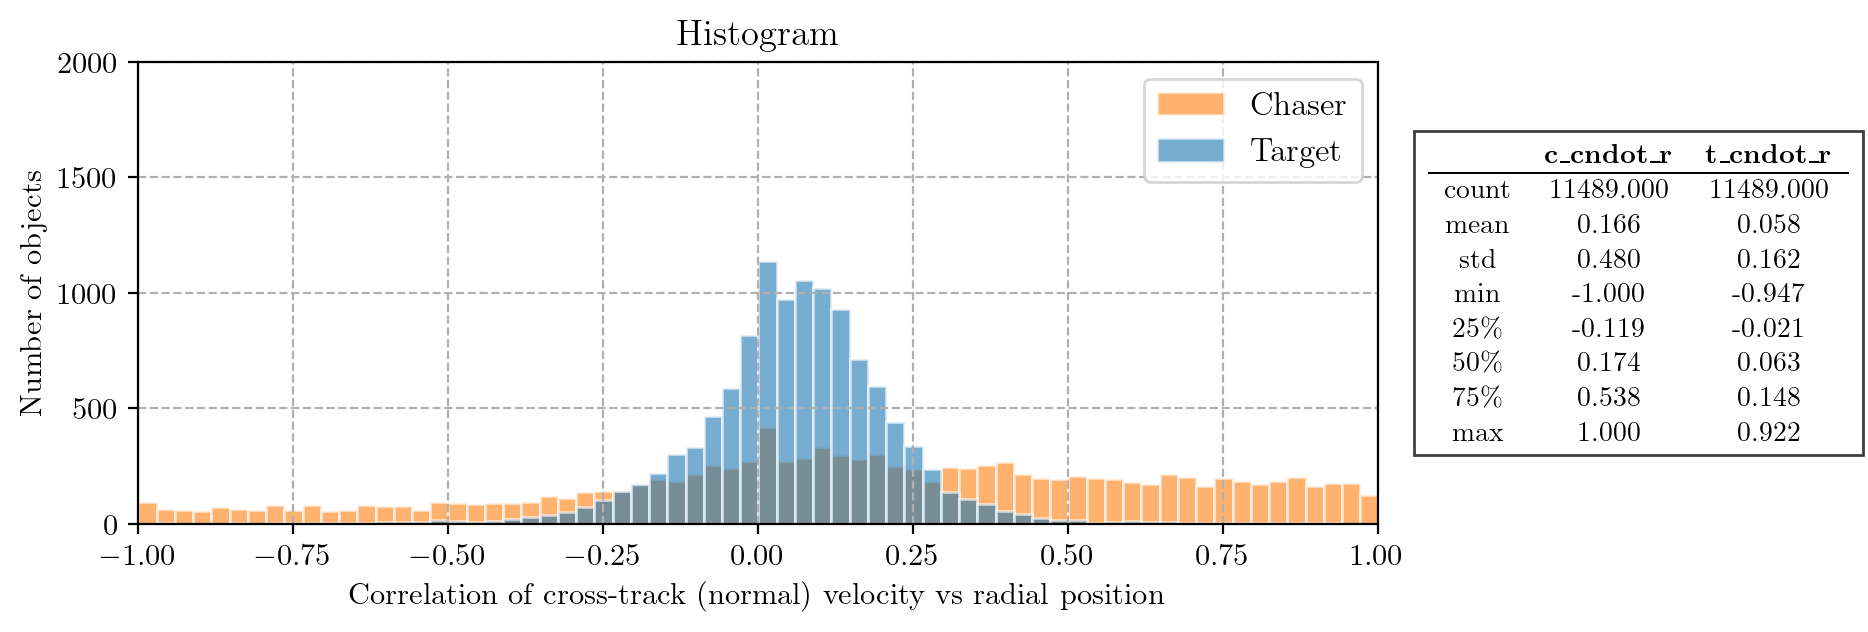

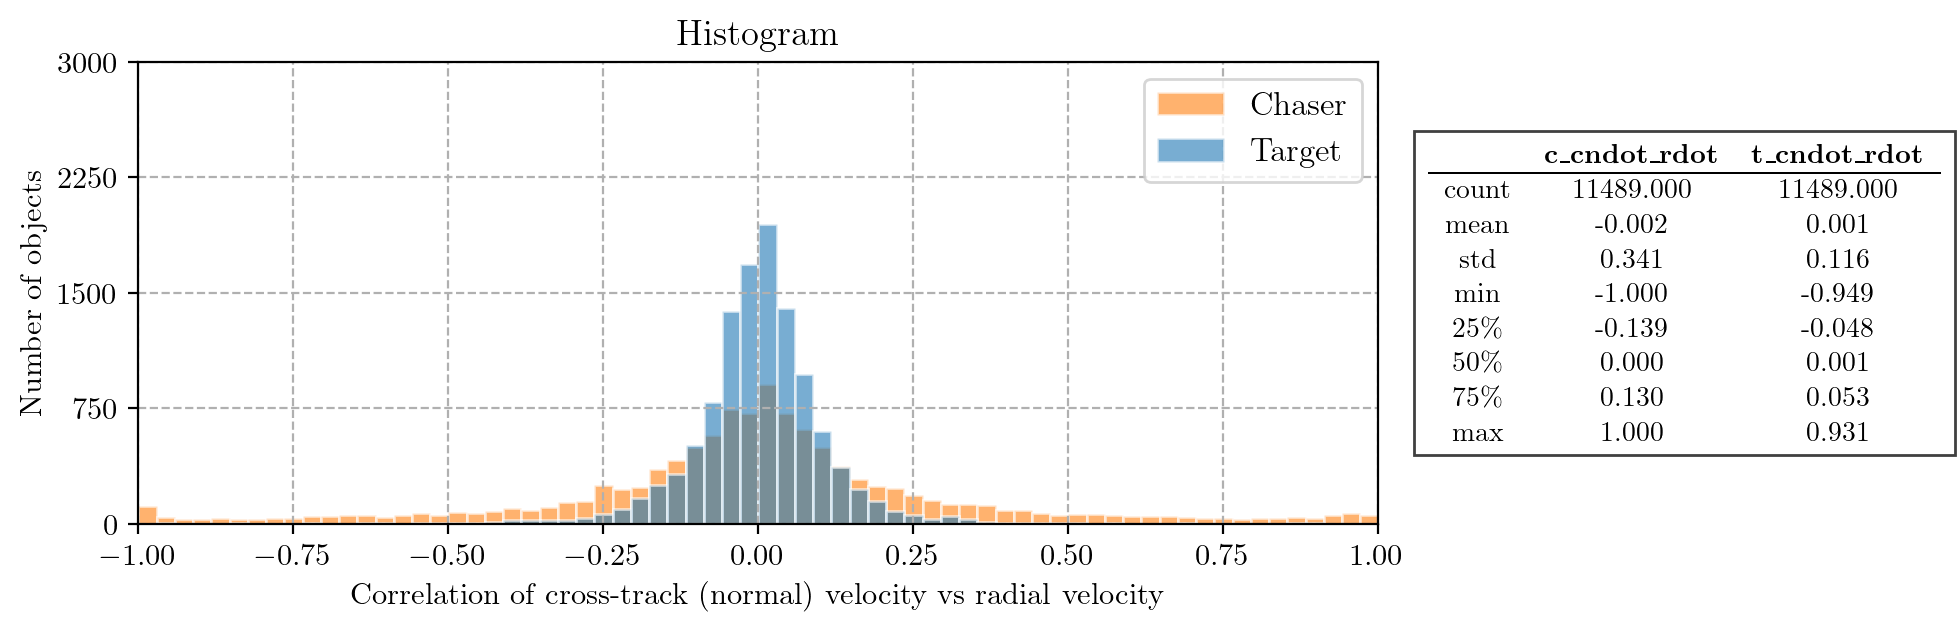

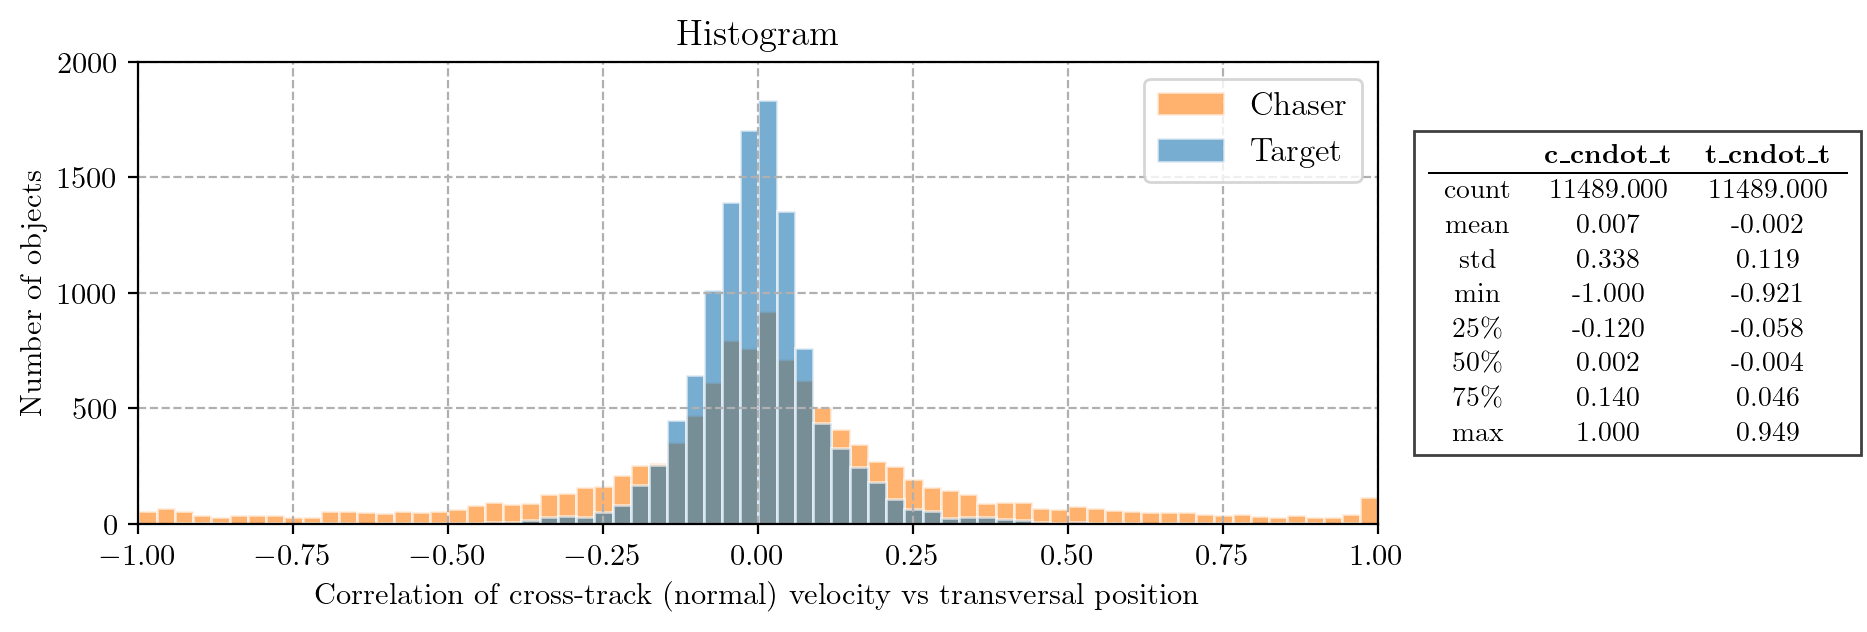

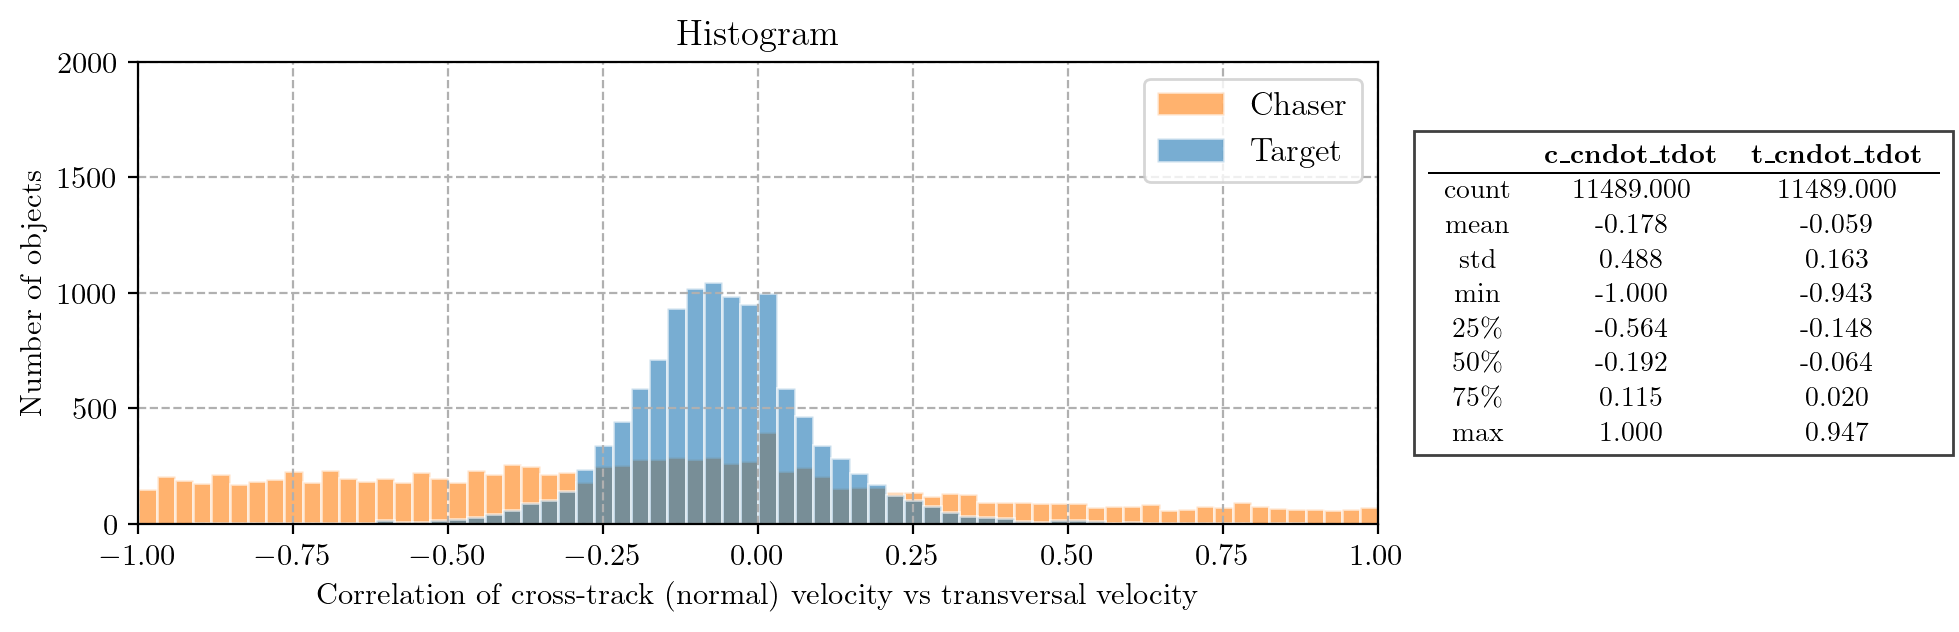

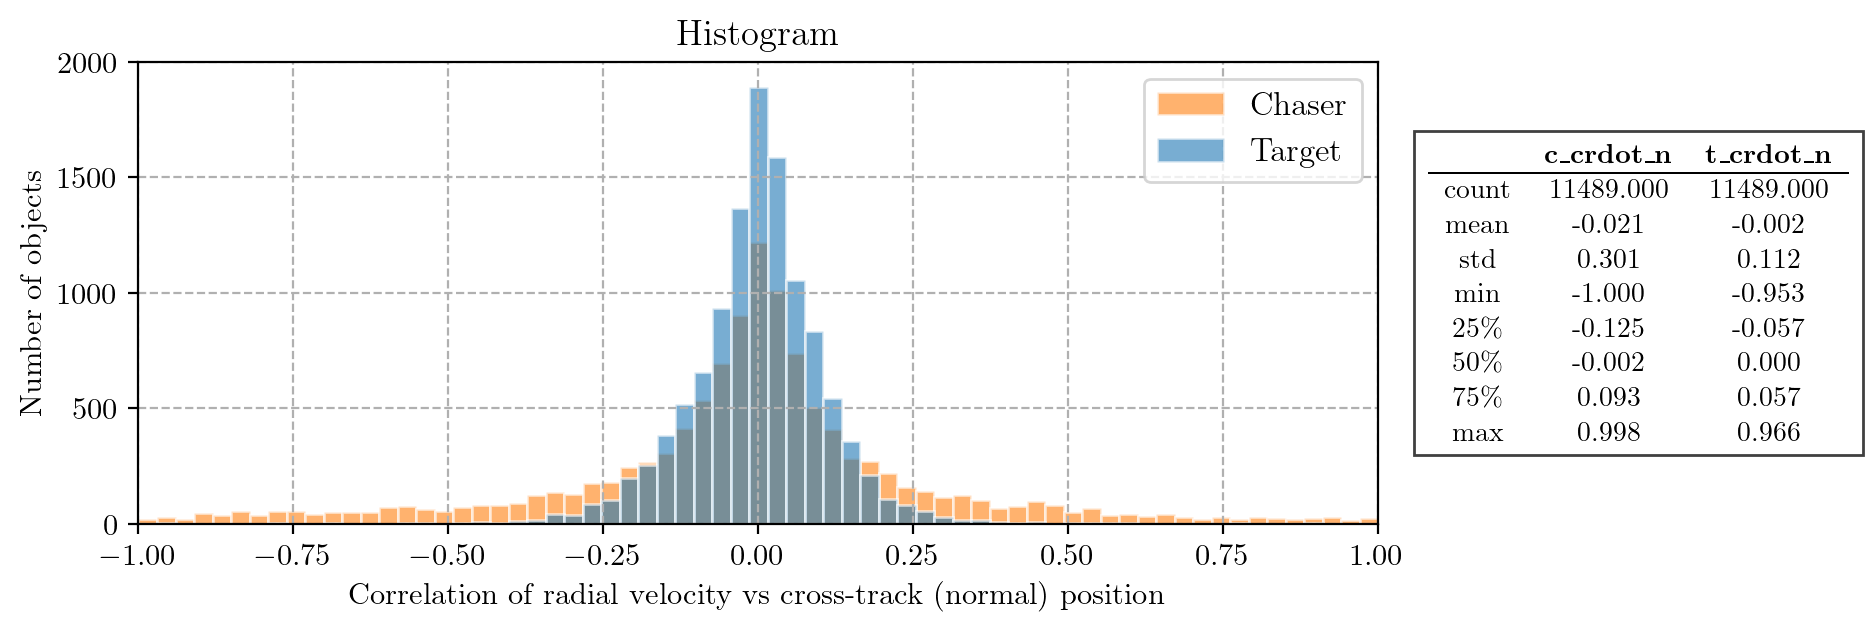

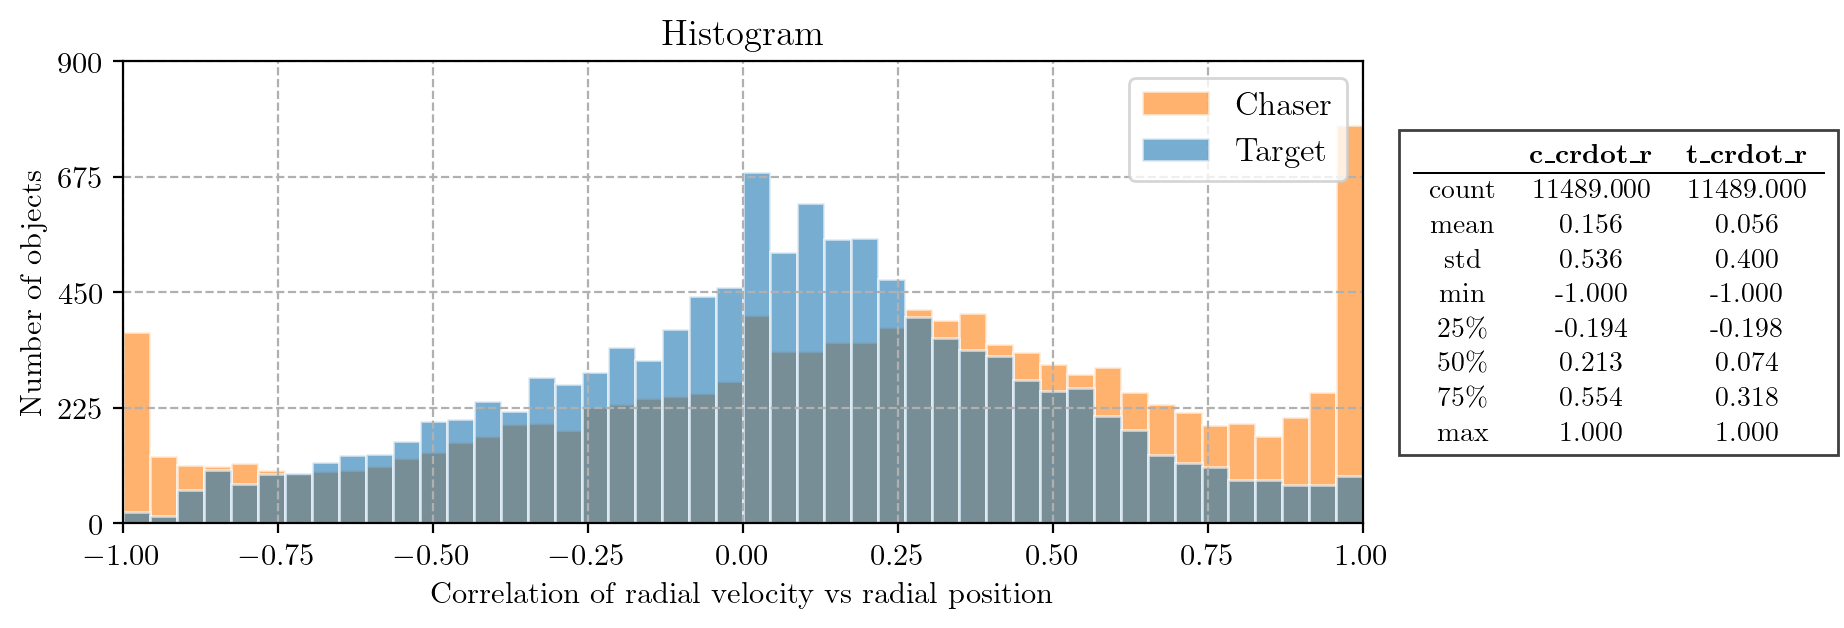

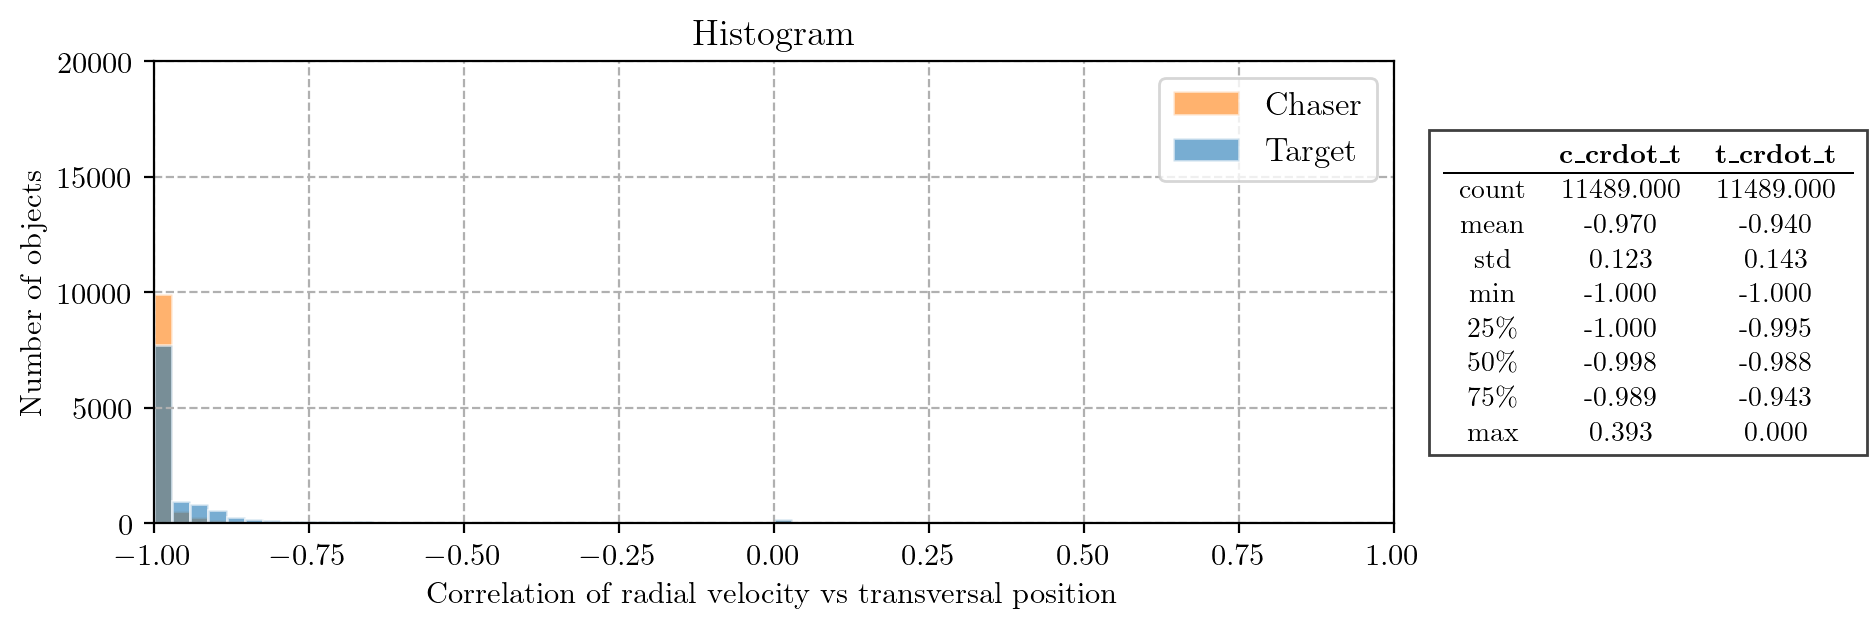

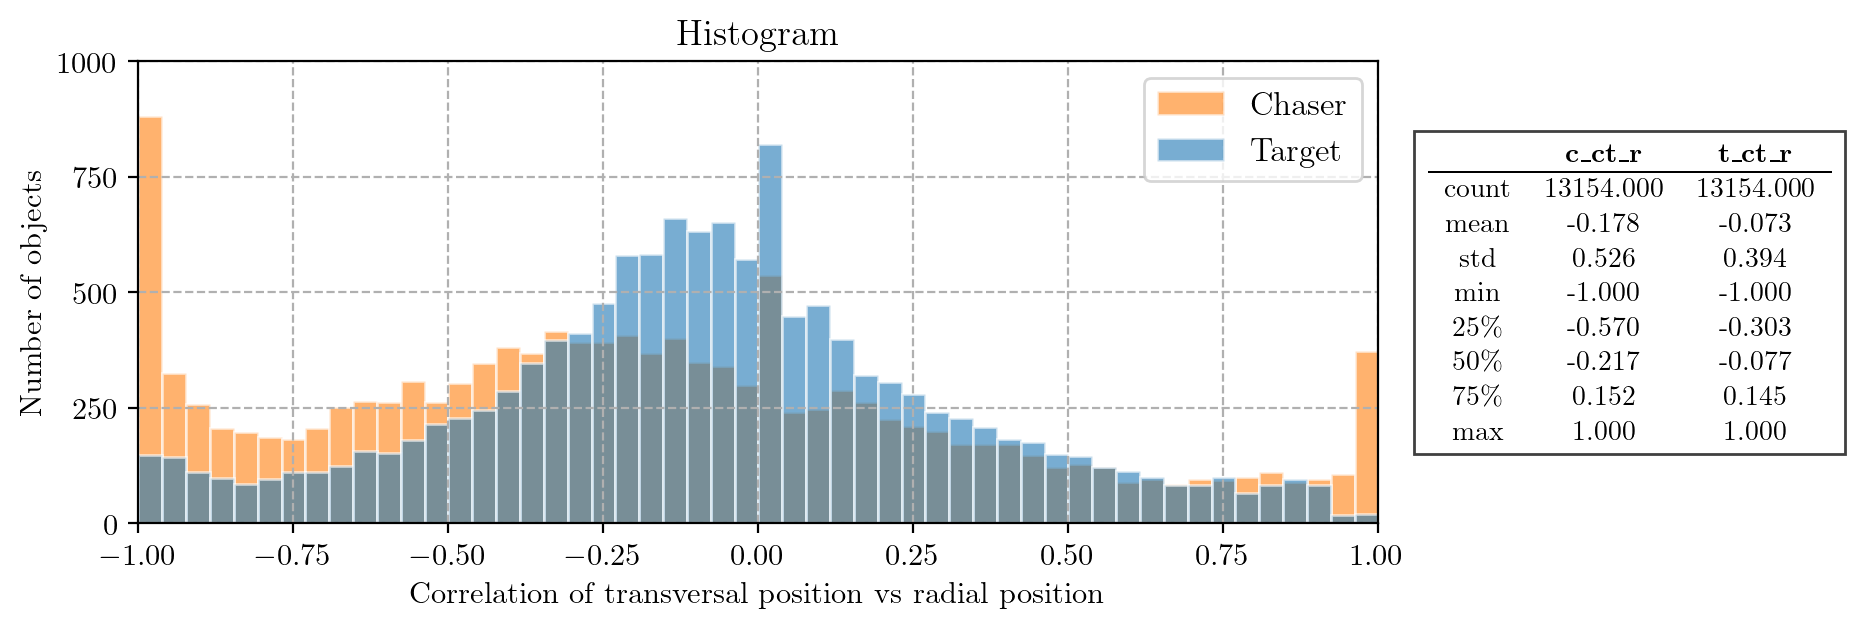

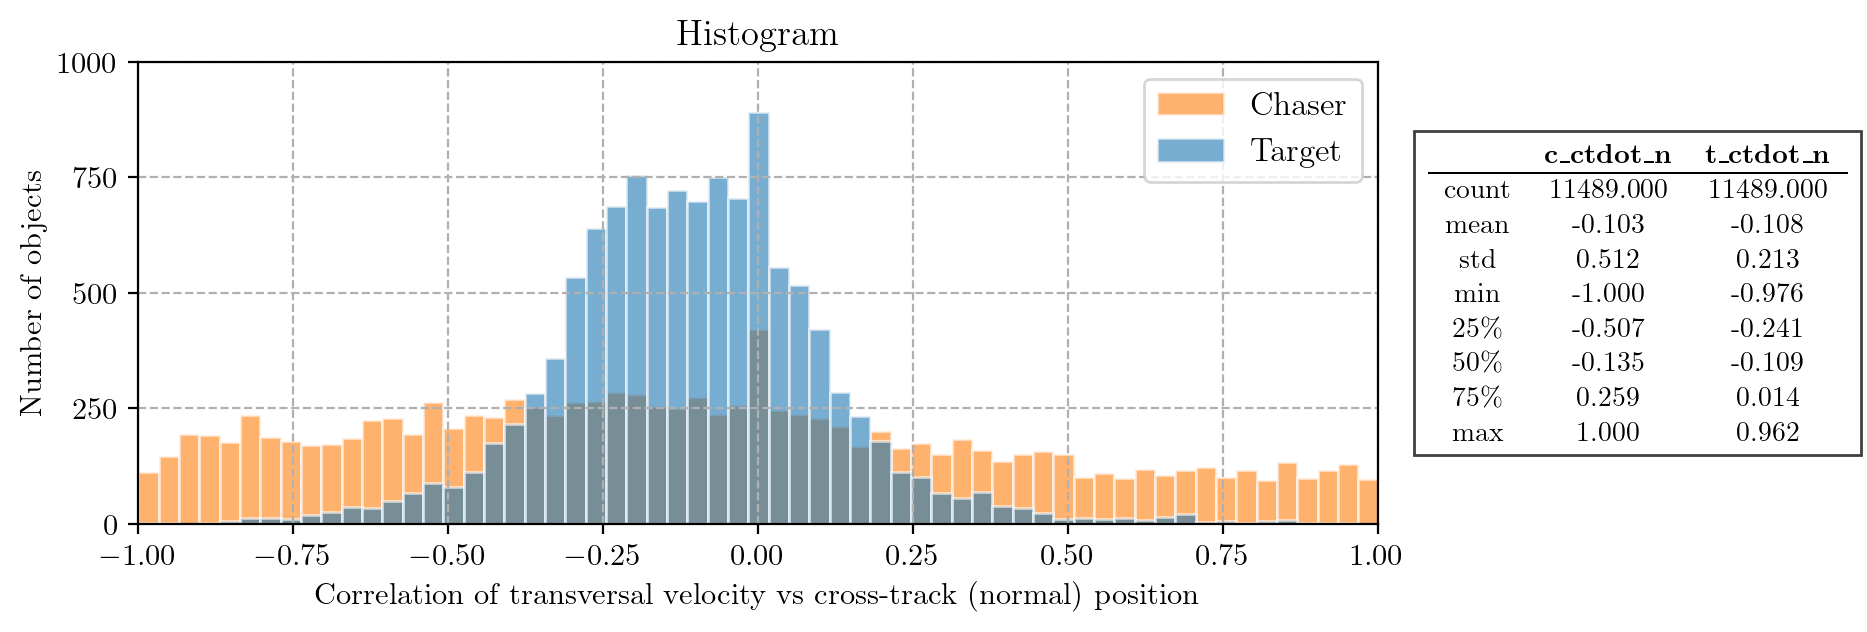

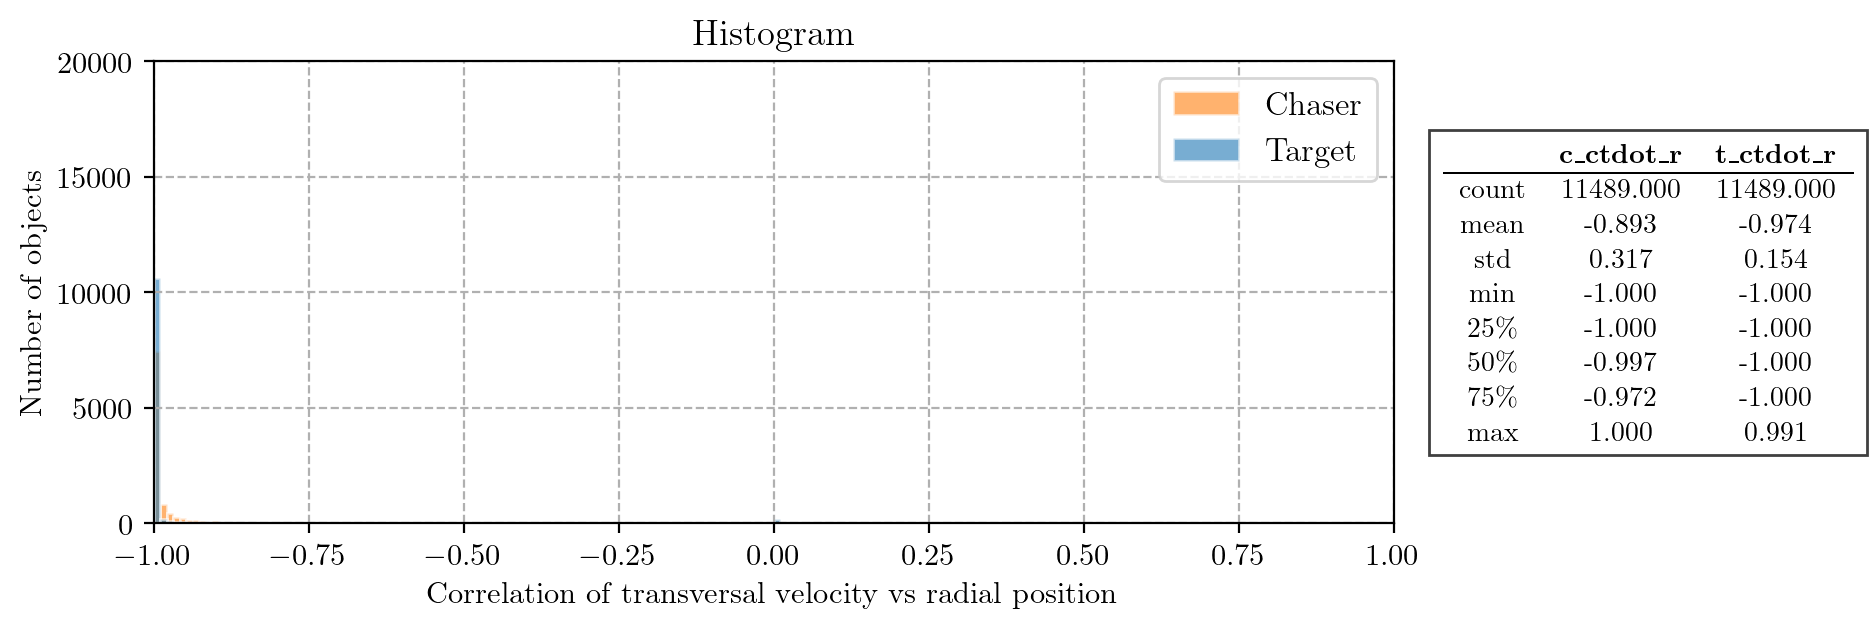

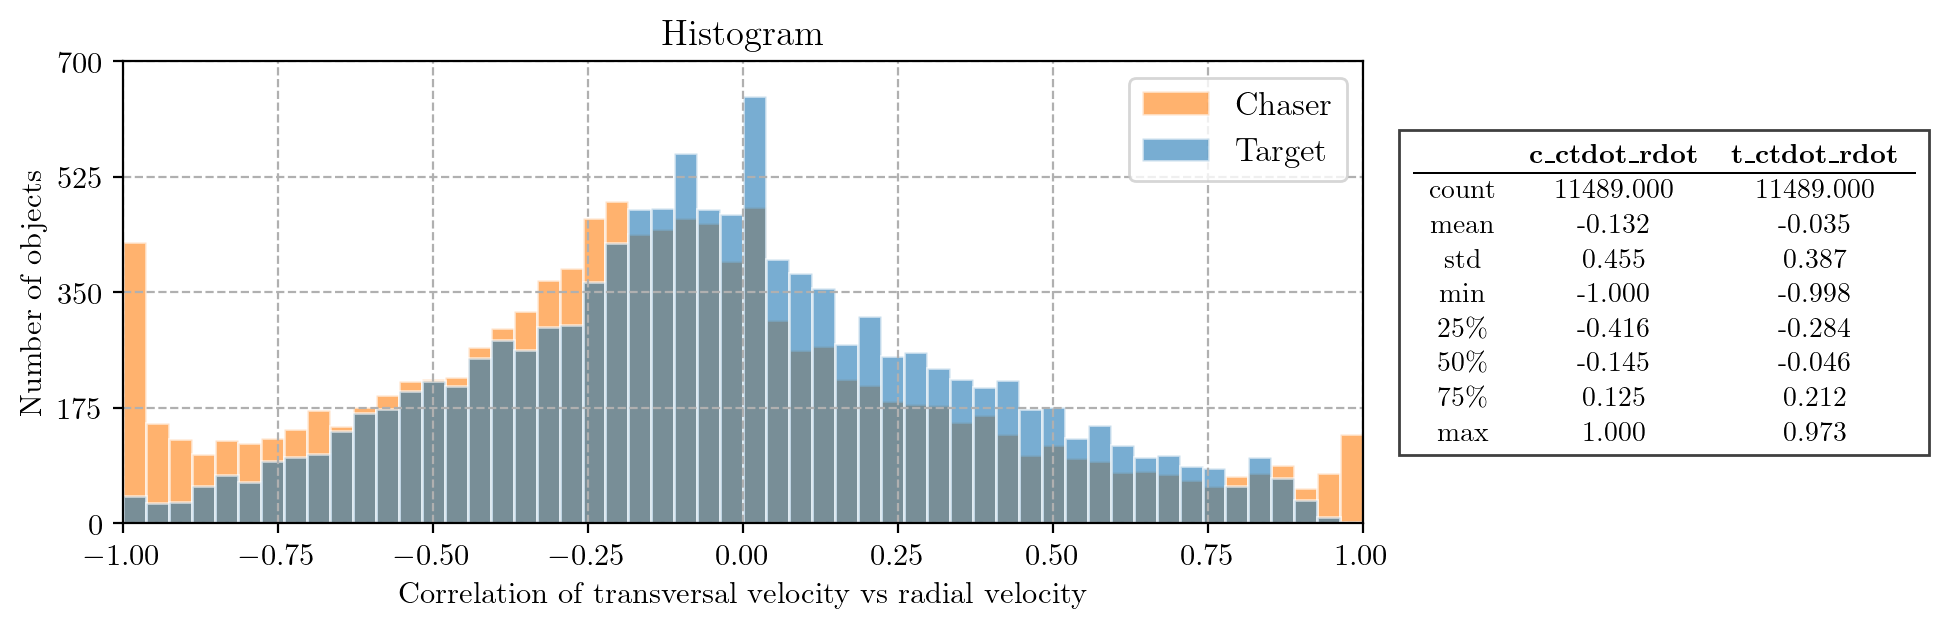

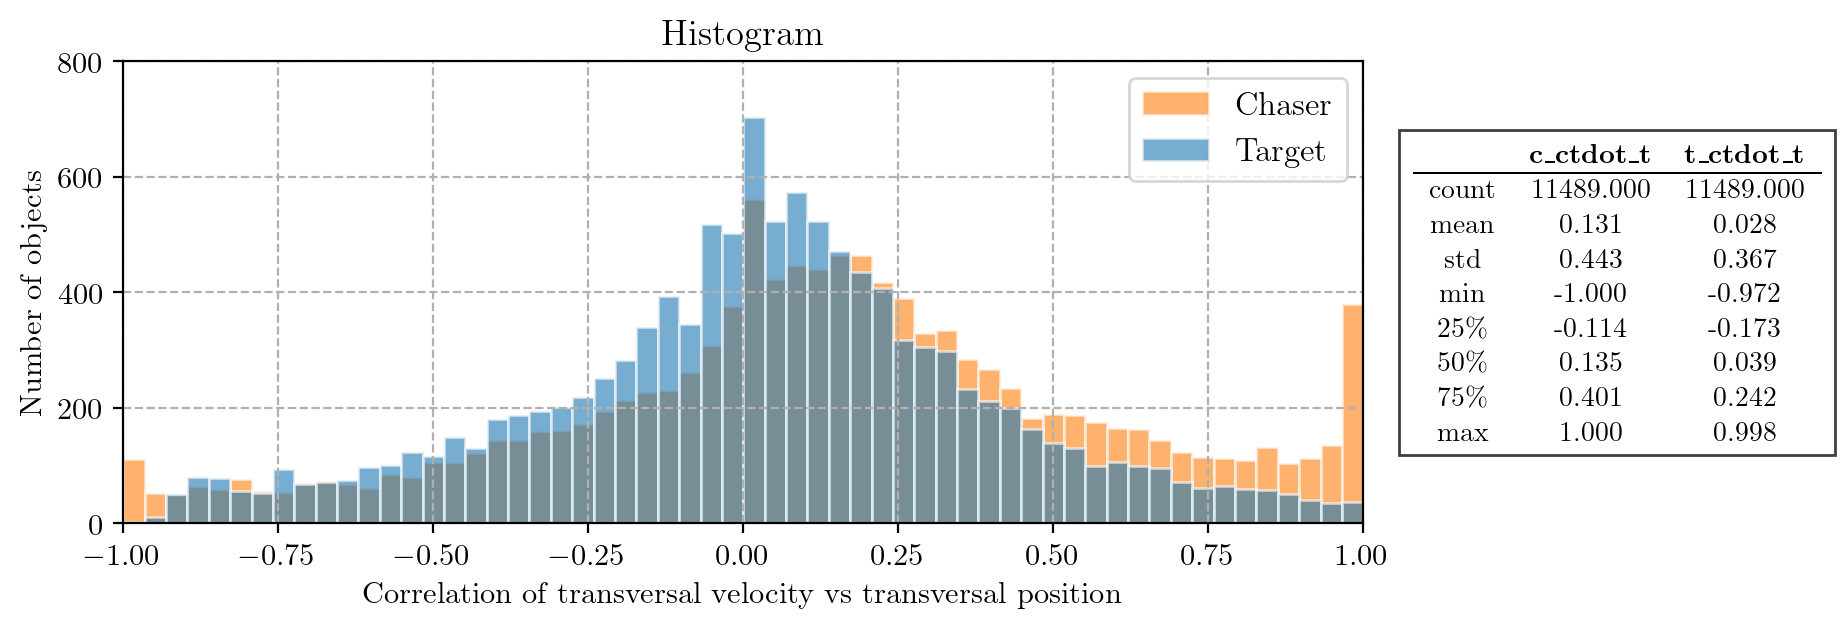

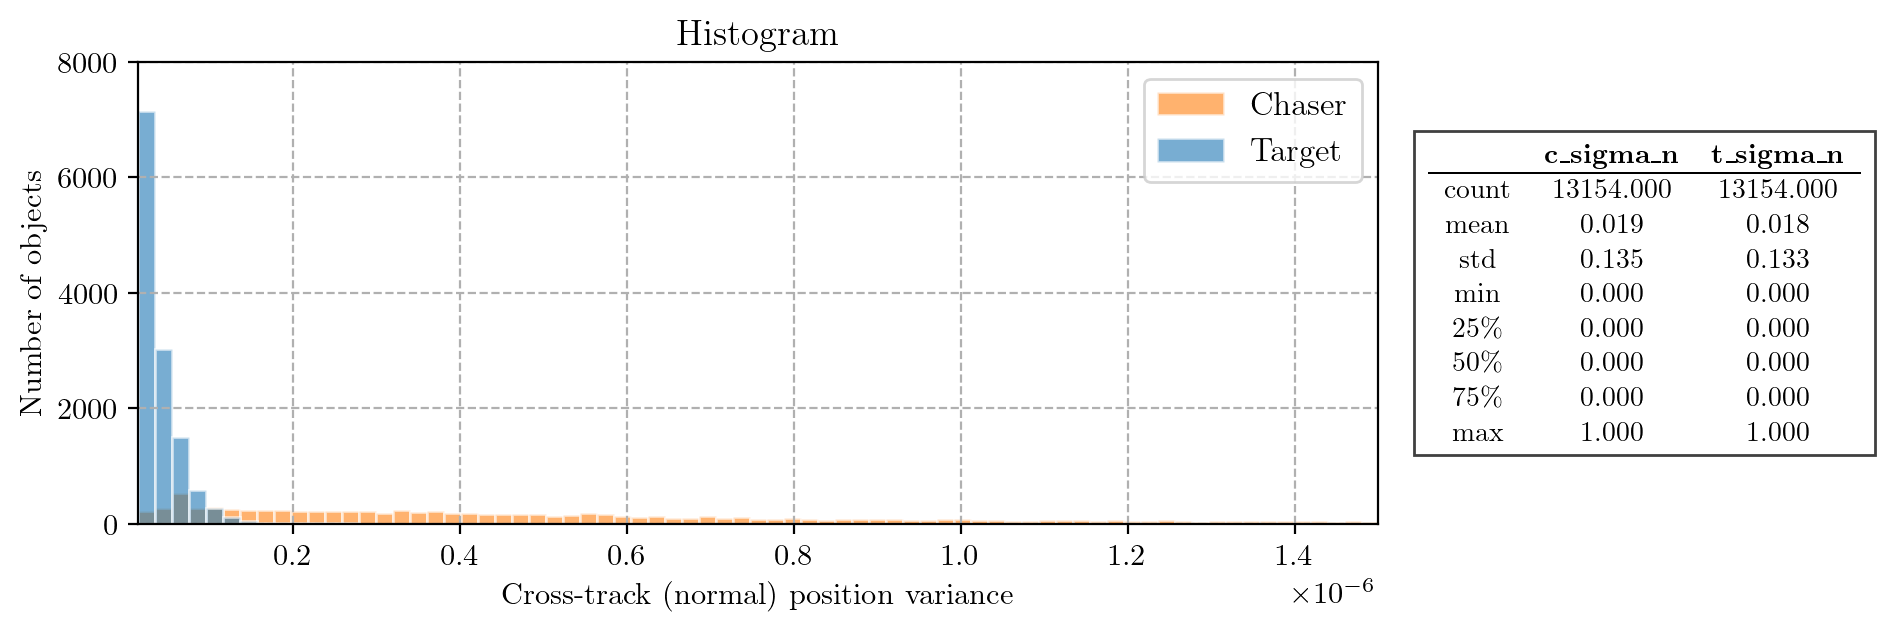

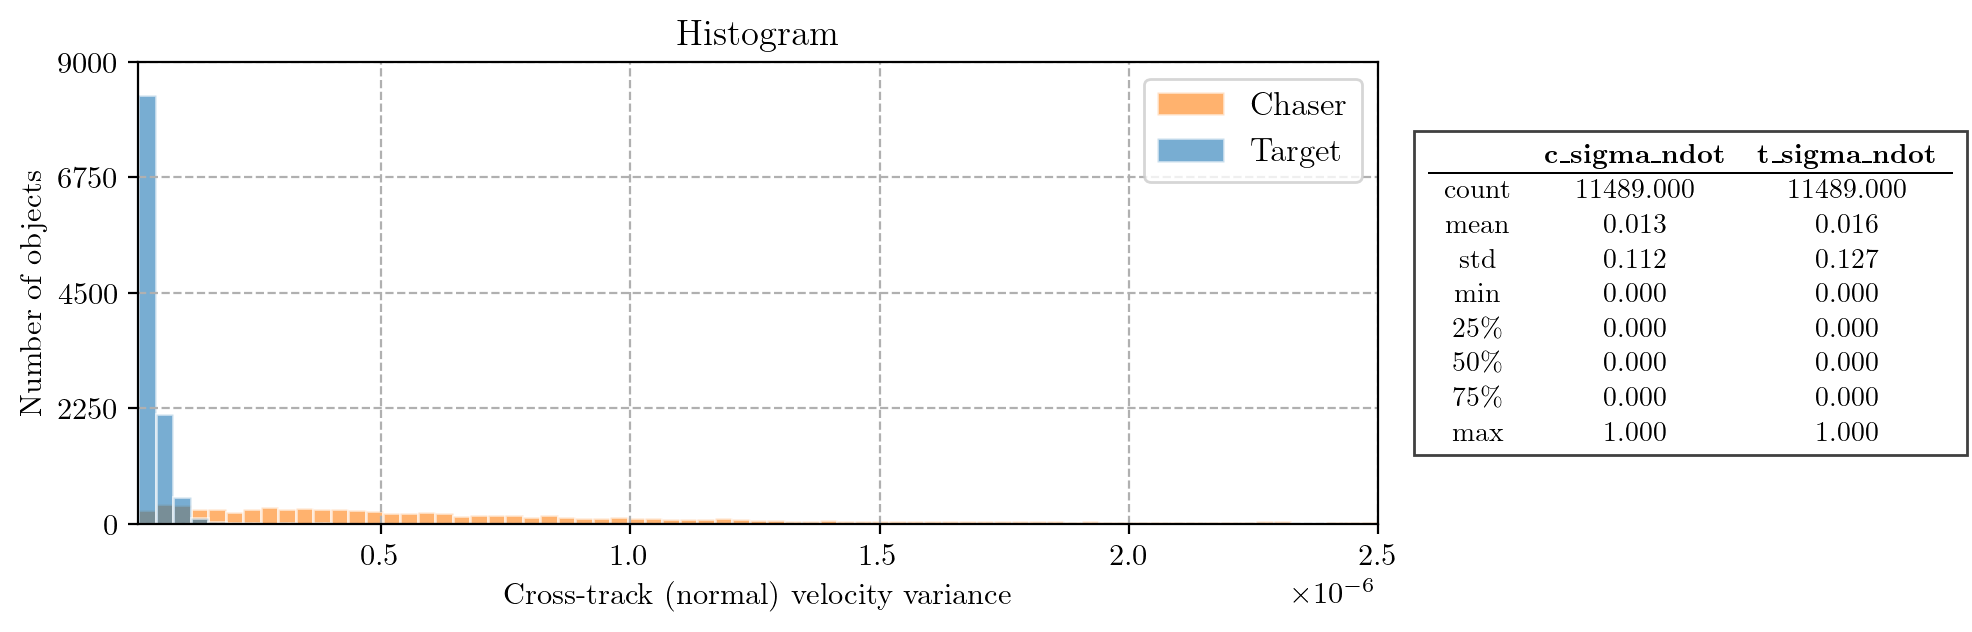

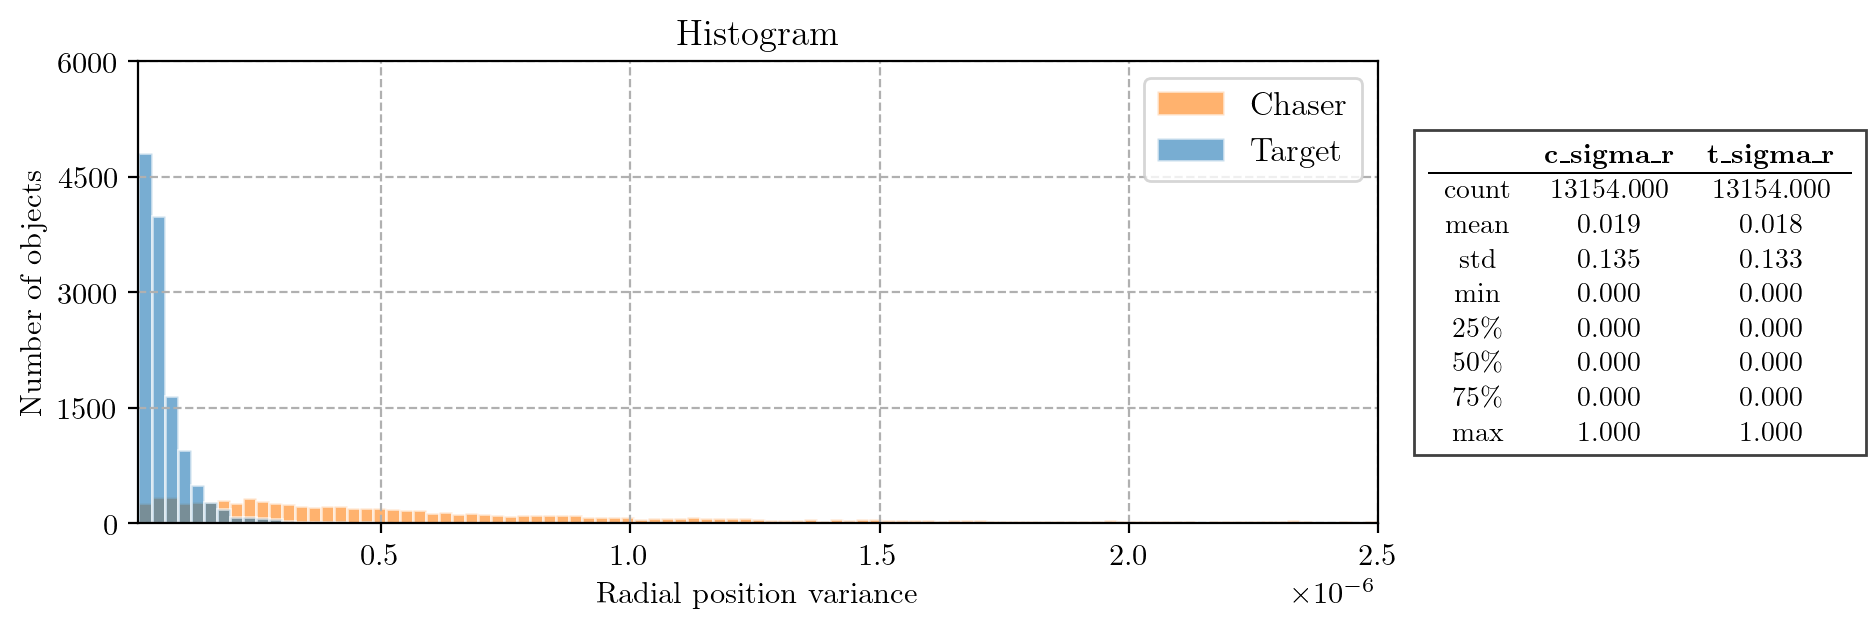

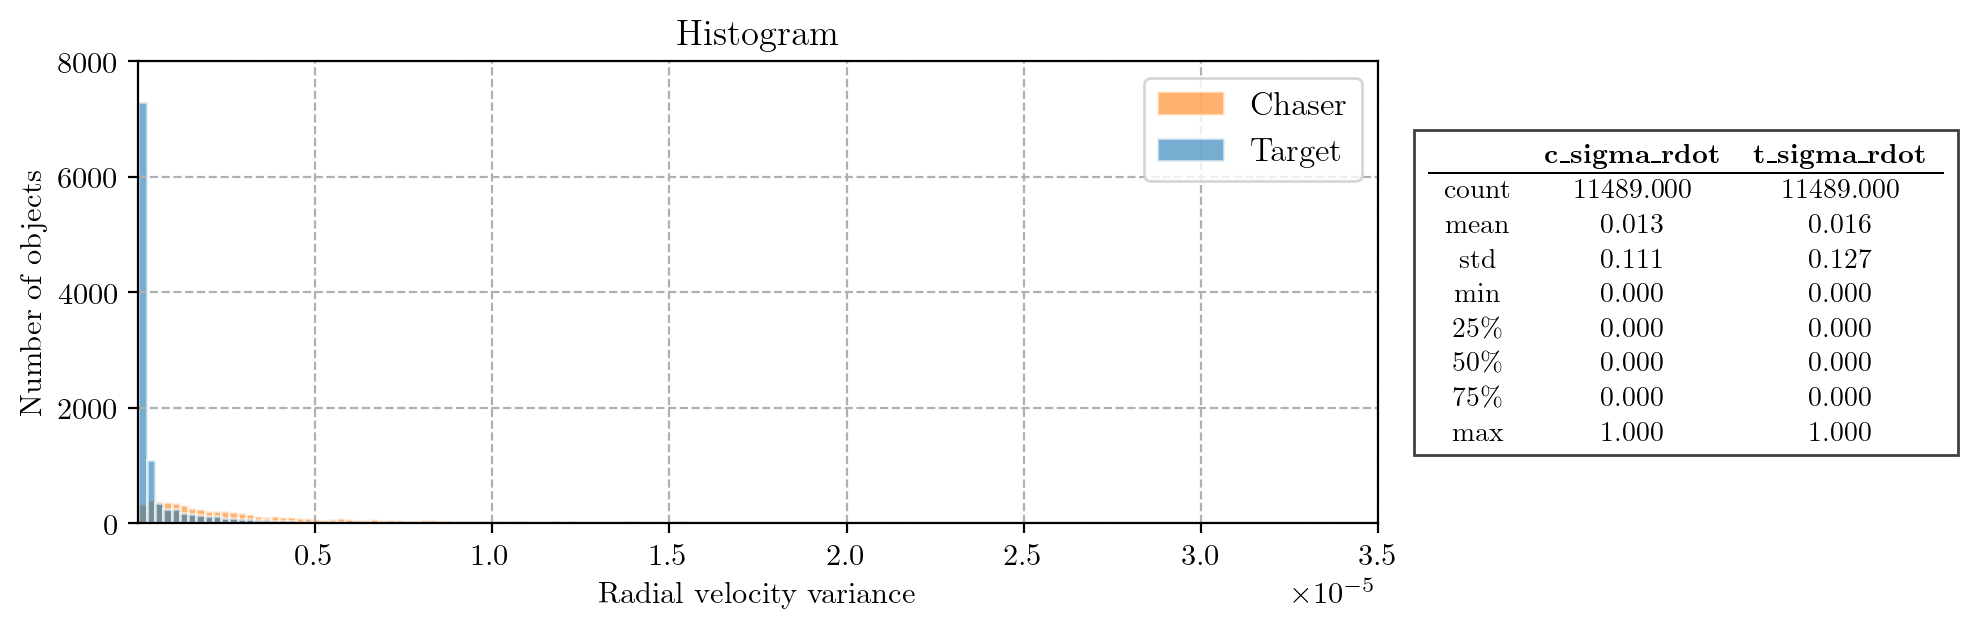

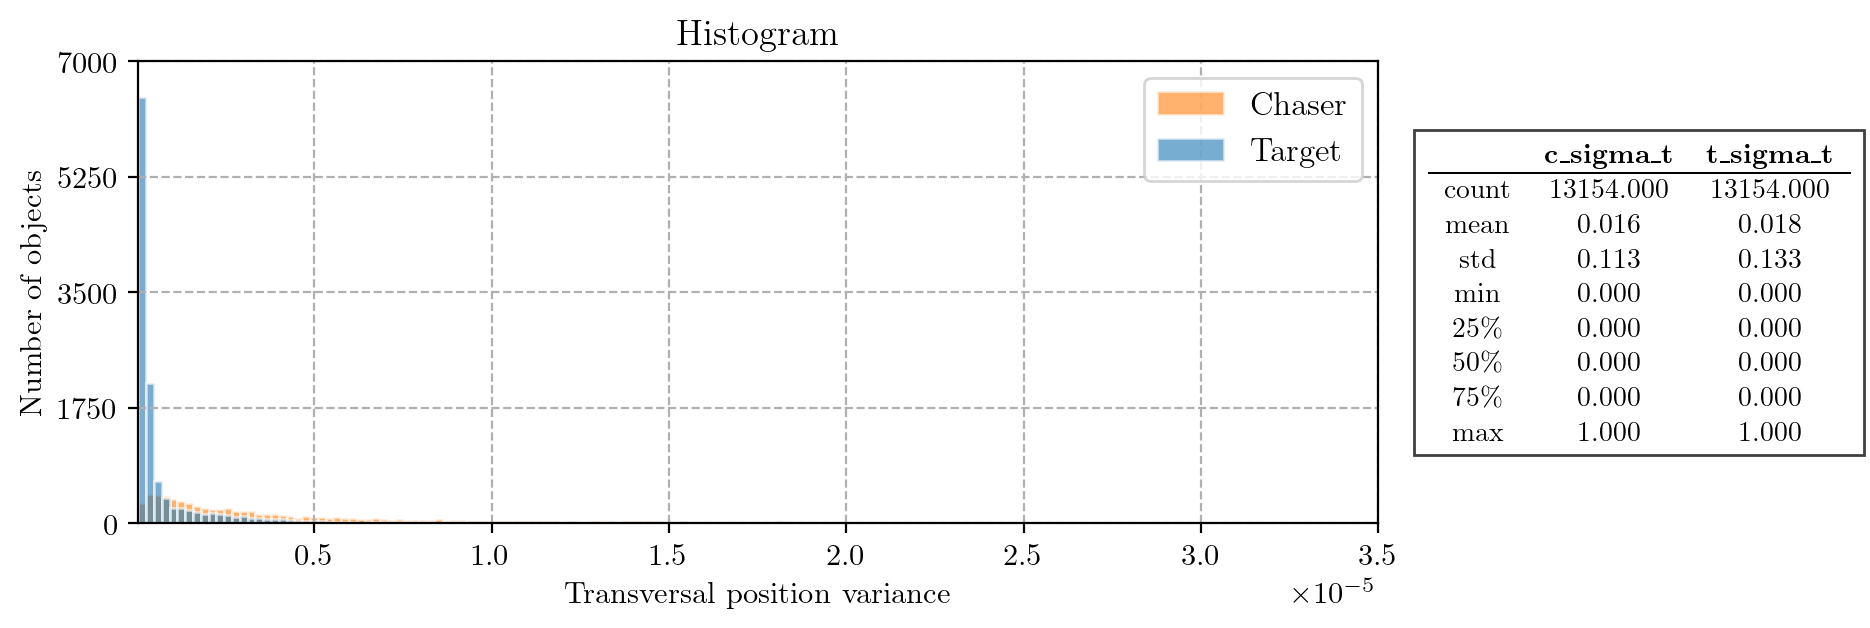

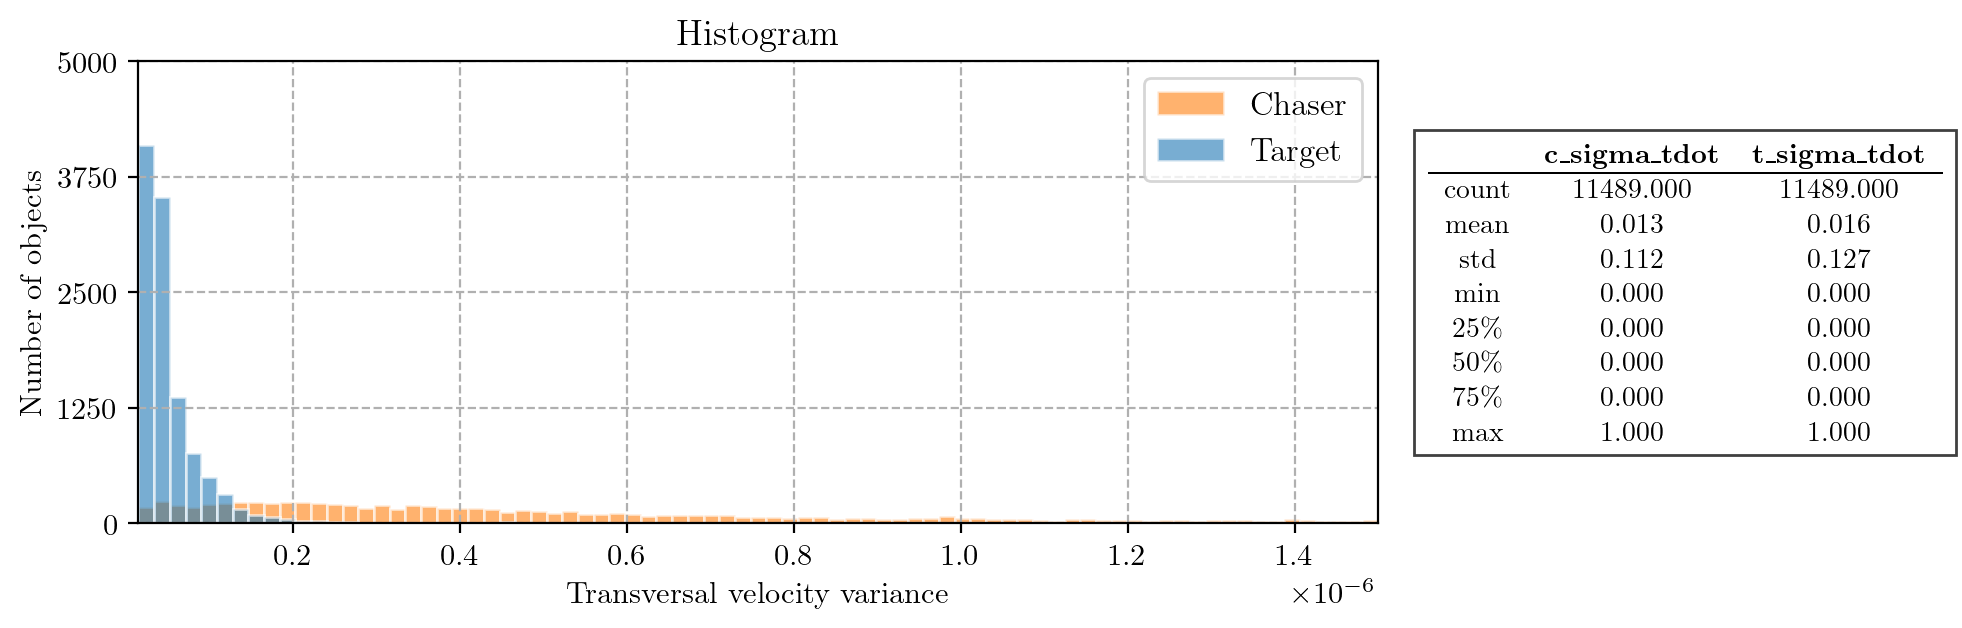

In [16]:
# Create reference frame dictionary to label charts
ref_frame ={'t': 'transversal', 'r': 'radial', 'n': 'cross-track (normal)'}

# Plot data distribution for elements below the main diagonal of the covariance matrix
for column in [c[2:] for c in column_clusters['target']['cov'] if c[2:].split('_')[0][0]=='c']:

    terms = column.split('_')[:2]
    
    xlabel = 'Correlation of ' + (ref_frame[terms[0][1]] if terms[0][1] in ref_frame.keys() else '') + \
             (' velocity' if terms[0][-3:]=='dot' else ' position') + ' vs ' + \
             ref_frame[terms[1][0]] + (' velocity' if terms[1][-3:]=='dot' else ' position')
    
    kwargs = {'xlabel': xlabel.capitalize(), 'xlim': (-1, 1), 'describe': True}
    plot_object_hist(df_lastCDM, column, bins_rule='fd', **kwargs)
    
    
# Plot data distribution for the variance from the state vector covariance matrix (main diagonal)
for column in [c[2:] for c in column_clusters['target']['cov'] if c[2:].split('_')[0]=='sigma']:

    xlabel = (ref_frame[column.split('_')[1][0]] + \
             (' velocity' if column.split('_')[1][-3:]=='dot' else ' position') + ' variance').capitalize()

    kwargs = {'xlabel': xlabel, 'describe': True, 'normalize': True}
    plot_object_hist(df_lastCDM, column, bins_rule='fd', **kwargs)
    

##### Conclusions
 * Covariance data for Targets follow a bell shaped distribution as opposed to Chasers. This feature makes it easier the reproducibility of the data distribution using well-known Probability Density Estimation methods.
 * Variances (main diagonal elements) are highly correlated to the rest of the terms of the covariance matrix for both objects. Therefore they are disregarded from the SCDMG process.

# 3. - Synthetic CDM Generation (SCDMG) using Probability Density Estimation techniques 

[Introduction to Probability Density Estimation](https://machinelearningmastery.com/probability-density-estimation/)

From a statistical perspective, the best way to generate additional synthetic data that reliably mirrors the real data distribution is by analysing and estimating its probability density, that is, to understand how likely is to get a value from a continuous variable. Two techniques to estimate the Probability Density of all data distributions are used in the present EDA:

 - **Parametric**: the statistical distribution of the real data is described by an analytical and well-known statistical probability distribution by estimating the parameters implicit in the function. In this approach, a function is defined to find the statistical distribution that best fits the real data distribution of all existing continuous distributions available in [SciPy.org](https://docs.scipy.org/doc/scipy/reference/stats.html). The use of this method is limited to unimodal data distributions or data distributions with simple profiles.
 
 - **Non-parametric**: alternative method when the data distribution cannot be appropriately described analytically by a common probability distribution or cannot be easily made to fit the distribution (as it happens with multi-modal distributions). Among the multiple non-parametric methods available for Probability Density Estimation, the method used for estimating the probability density function of a continuous random variable in this analysis is the so-called *Kernel Density Estimation* (KDE). In particular the `KernelDensity` estimator from [Scikit-learn.org](https://scikit-learn.org/stable/modules/density.html) is used. More information on how this is done can be found in the following two articles:
 
     - [Histograms and KDE by Michael Lerner](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28)
     - [Kernel Density Estimation in Python by Jake VanderPlas](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/)
 
The analysis developed in Section 2 on the different clusters data distributions supports the identification of those continuous variables that can be described using the parametric approach and those to be defined by the non-parametric one.


In [17]:
# Get variables to be described with the non-parametric approach
non_parametric = {"conjunction": ["time_to_tca", "risk", "azimuth", "F3M", "SSN", "AP"],
                "target": {
                    "coeff": column_clusters['target']['coeff'],
                    "orb_elements": column_clusters['target']['orb_elements'],
                    "cov": ["t_cndot_t"]},
                "chaser": {
                    "coeff": column_clusters['chaser']['coeff'],
                    "orb_elements": column_clusters['chaser']['orb_elements'],
                    "cov": ["c_cn_r", "c_cndot_n", "c_cndot_r", "c_cndot_tdot", "c_crdot_r",
                            "c_ct_r", "c_ctdot_n", "c_ctdot_r", "c_ctdot_rdot"]}
                }


# Get variables to be described with the parametric approach
parametric = {key: [i for i in value if not i in non_parametric[key]] 
                          for key, value in column_clusters.items() 
                          if not key in ['ids', 'relative_state', 'target', 'chaser']}

for obj in ['target', 'chaser']:
    
    parametric[obj] = {key: [i for i in value if not i in non_parametric[obj][key]] 
                            for key, value in column_clusters[obj].items() if not key=='misc'}
    
# print(format_json(parametric))
# print(format_json(non_parametric))


### 3.1. - Parametric Probability Density Estimation

The first approach to be considered when generating synthetic data is the parametric as it provides an excellent compromise between data distribution description accuracy and statistical simplicity based on assumptions about the shape of the distribution in the underlying population and about the form or parameters of the assumed distribution. However, not all populations can be accurately described using the parametric approach and a reliable but simple enough criteria for its identification must be used.

In this regard, for the purposes of this EDA, the coefficient of determination $R^2$ between the actual probability density and the estimated one is the parameter that determines whether a feature can be described using the parametric method. That is, those features for which the $R^2$ score between its actual and estimated probability density from an analytical statistical model is above a certain threshold (usually $R^2 \geq 0.95$) is considered a good enogh to be used to produce synthetic data.

In order to identify what SciPy statistical model describes better the data distribution the following user defined functions and classes (UDF / UDC) are created:
 - `find_best_distribution`: UDF that iterates through all available statistical functions in SciPy and chooses the best according to the coefficient of determination (R2 score) vs the real data distribution probability density.
 - `plot_scipy_pdf`: UDF that plots the histogram and PDF function in terms of probability density for visual comparison. 
 - `FitScipyDistribution`: UDC that instanciates a given variables with the outputs from the fitting process of a given SciPy distribution.


#### SciPy statistical distributions evaluation per feature

In order to make the fitting process to the SciPy statistical distribution on every feature in the dataset, the following UDF to import stats models ranked by $R^2$. This allows to easily re-run already evaluated features in a timely manner. 

In [18]:
def import_stdists_ranking():
    """Import satistical fitting results per feature in a DataFrame."""
    
    # Check if parametric_ranking dataset is available in the temporary folder
    filepath = os.path.join(cwd,'notebooks','nbtemp','parametric_ranking.csv')

    # Import ranking dataframe if already available
    if os.path.exists(filepath):
        ranking = pd.read_csv(filepath_or_buffer=filepath, sep=',', header='infer', 
                              index_col=0, decimal='.', encoding='utf-8')
    else:
        # Check if temp folder already exists, create new one otherwise
        if not os.path.exists(os.path.join(cwd,'notebooks','nbtemp')): 
            os.mkdir(os.path.join(cwd,'notebooks','nbtemp'))

        # Initialize ranking dataframe to evaluate best distributions per column
        ranking = pd.DataFrame(index = [dist.name for dist in scipy_distributions])

    best_dists = {}
    for column, stdist in dict(ranking.idxmax(axis='index')).items():
        best_dists[column] = {'dist': stdist, 'r2_score': ranking.loc[stdist, column]}
        
    # best_dists = dict(ranking.idxmax(axis='index'))
    
    return ranking, best_dists, filepath


#### 3.1.1. - Synthetic data generation

As described in the introduction of this Section, in the code-block below the conjunction data is evaluated using the parametric approach only if 

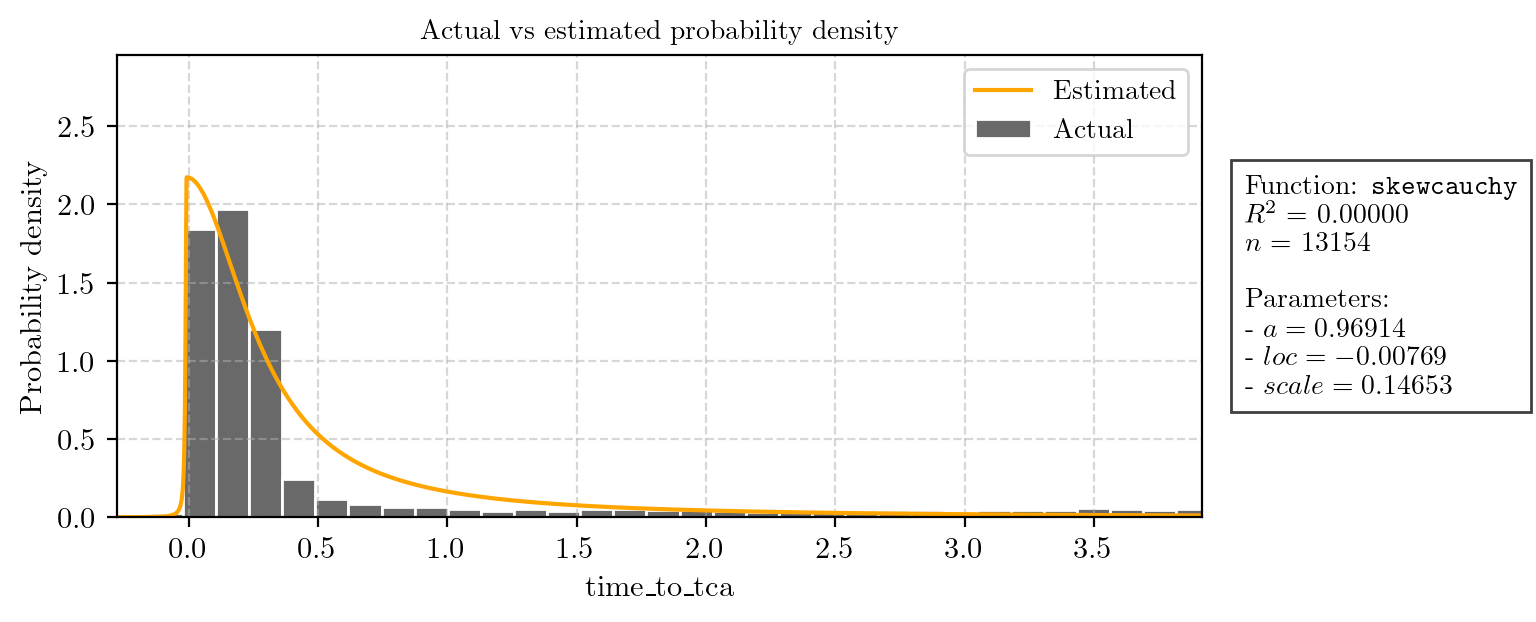

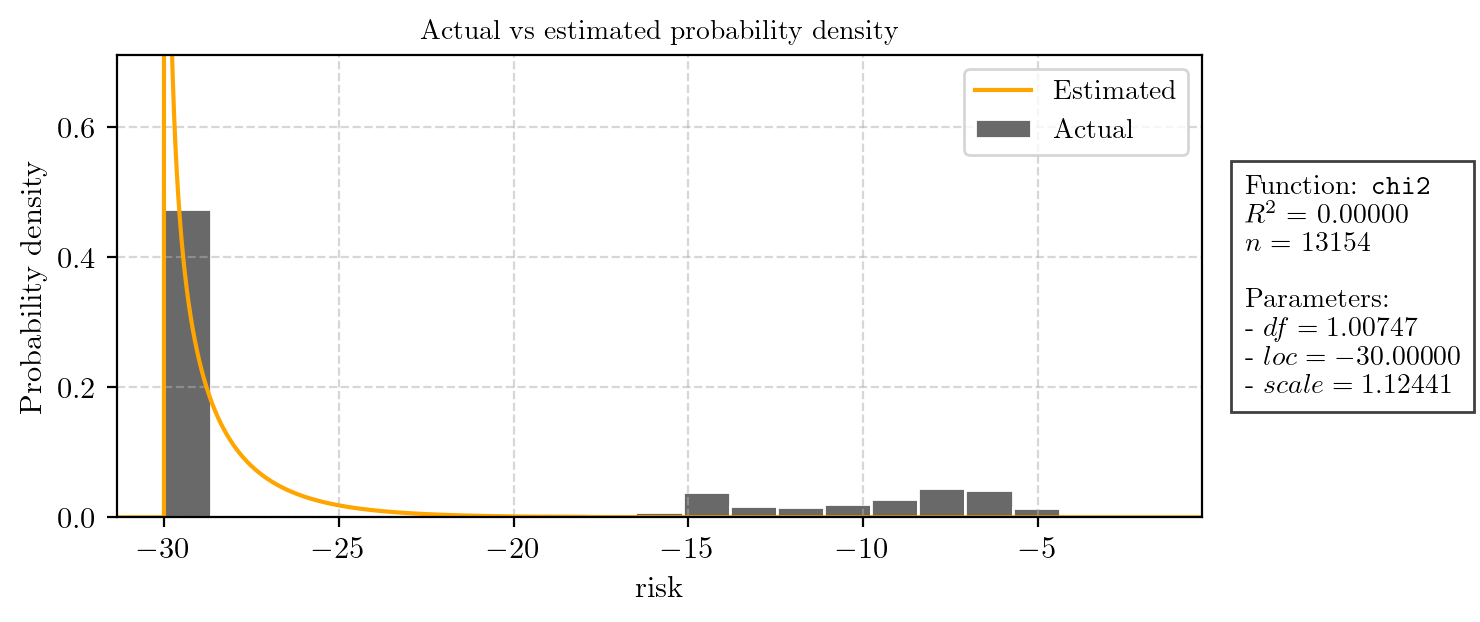

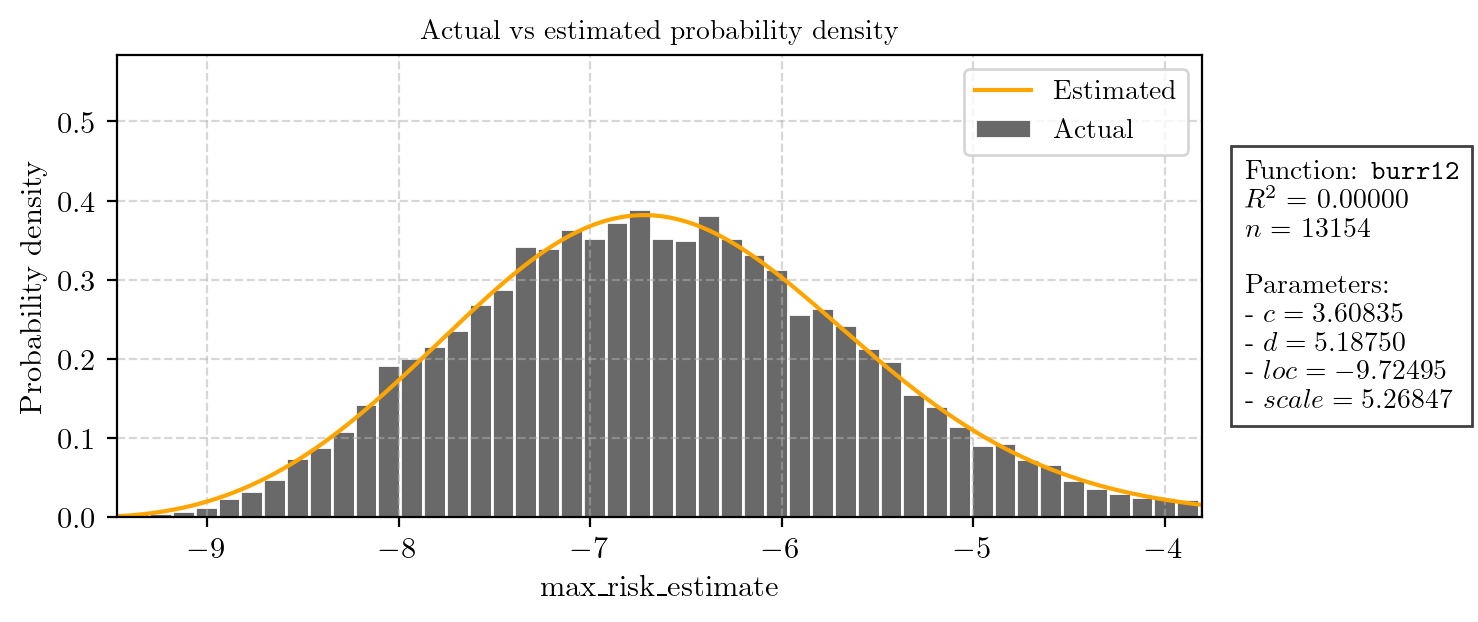

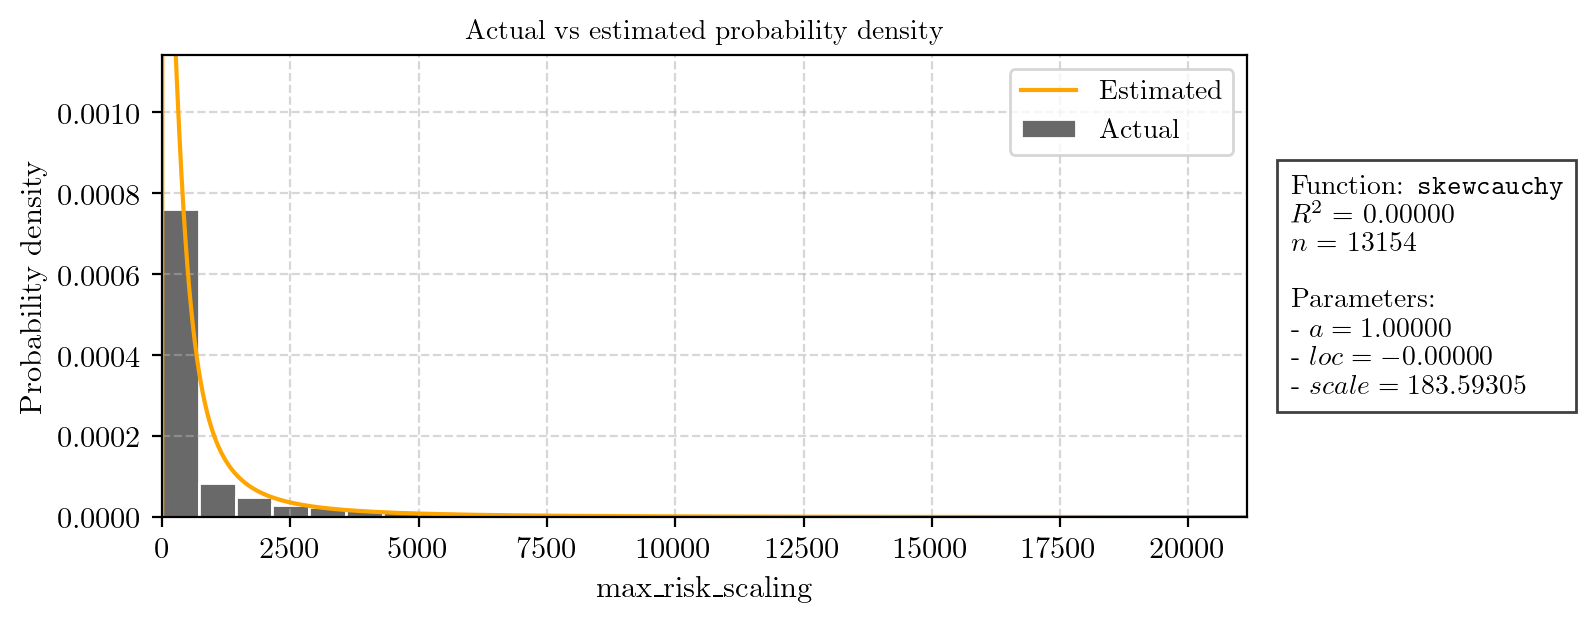

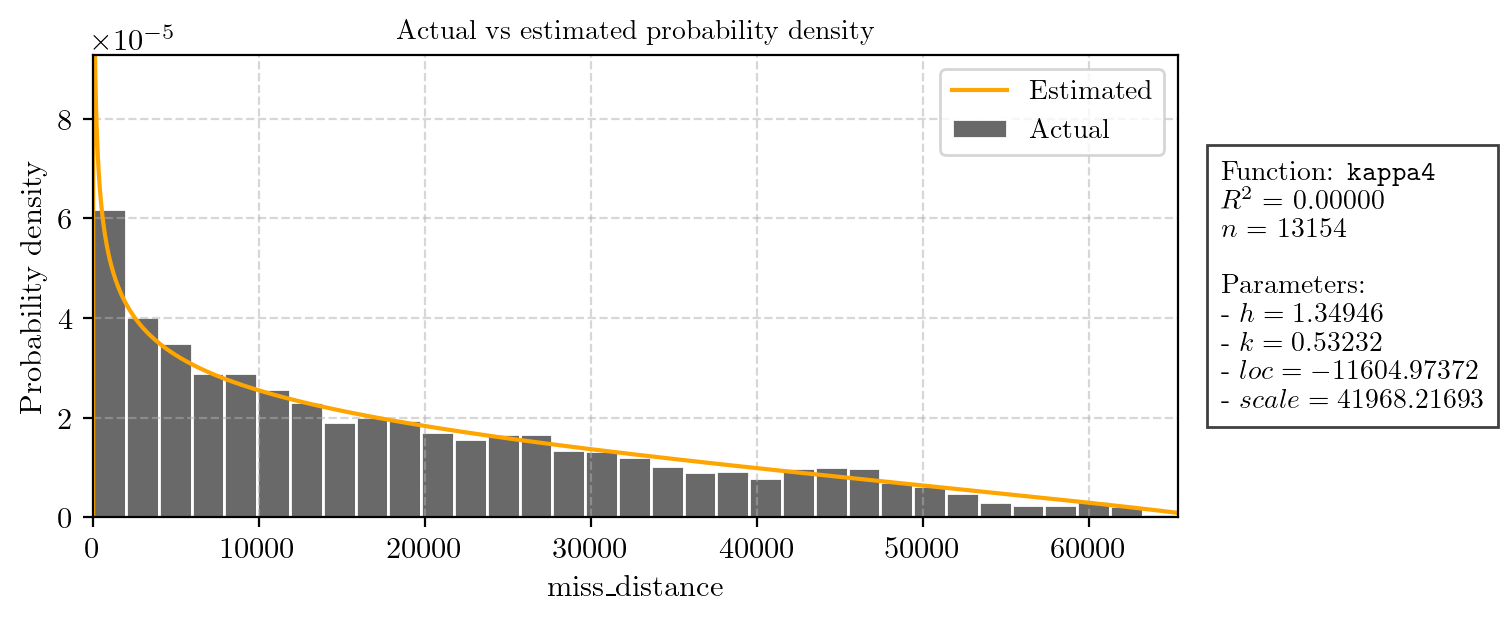

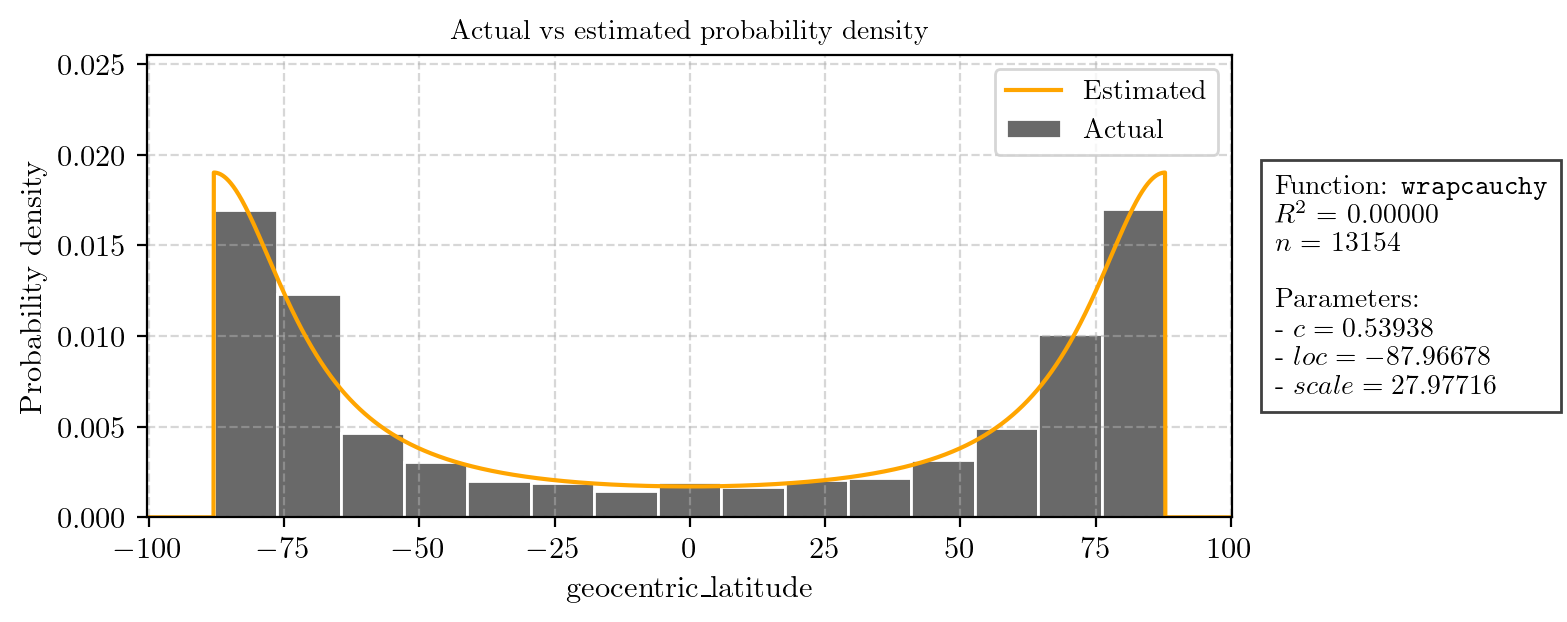

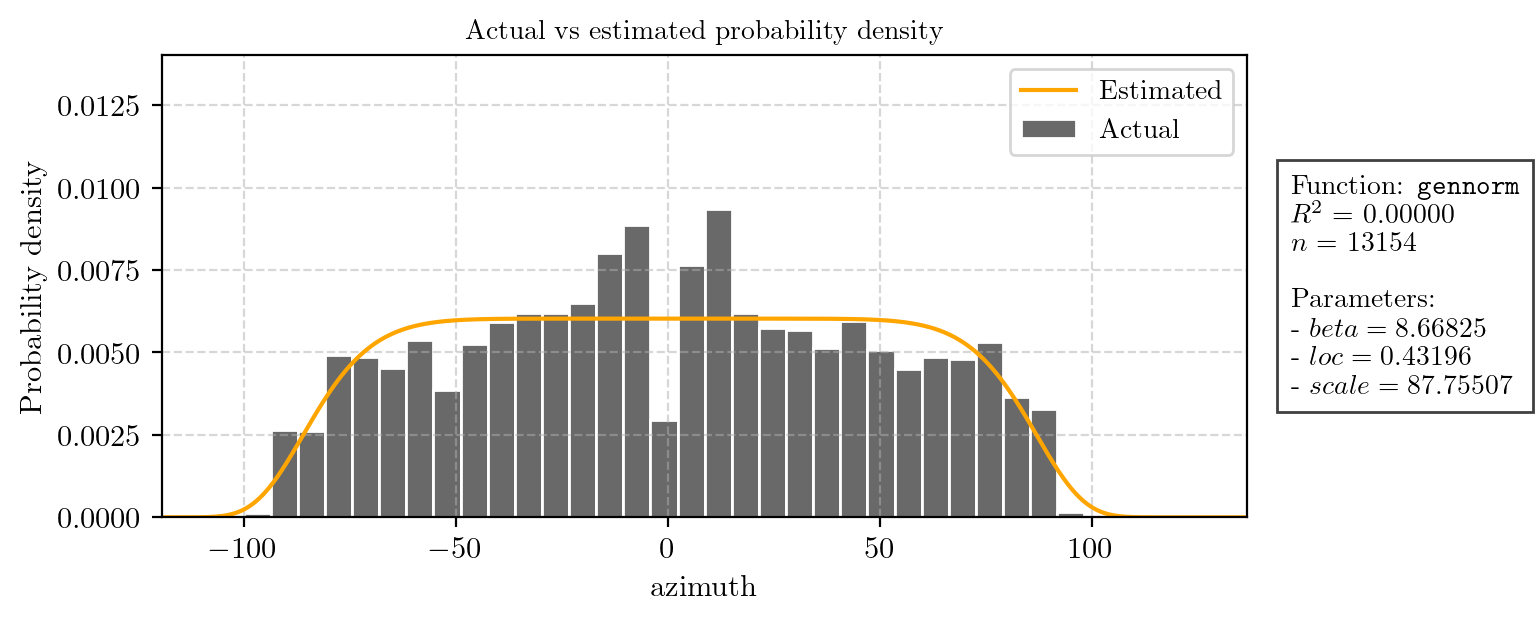

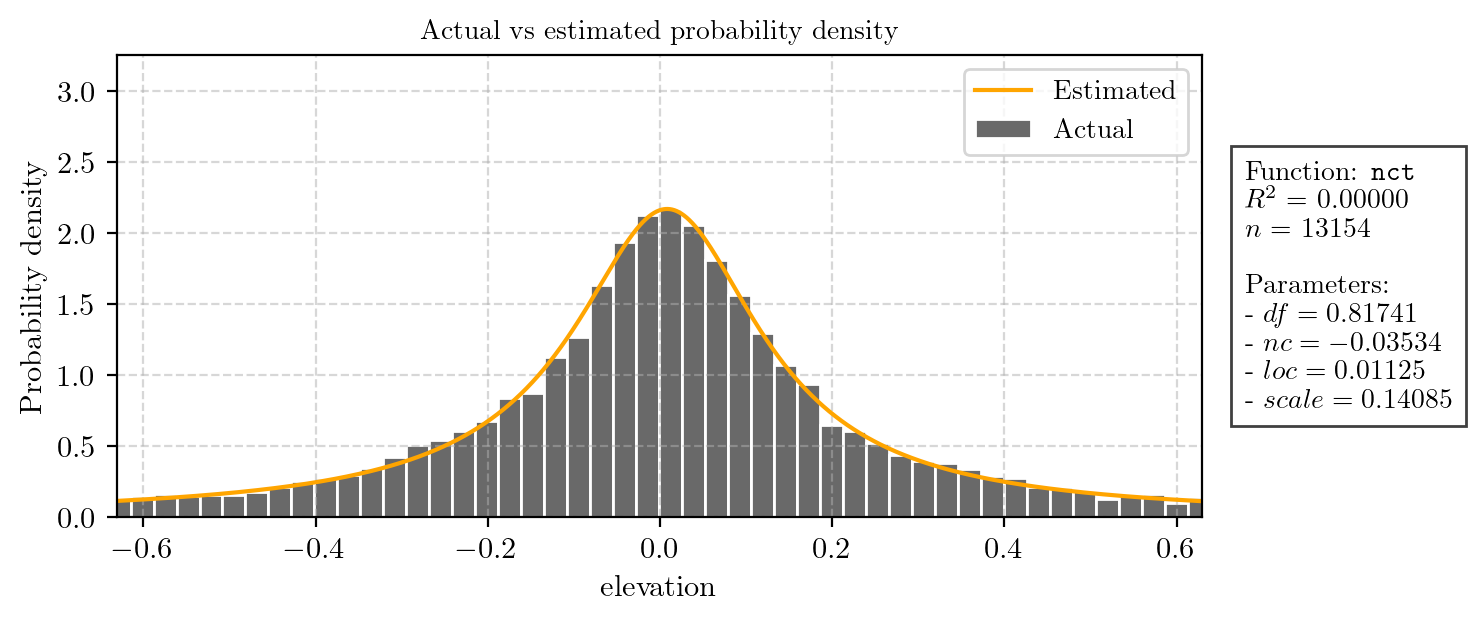

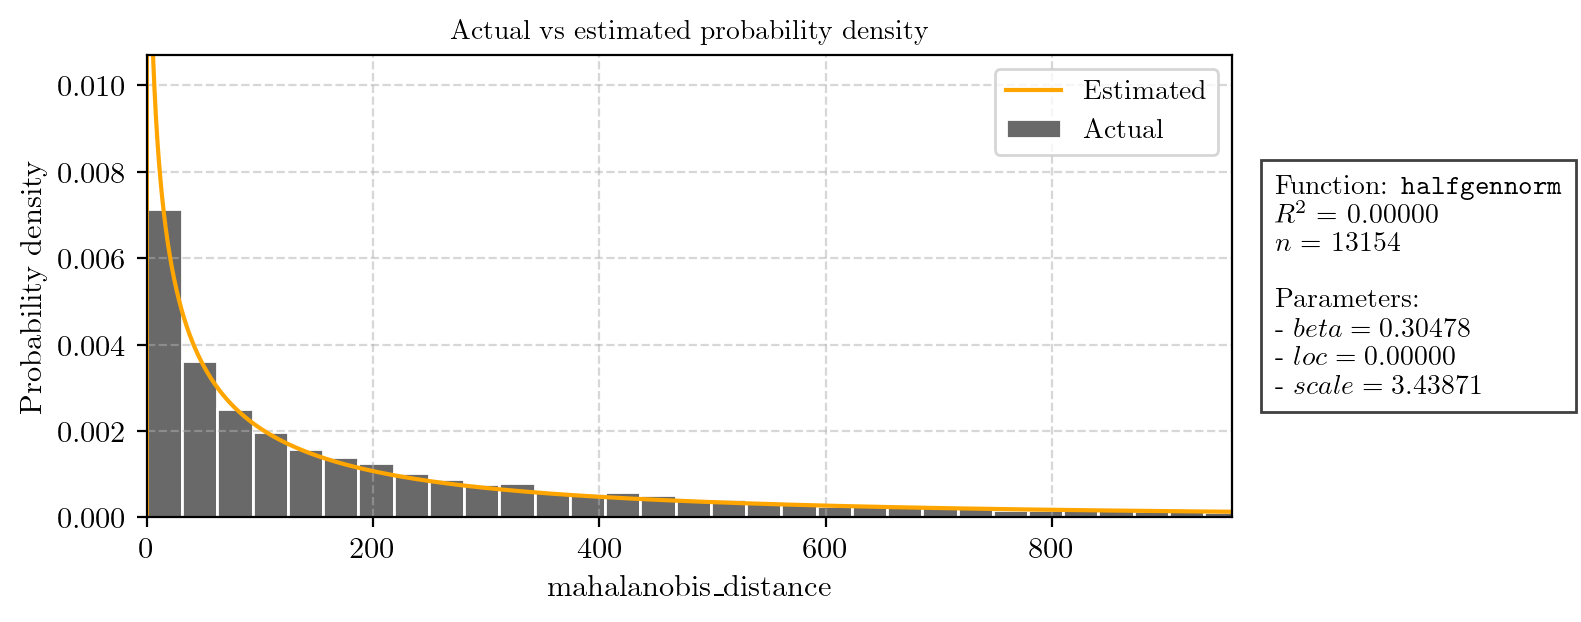

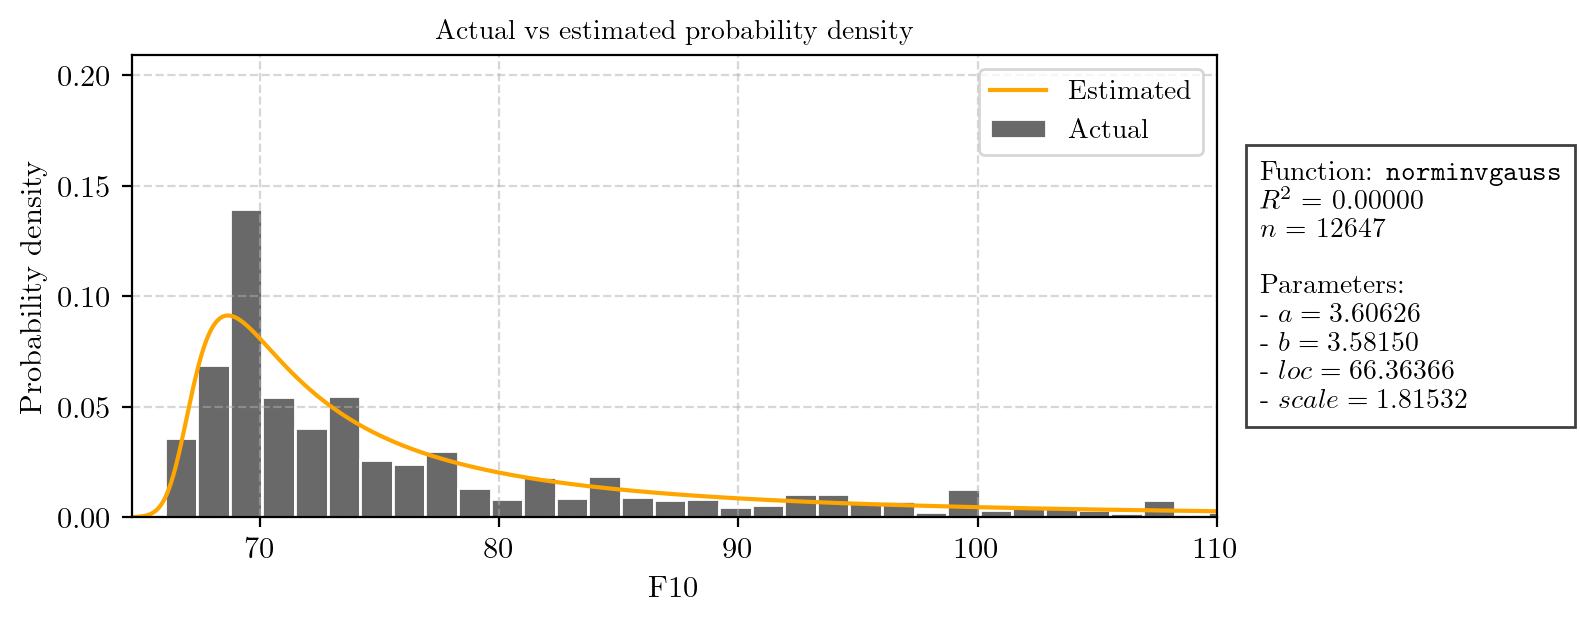

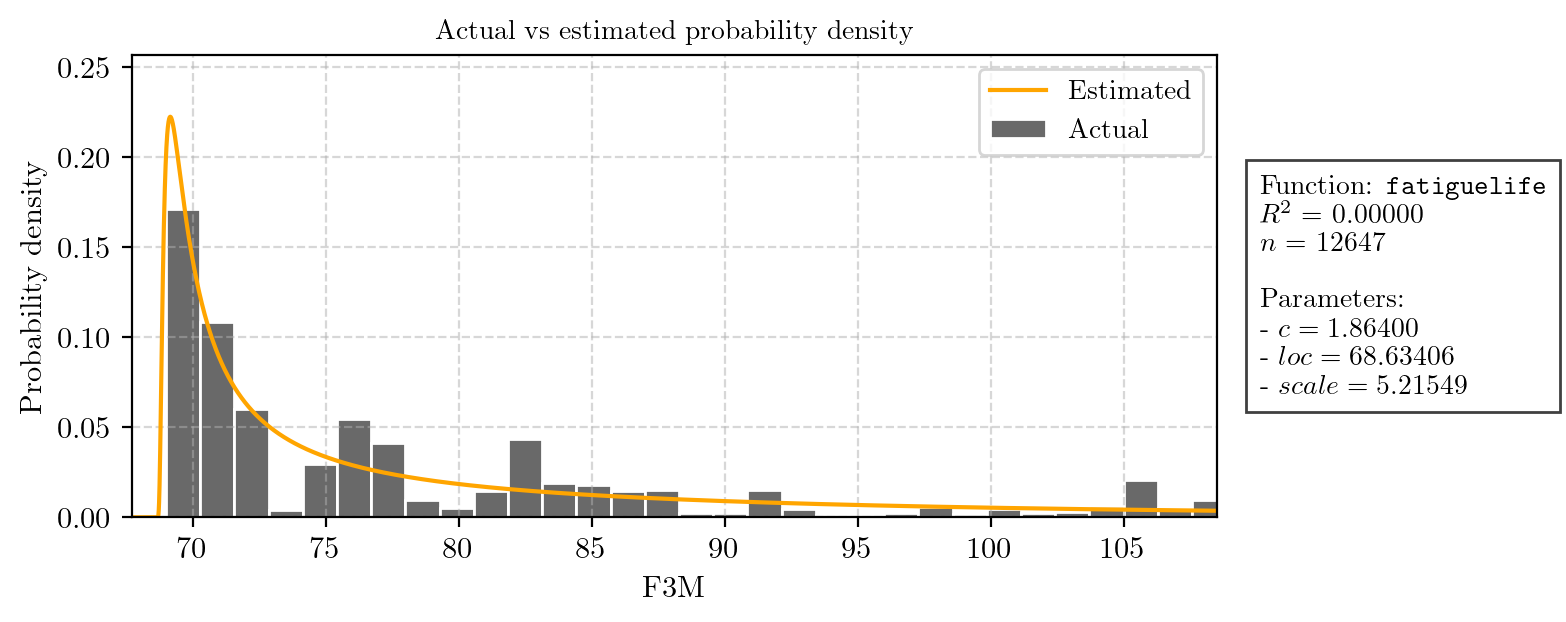

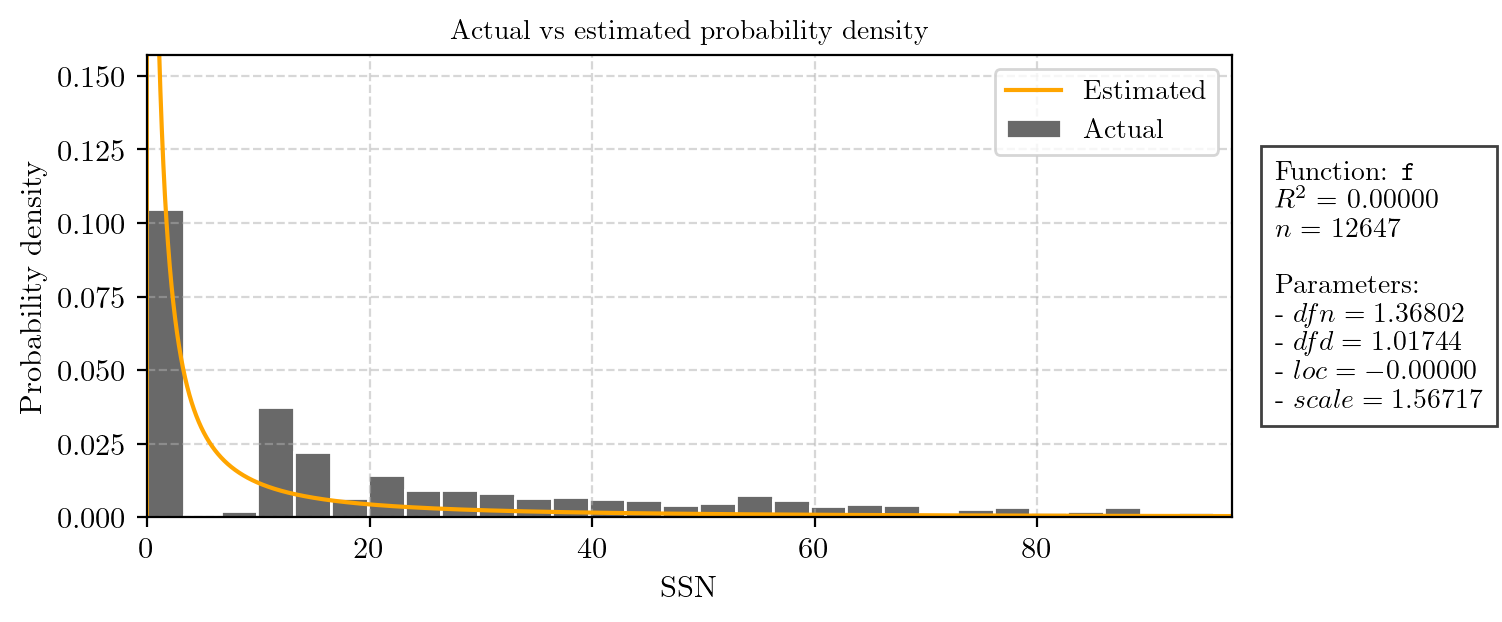

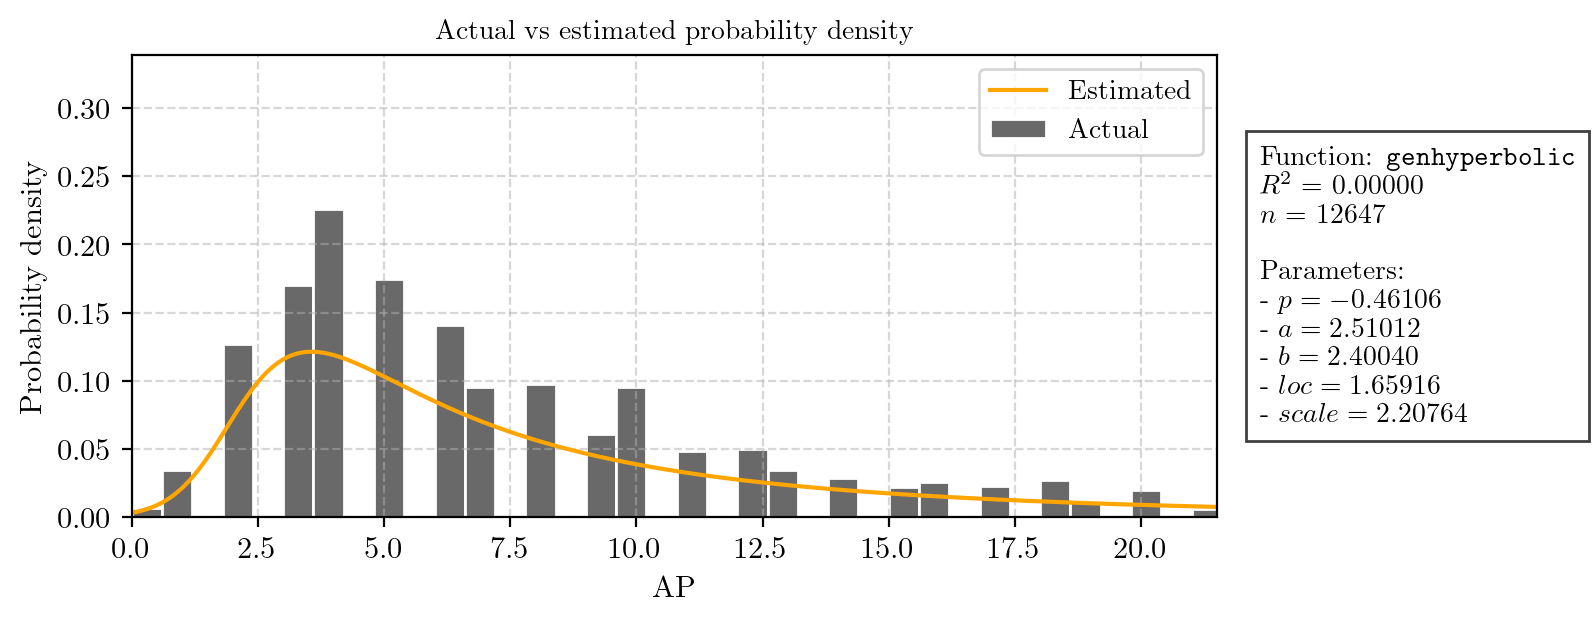

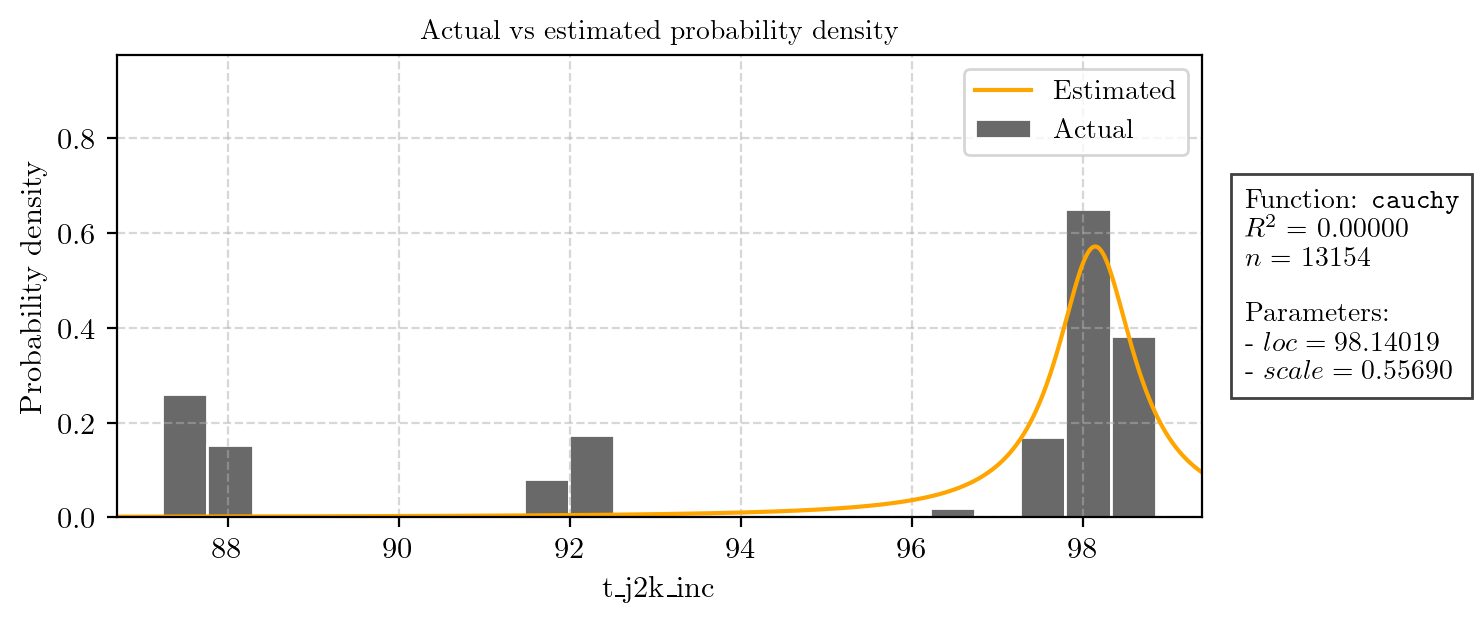

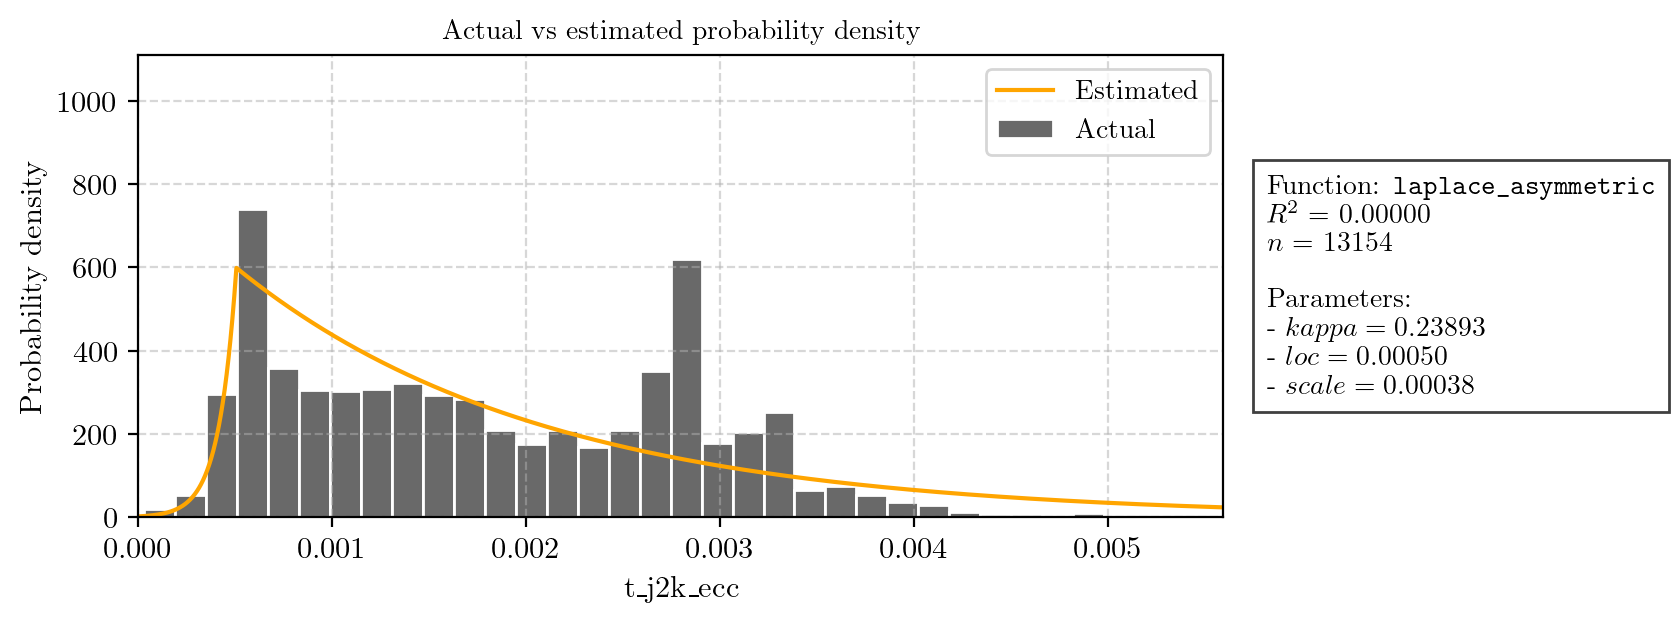

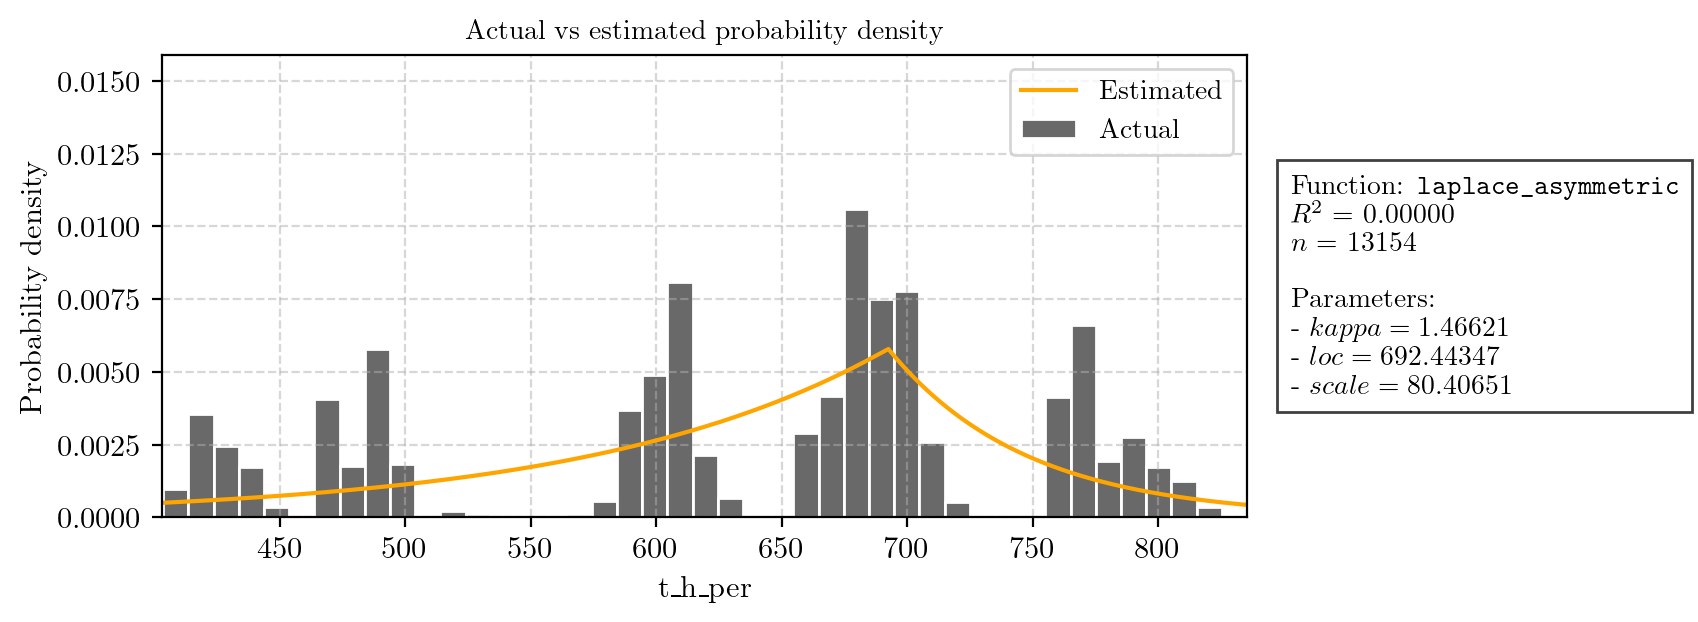

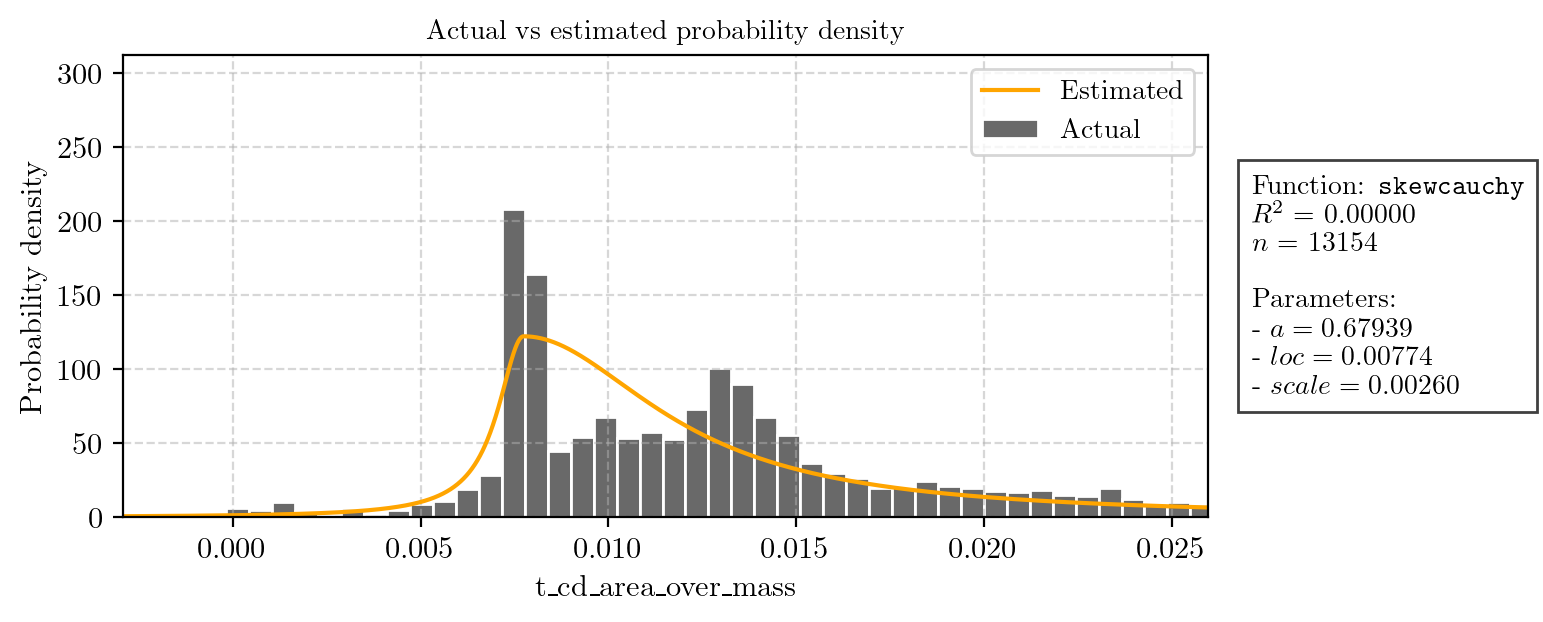

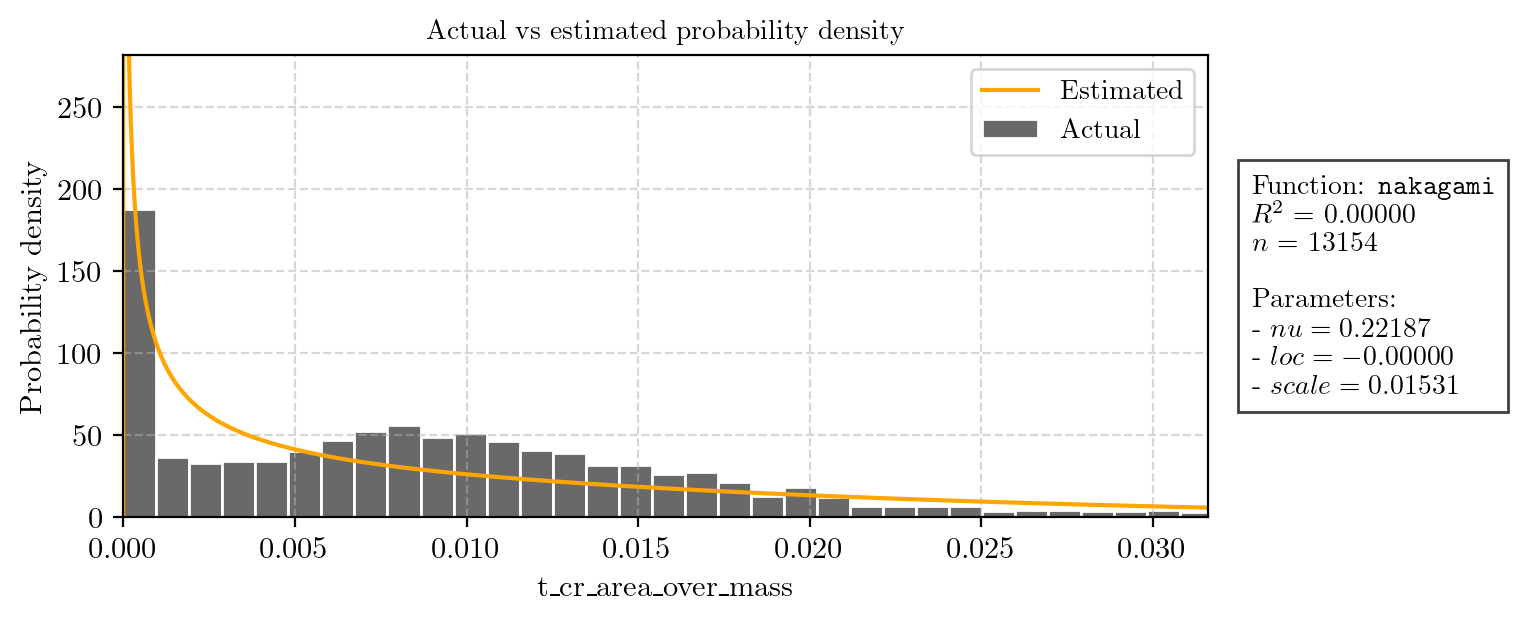

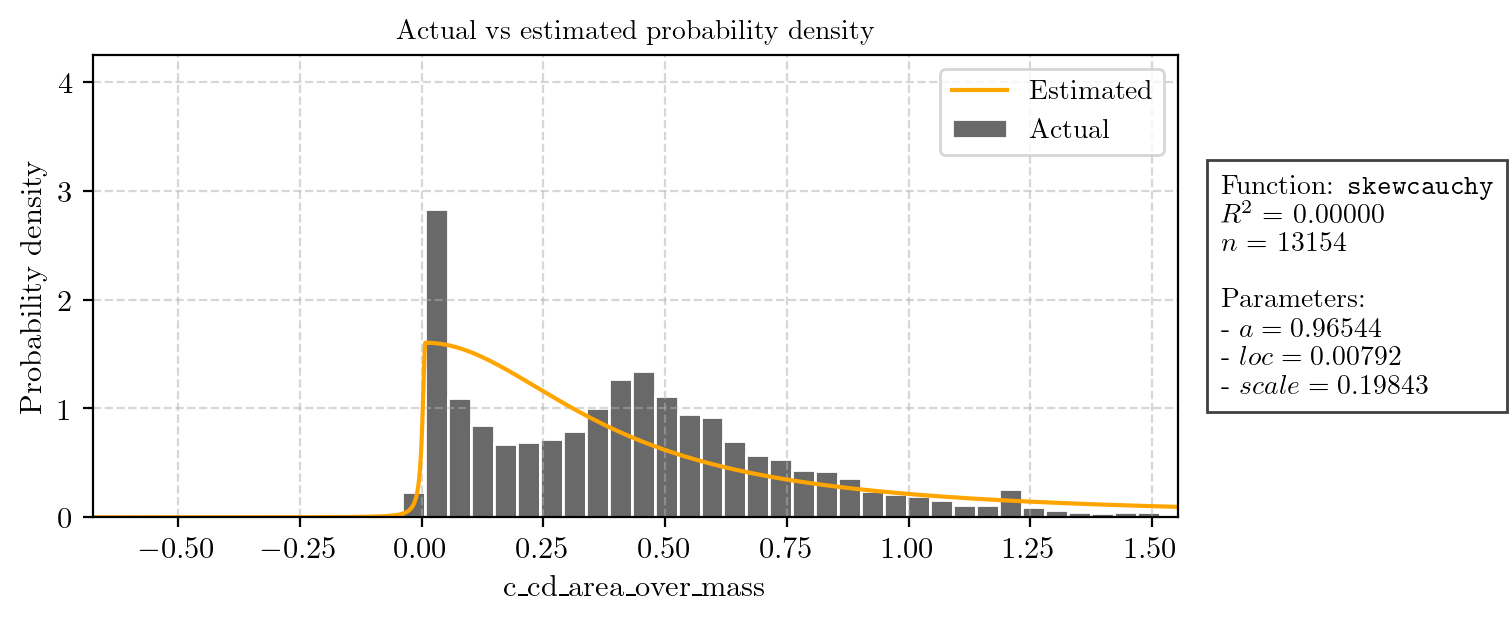

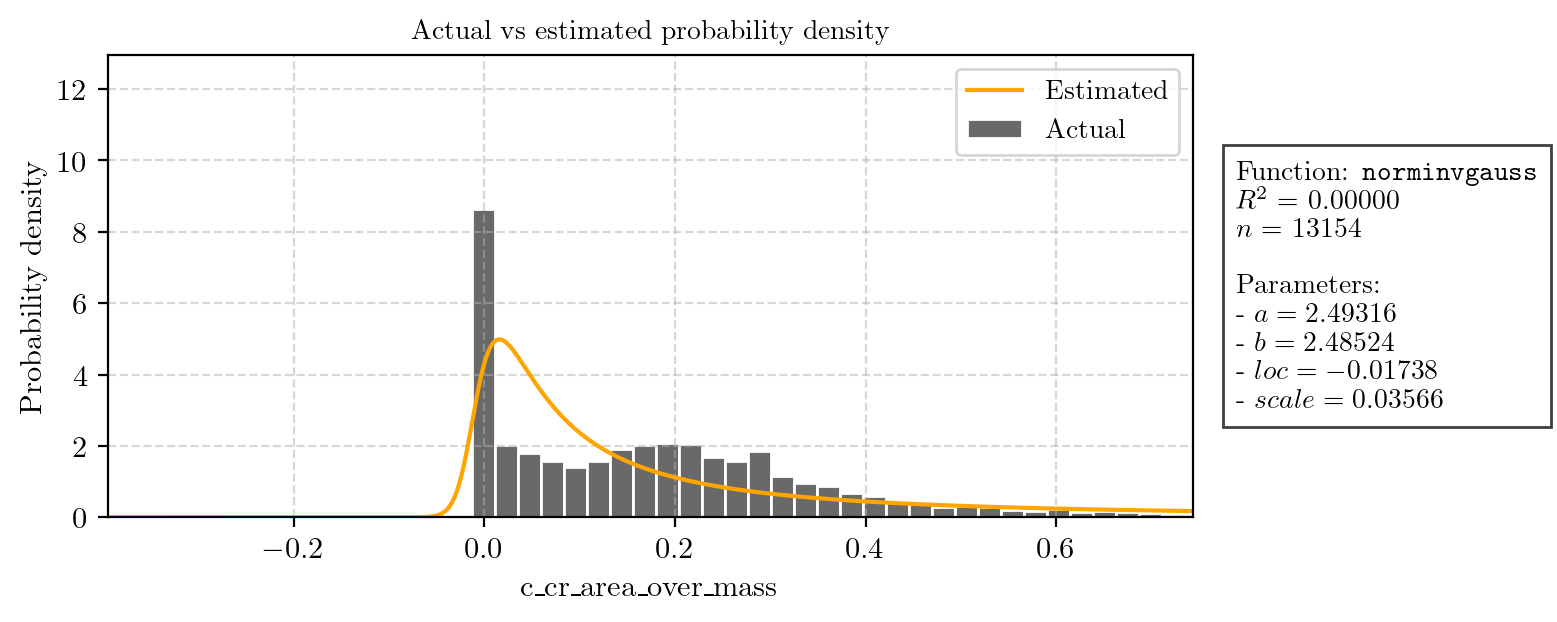

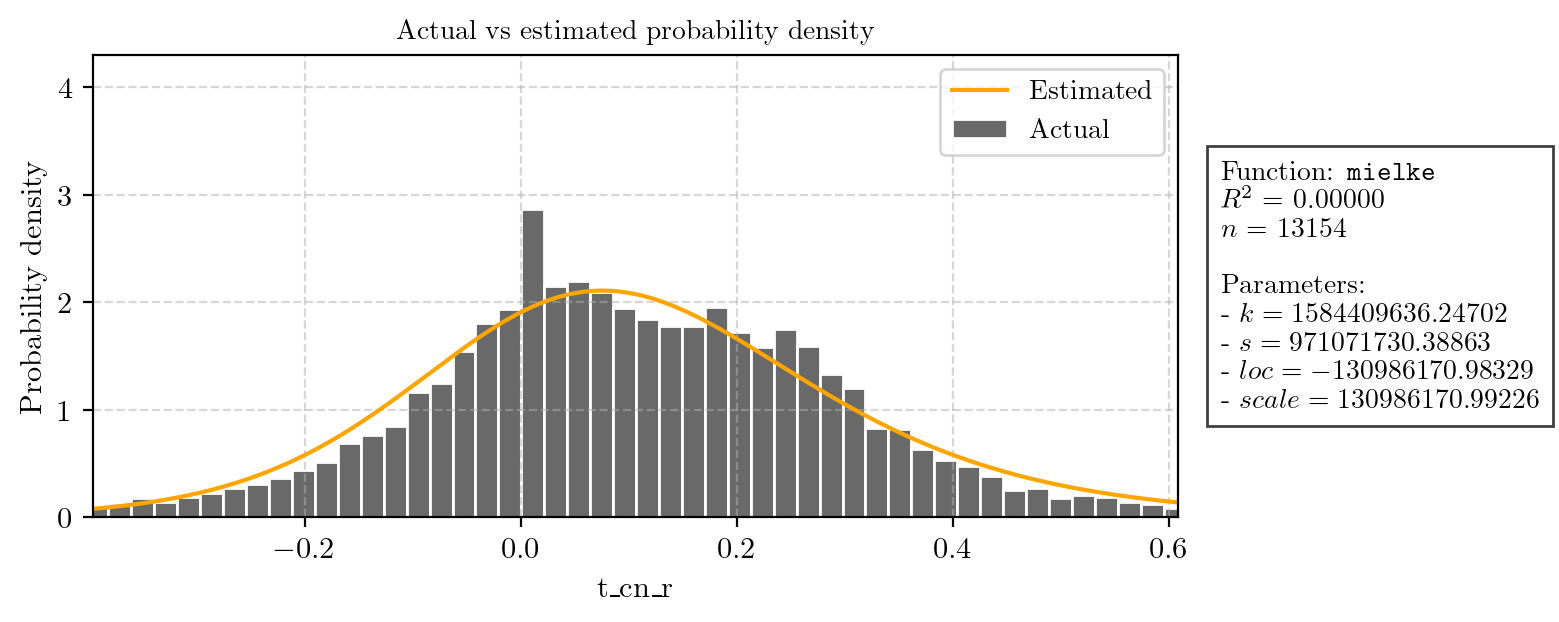

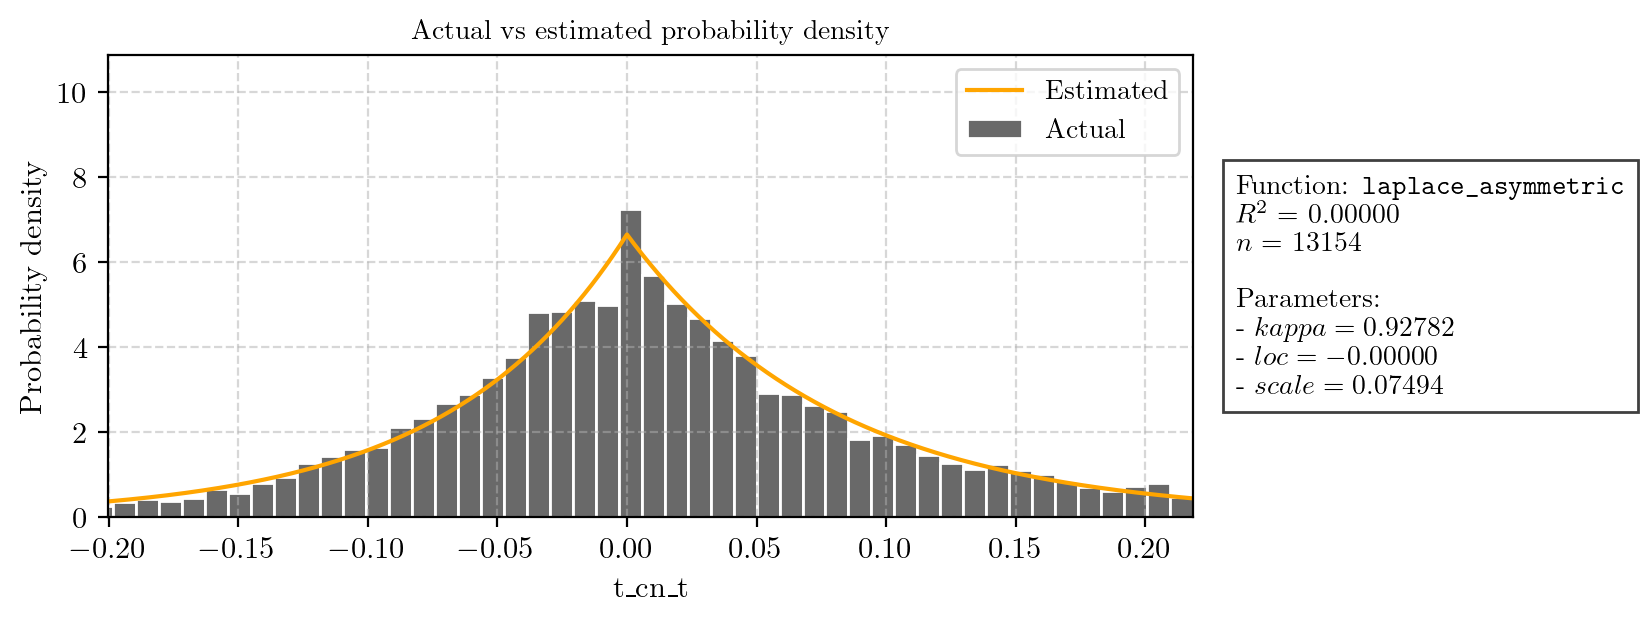

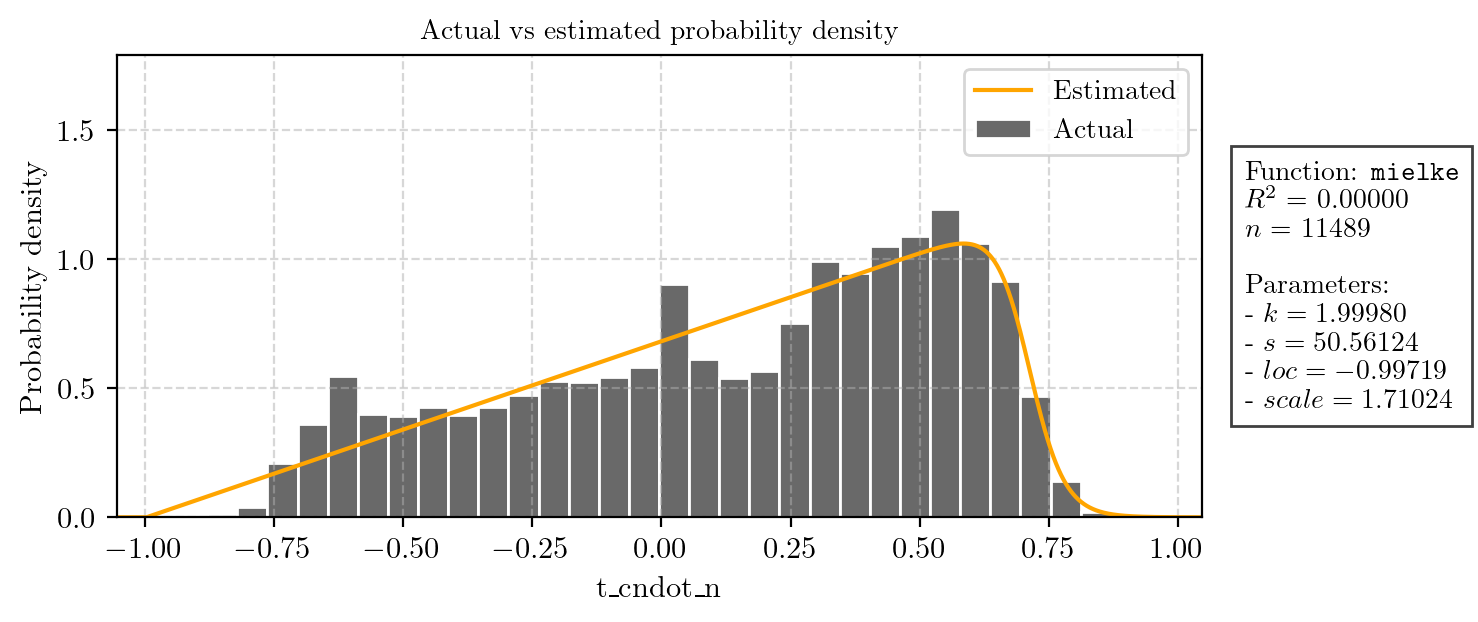

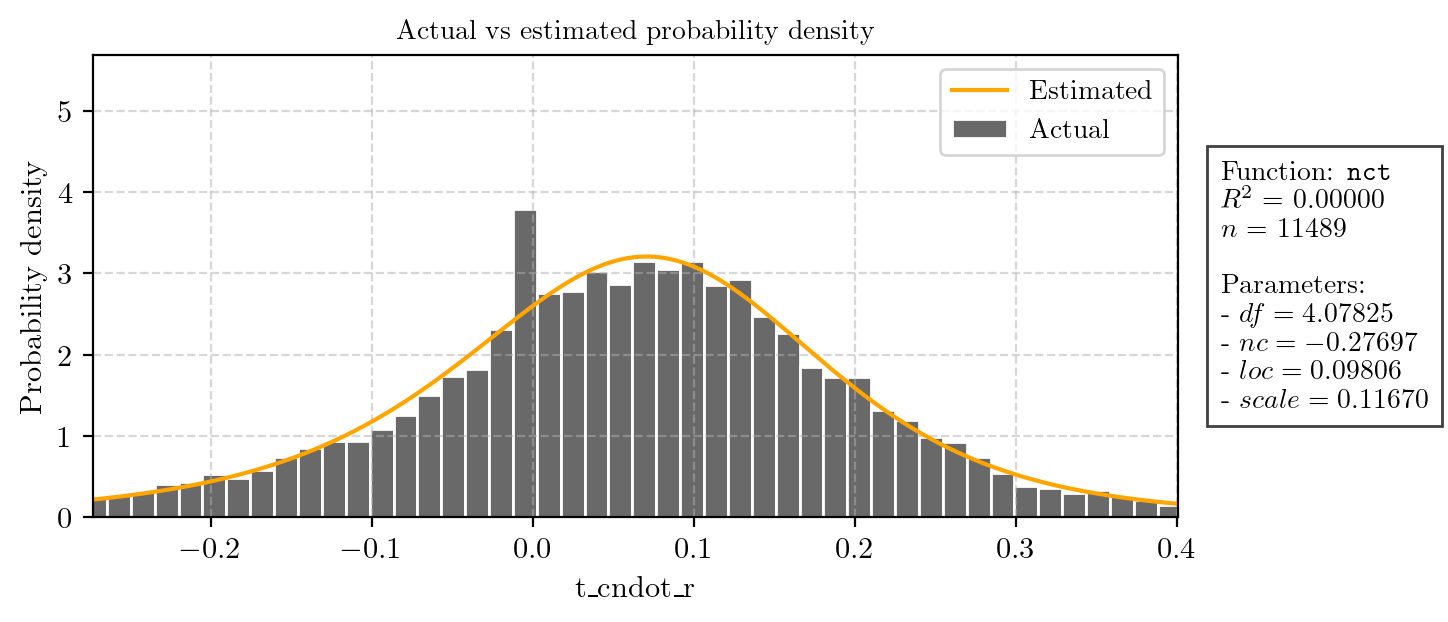

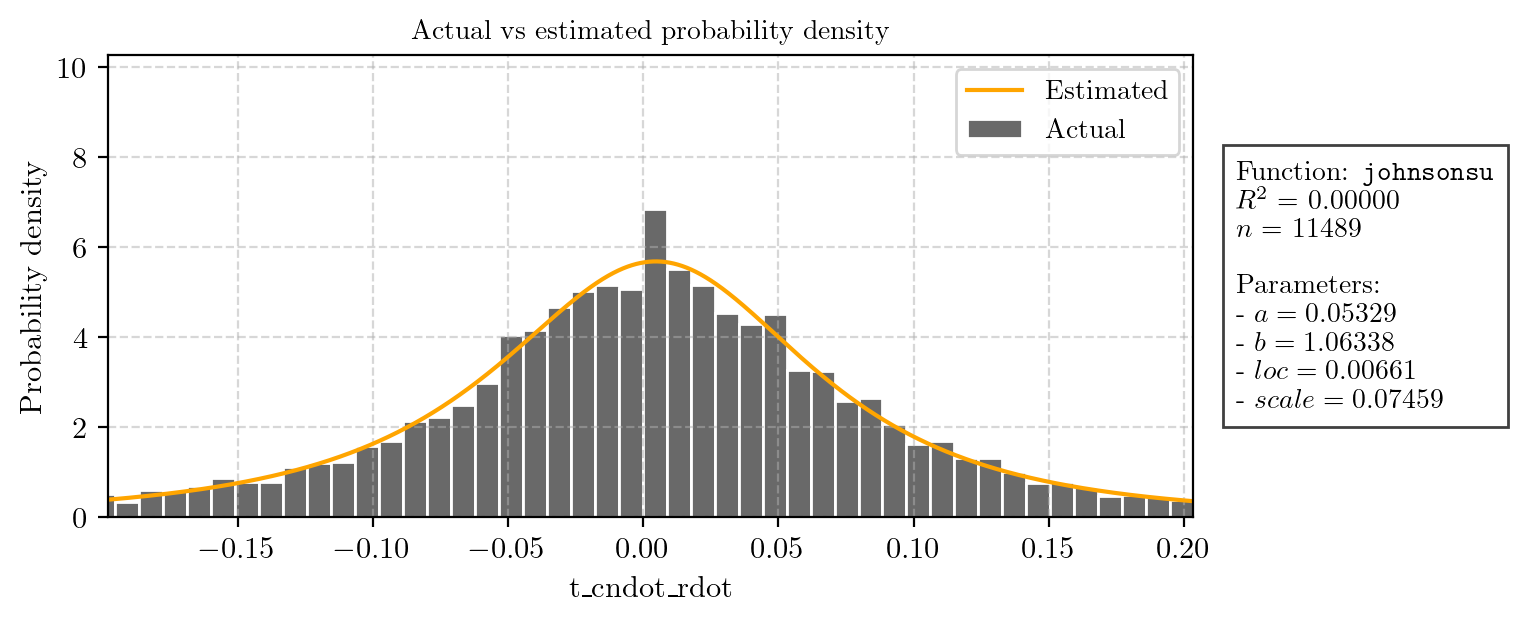

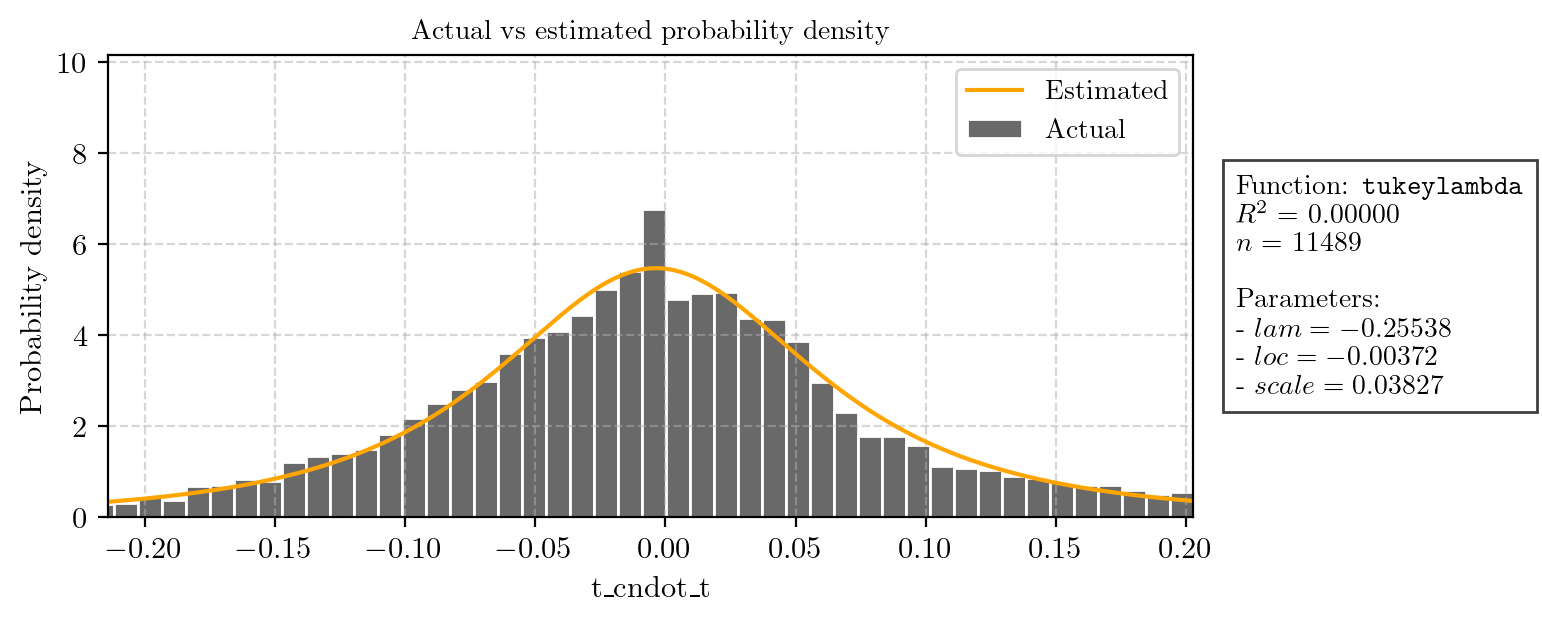

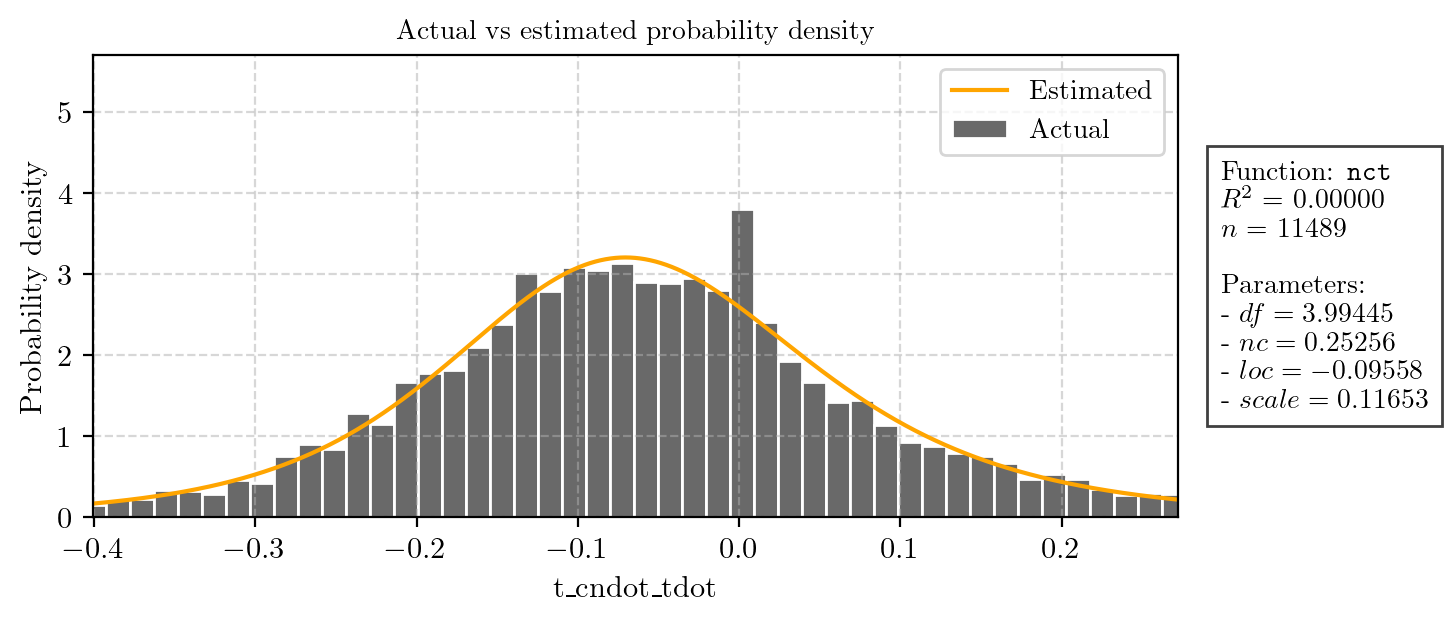

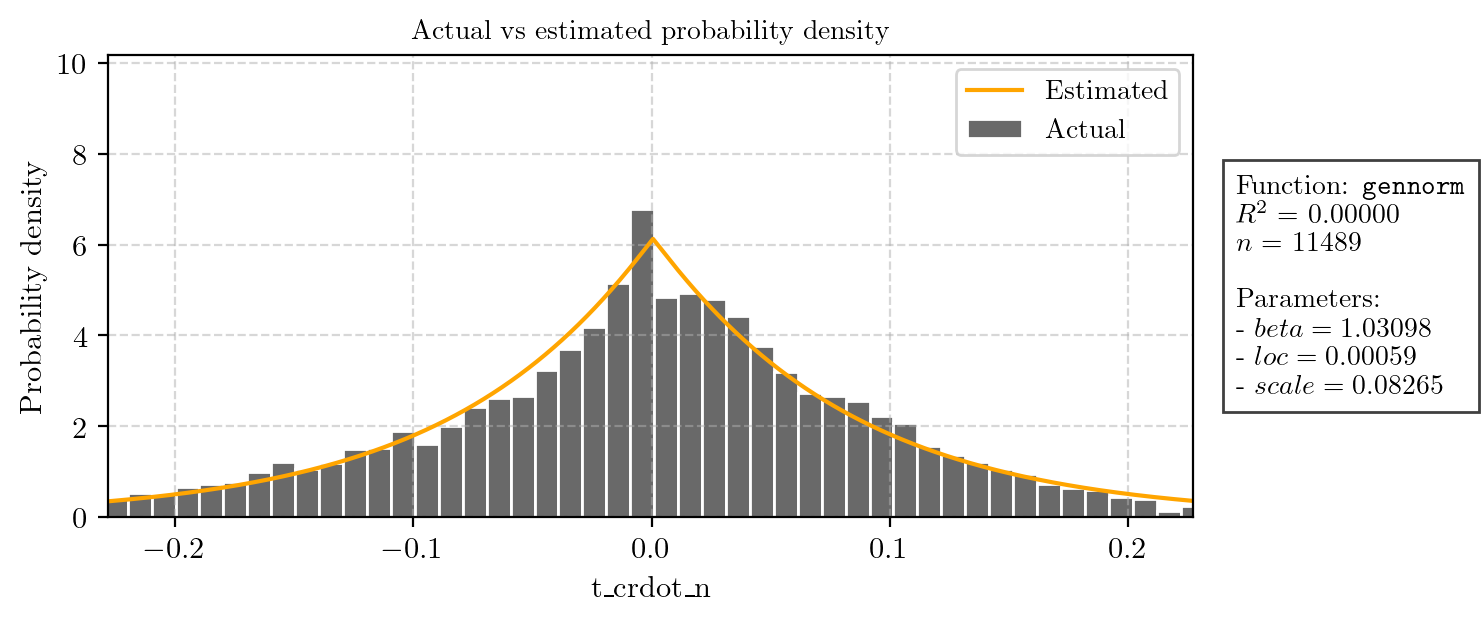

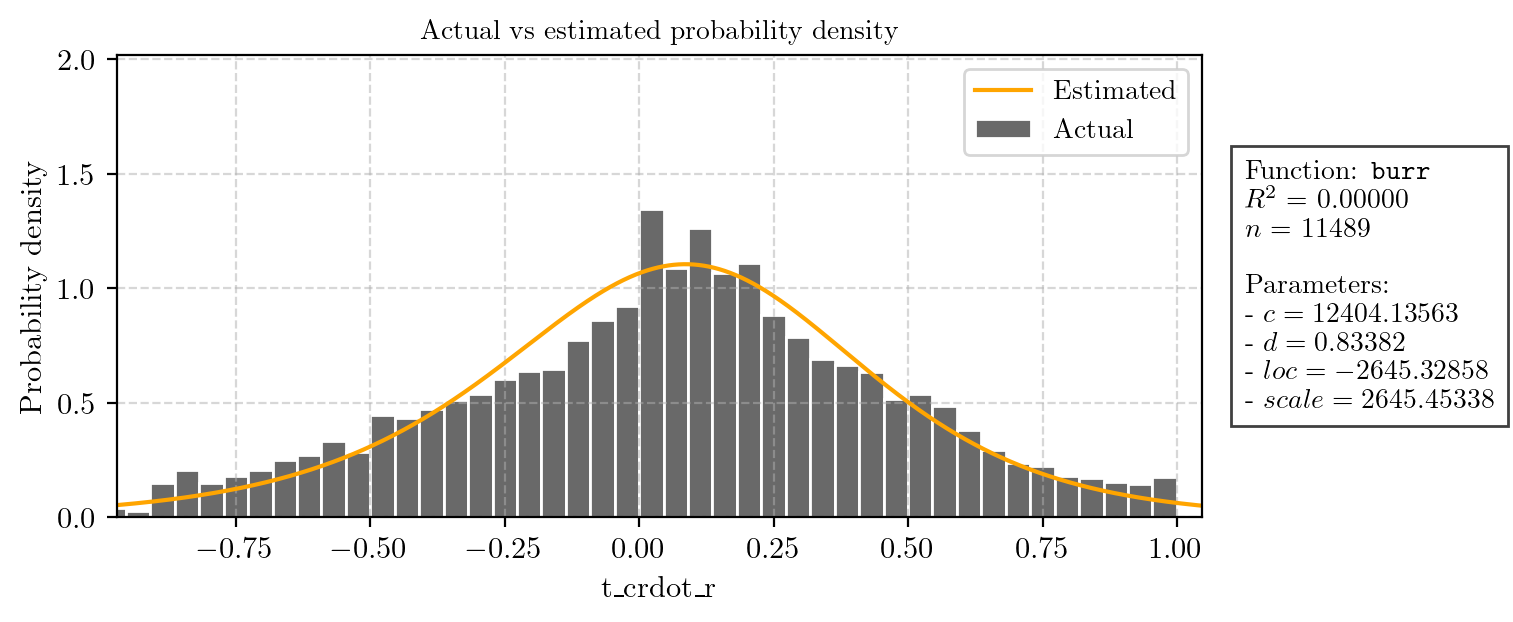

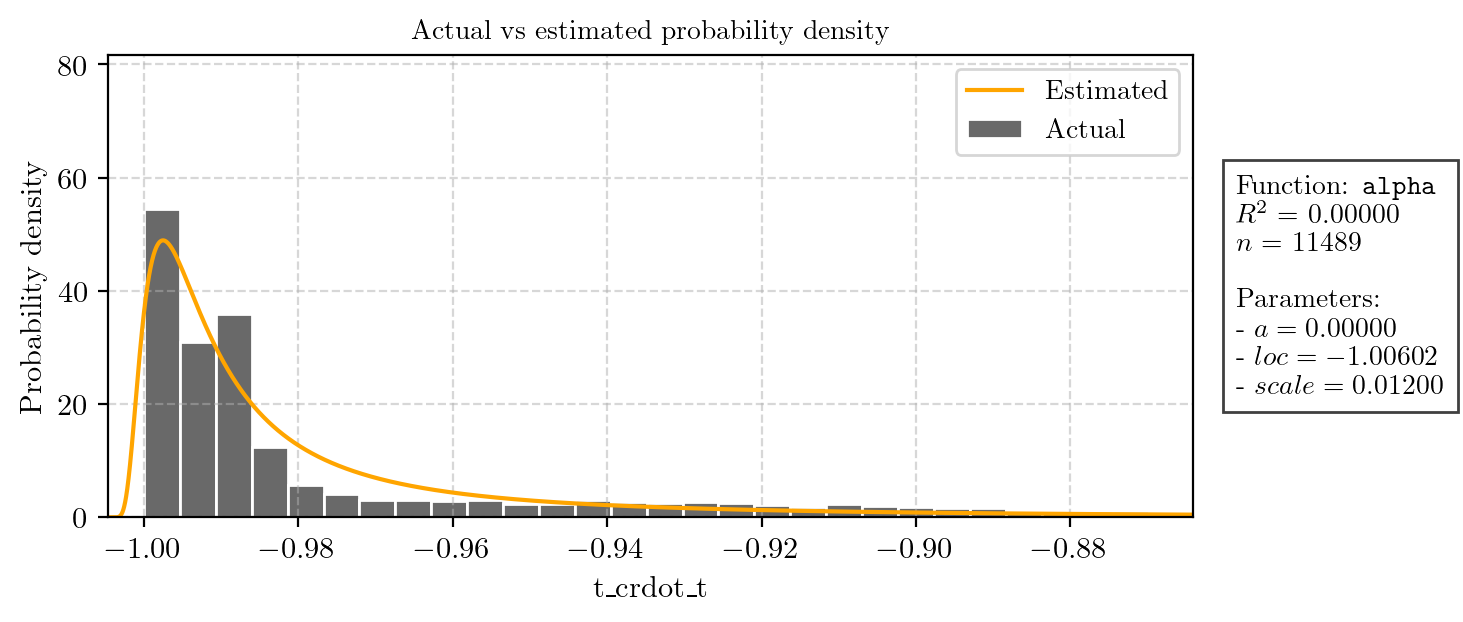

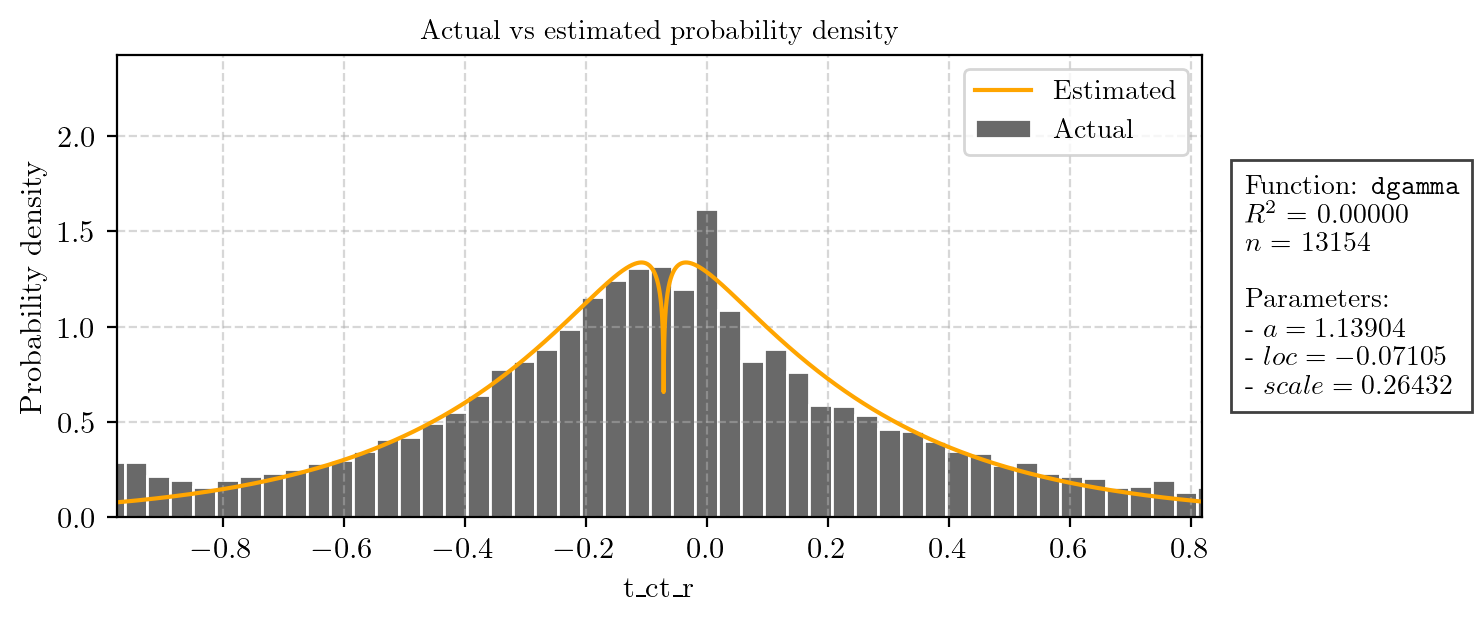

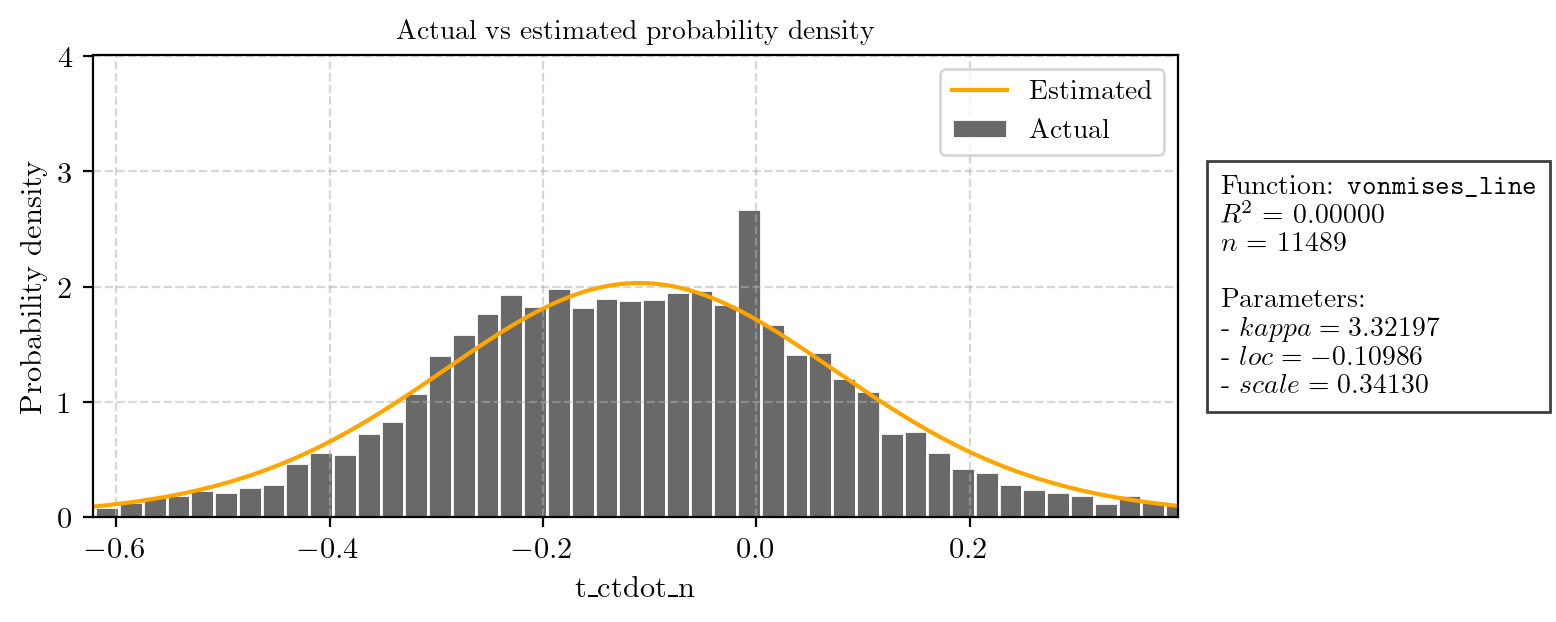

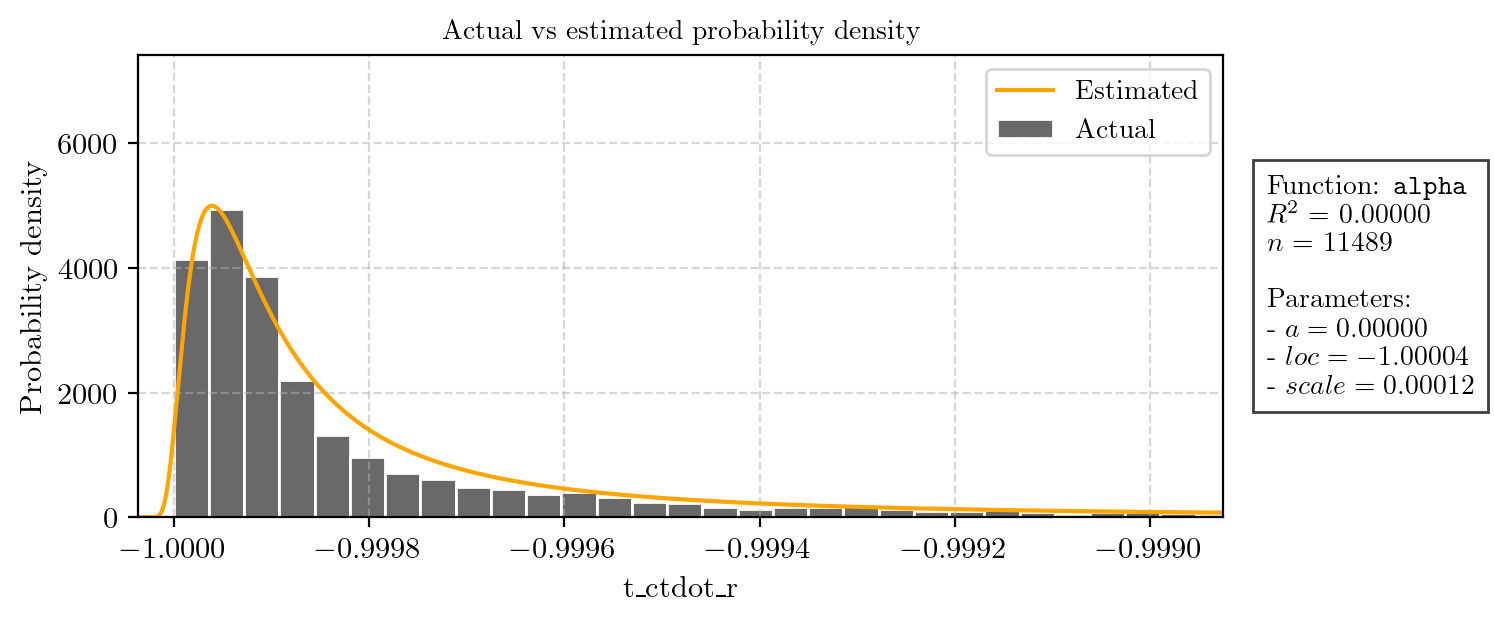

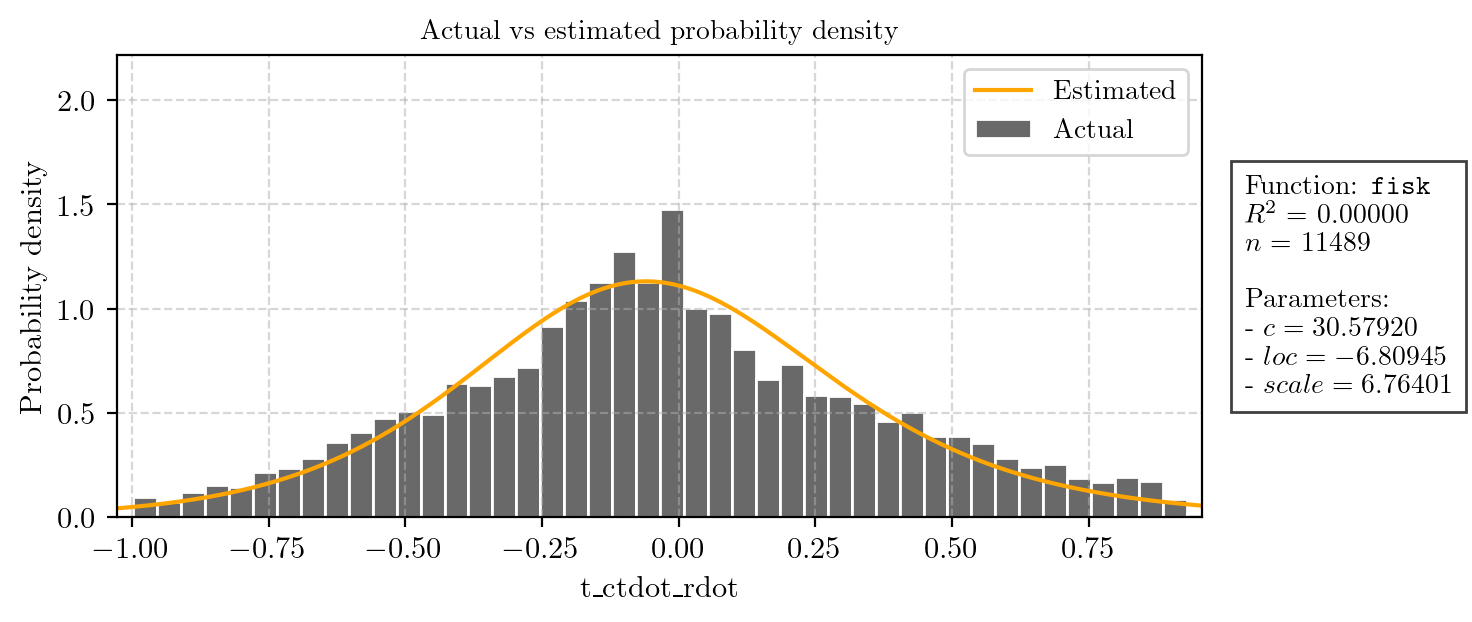

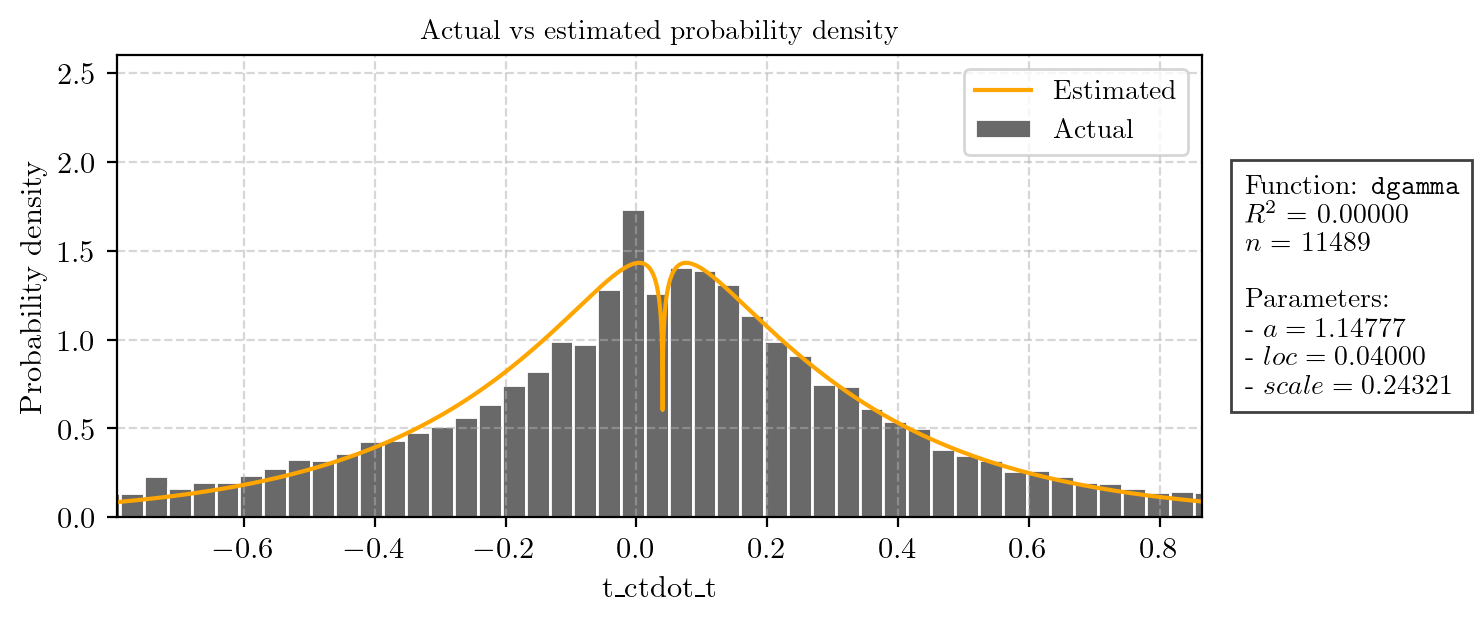

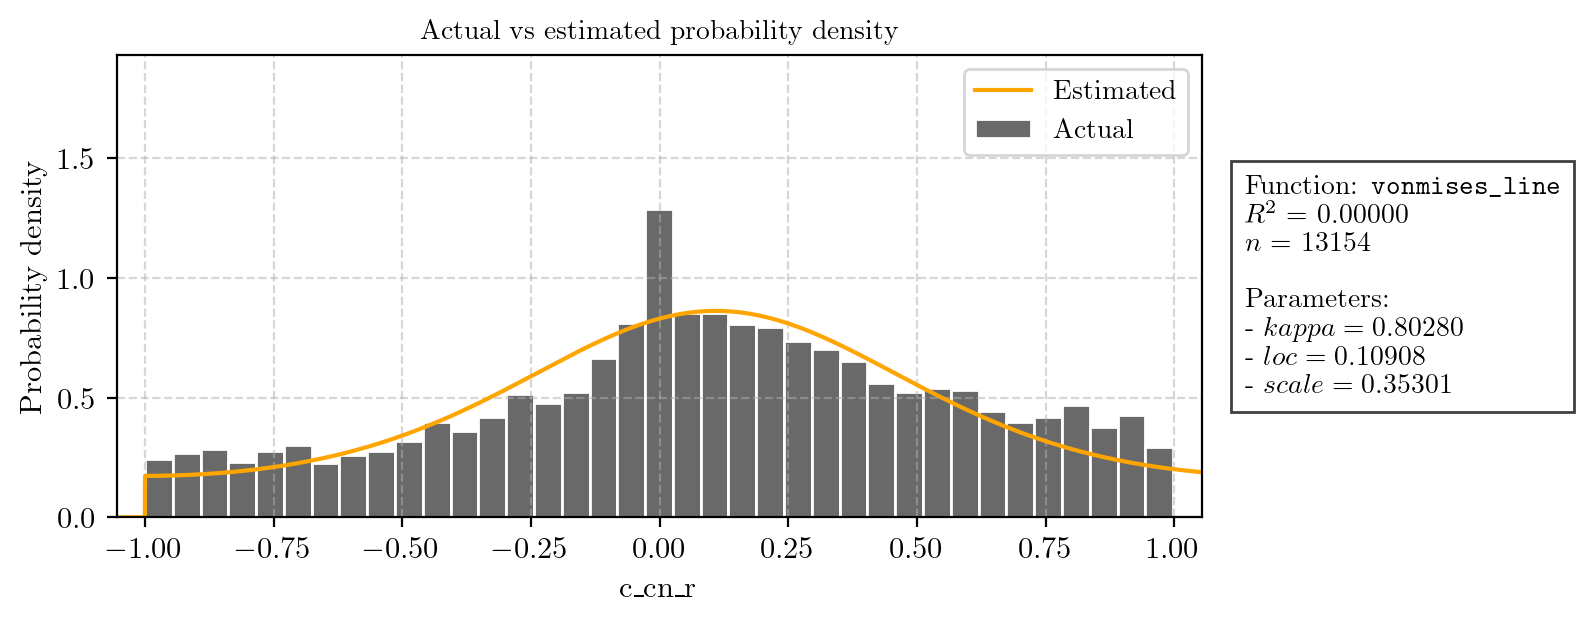

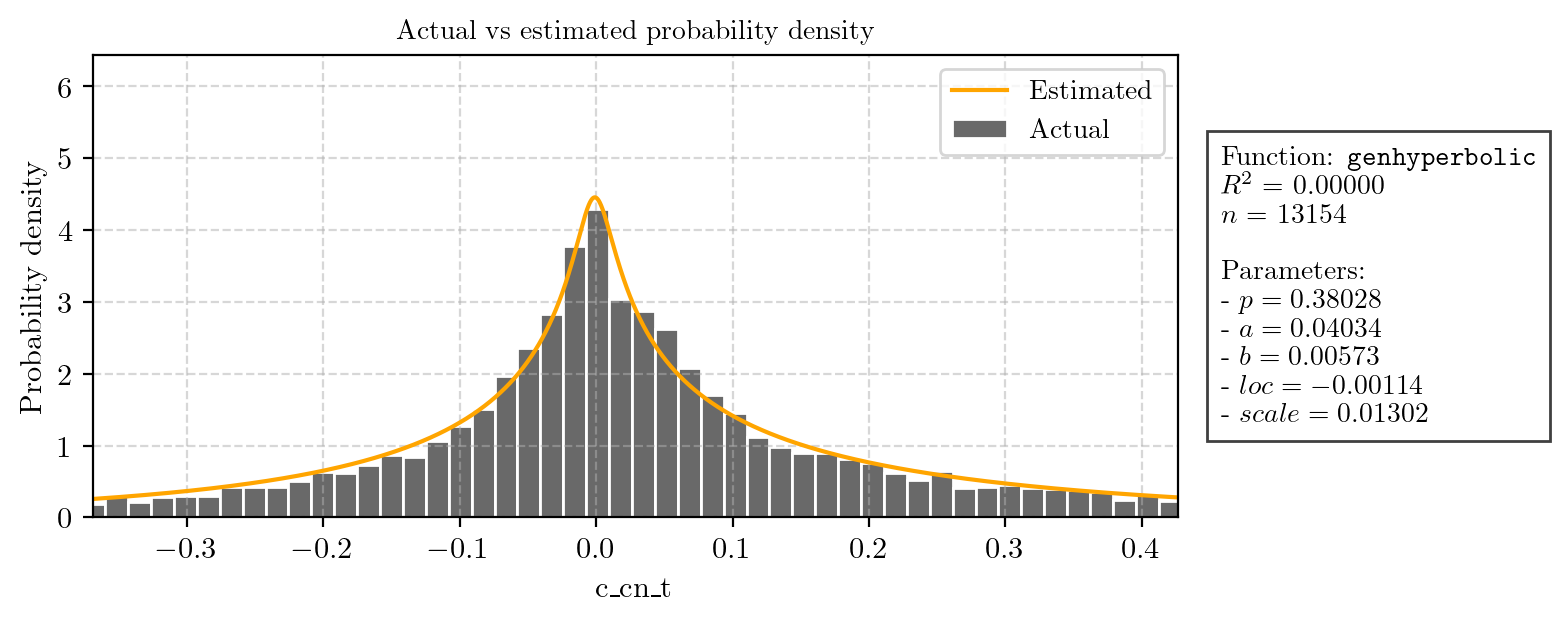

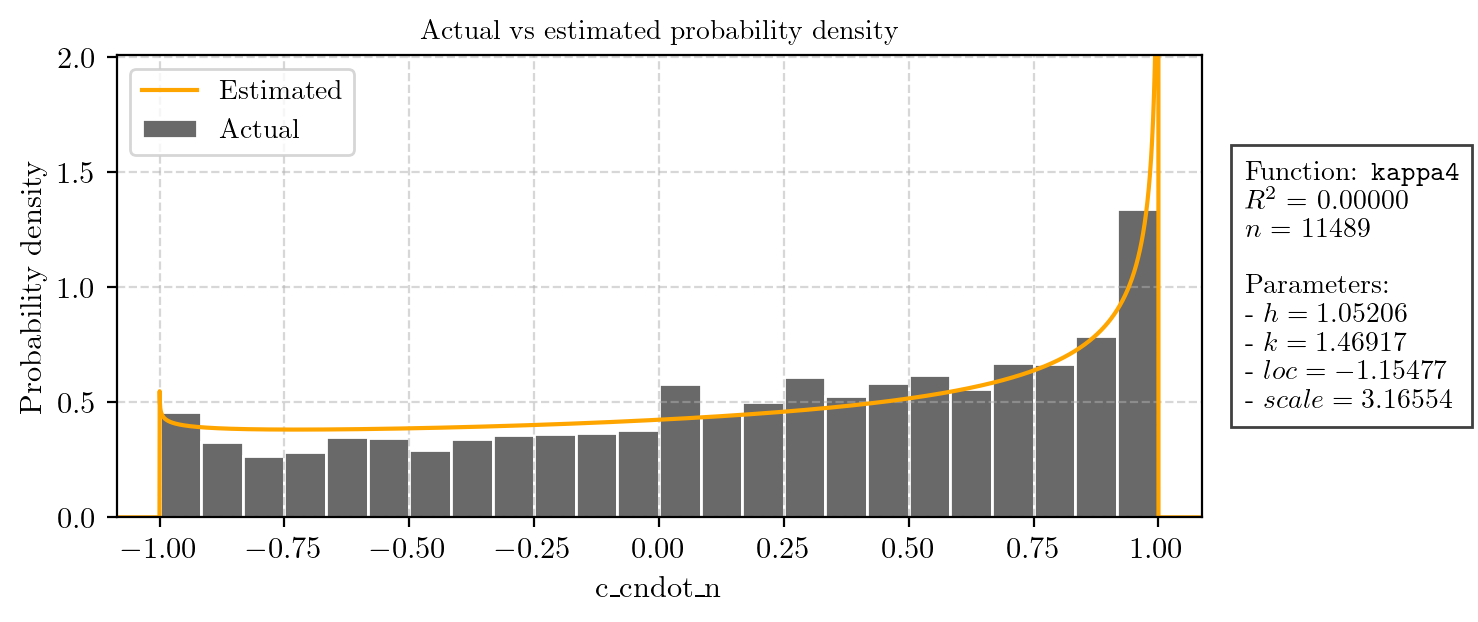

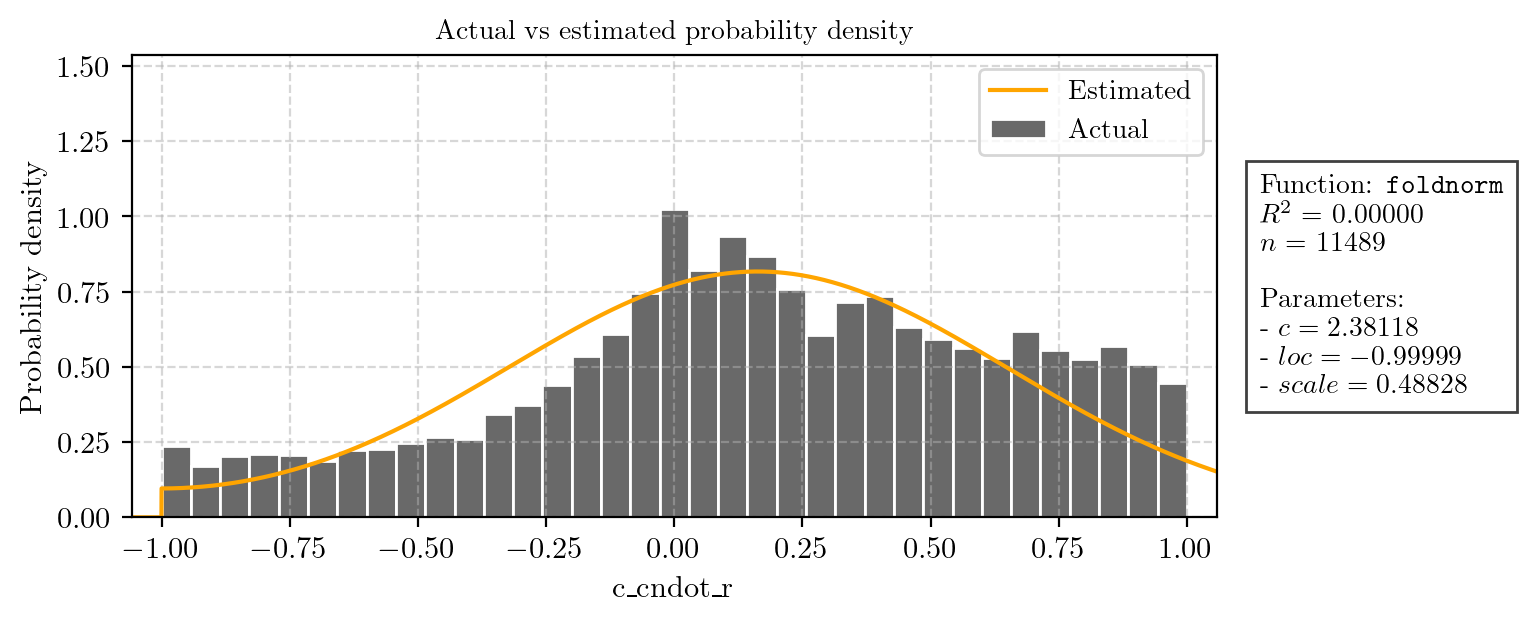

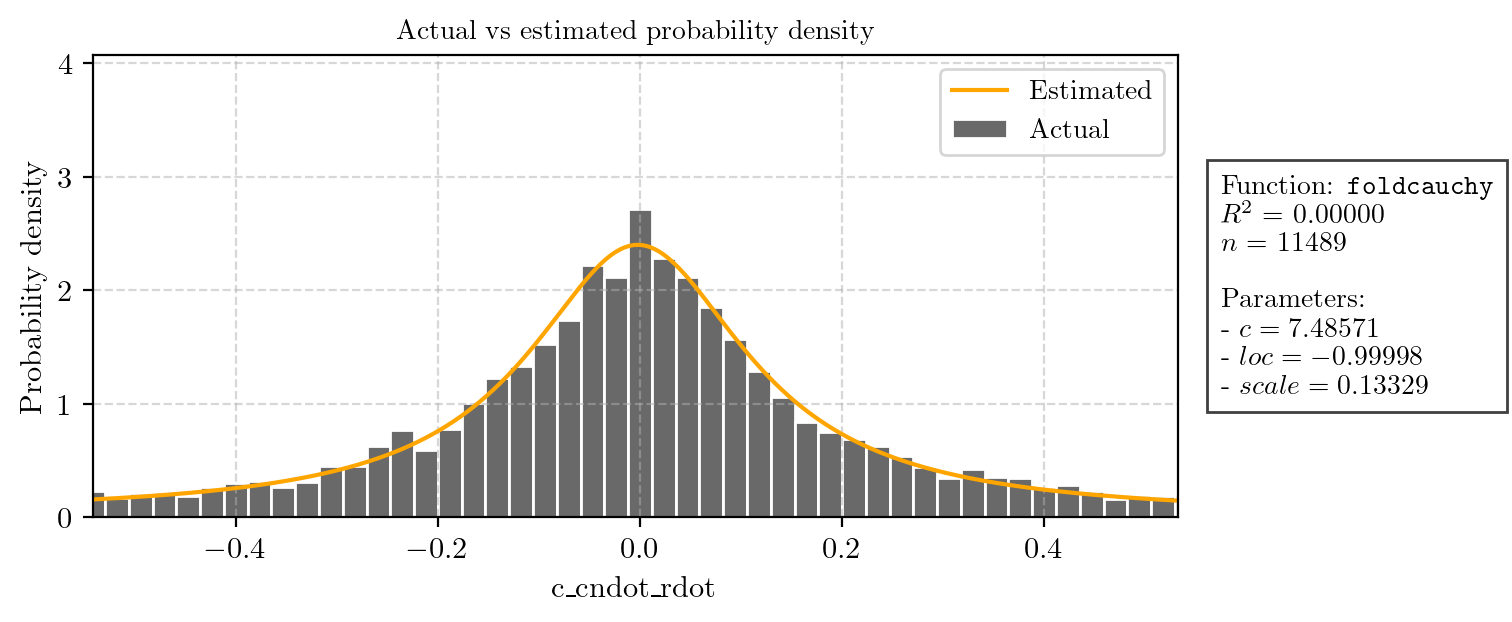

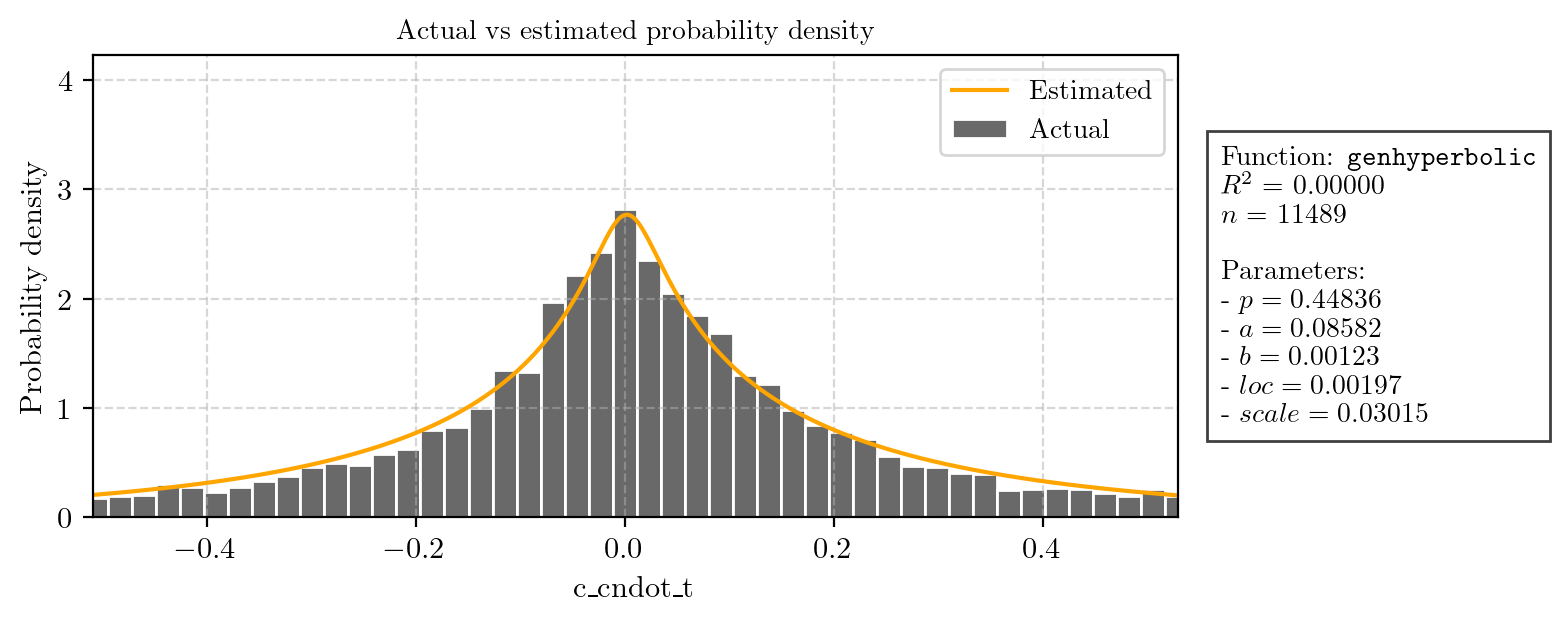

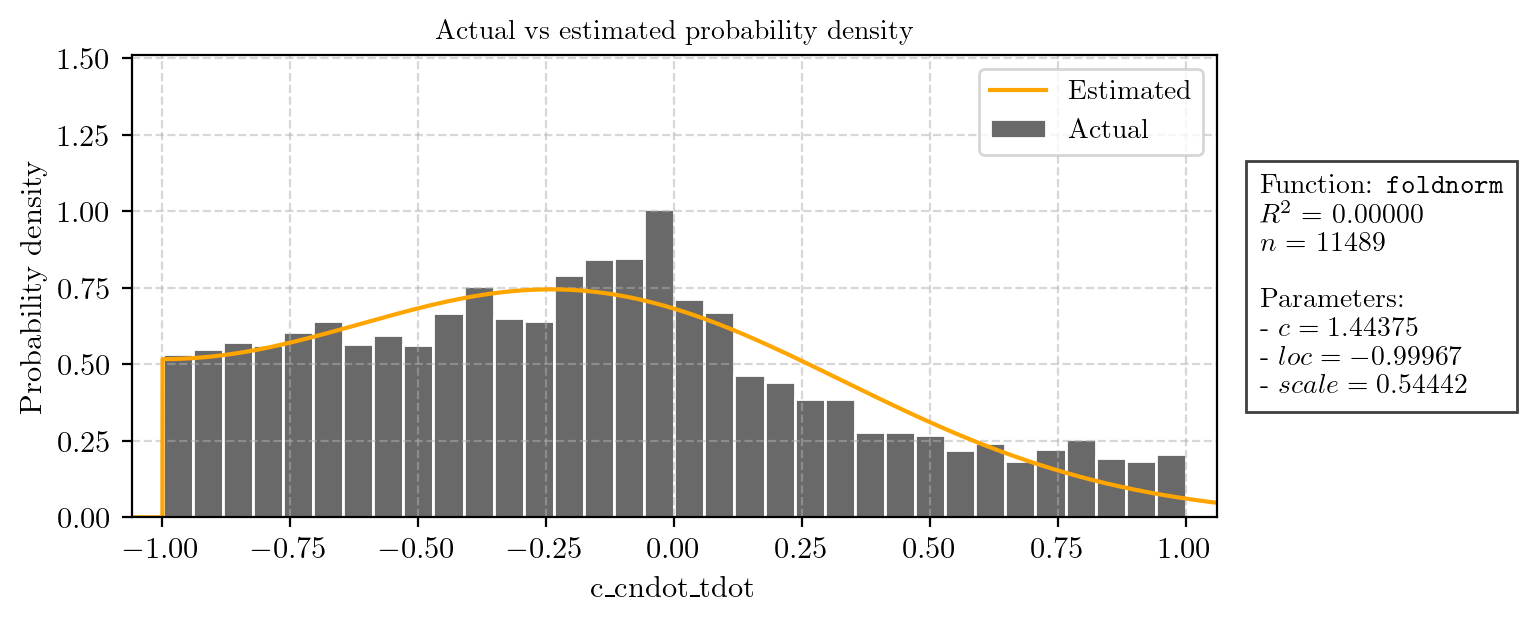

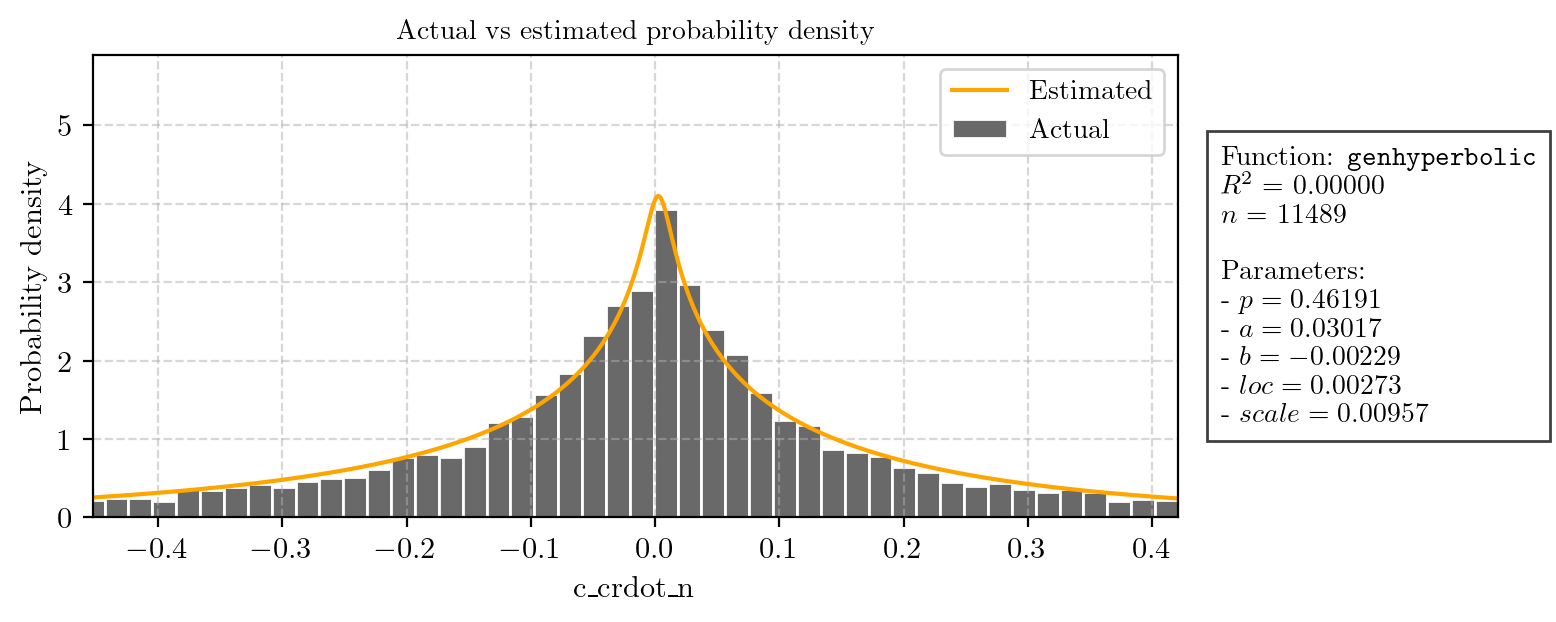

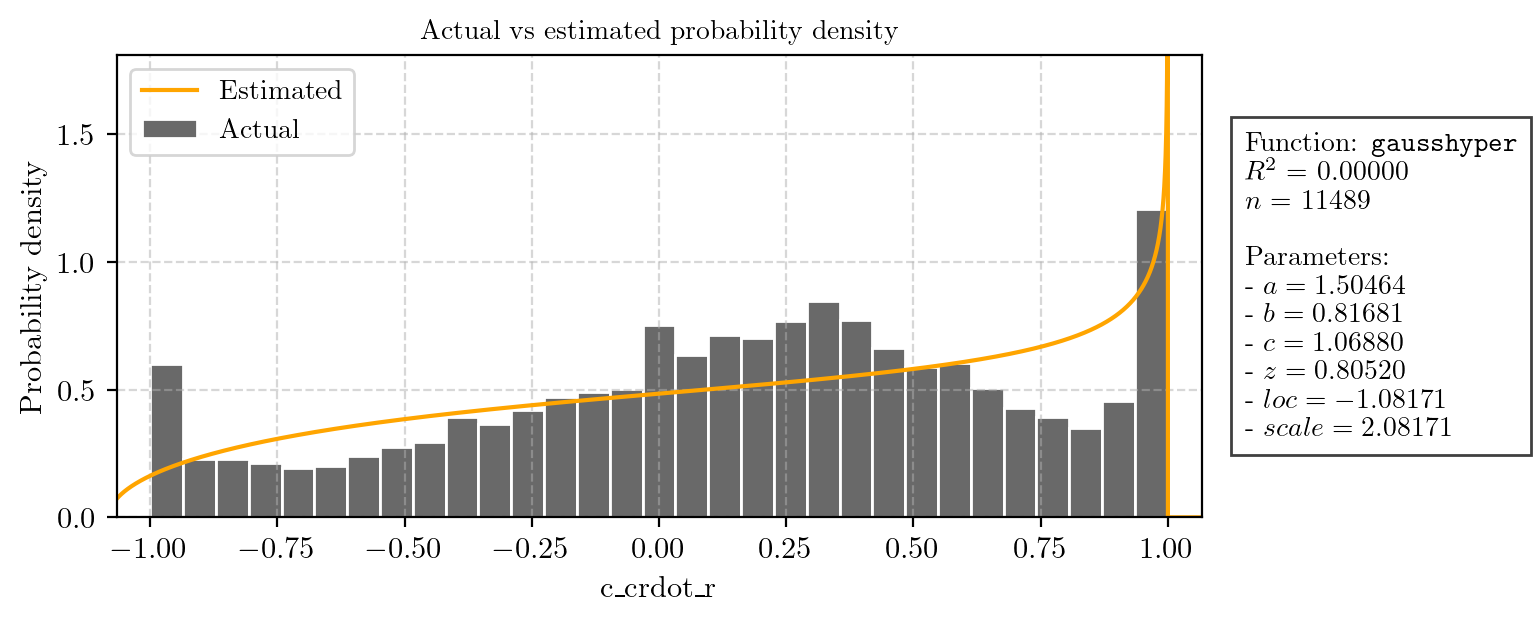

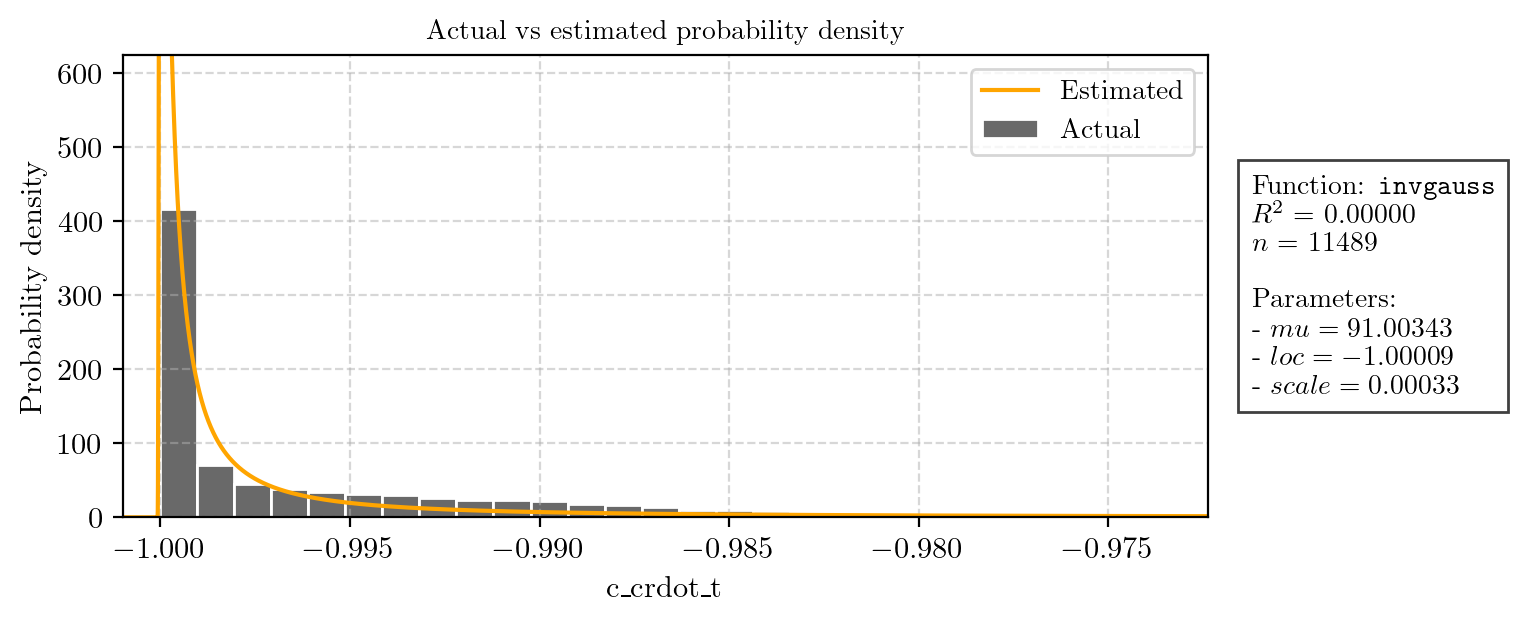

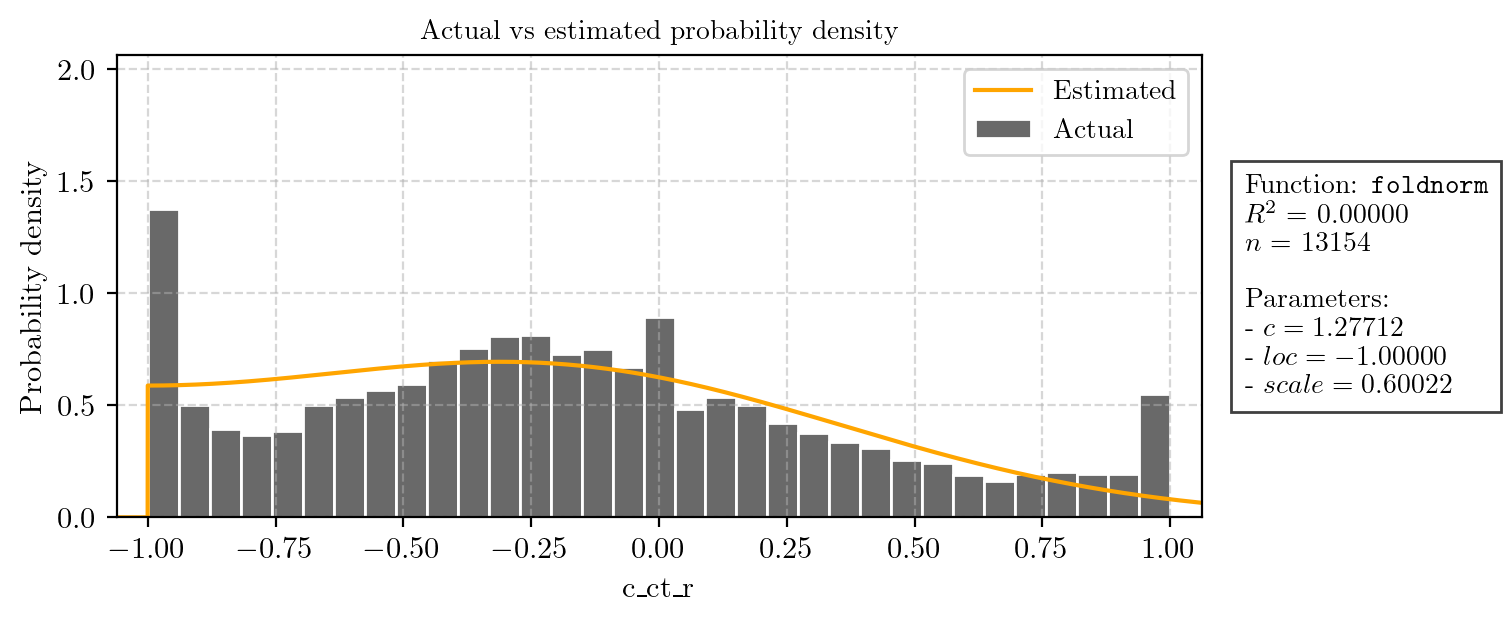

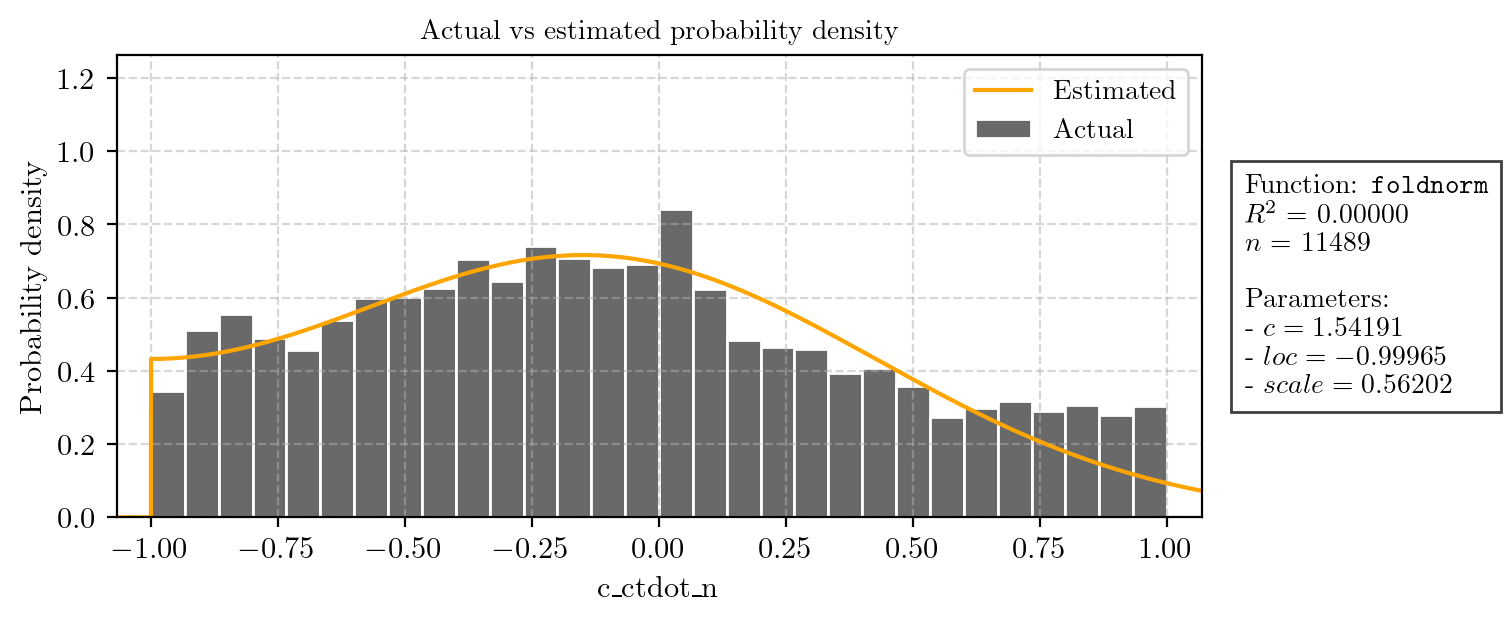

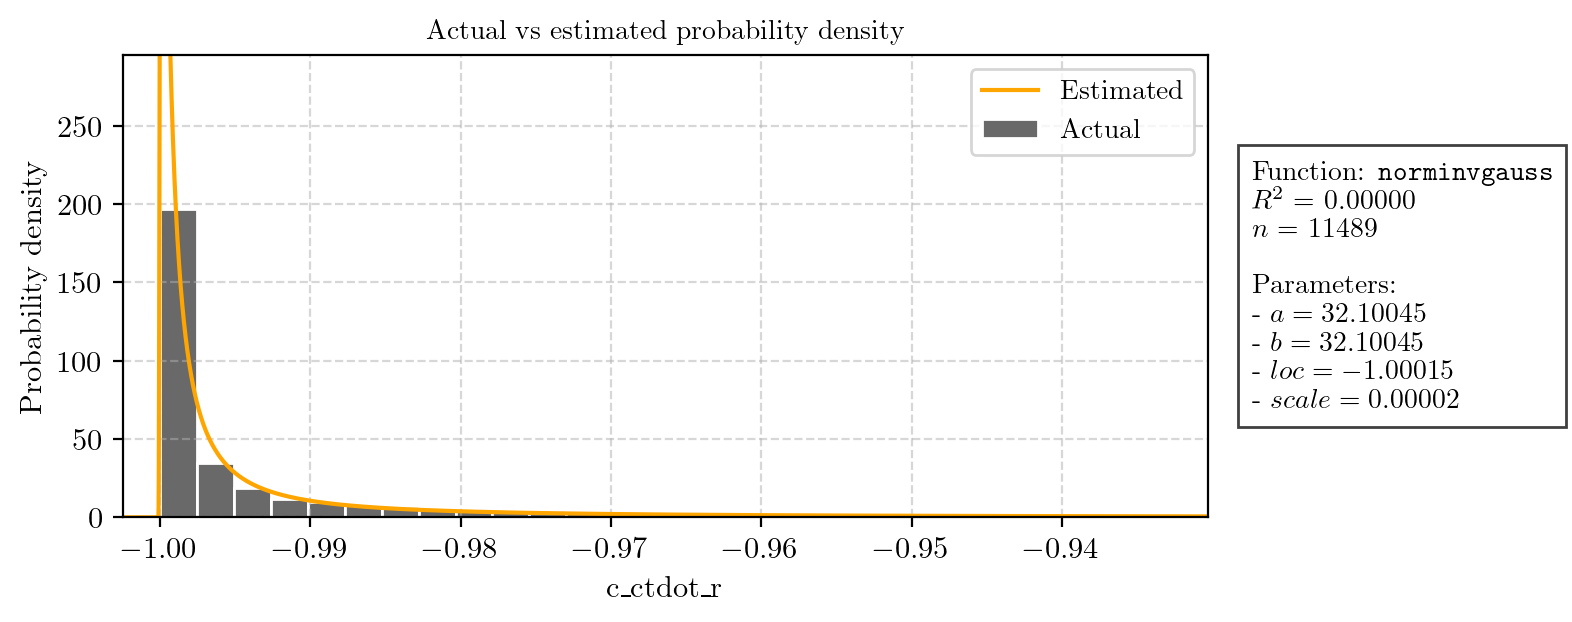

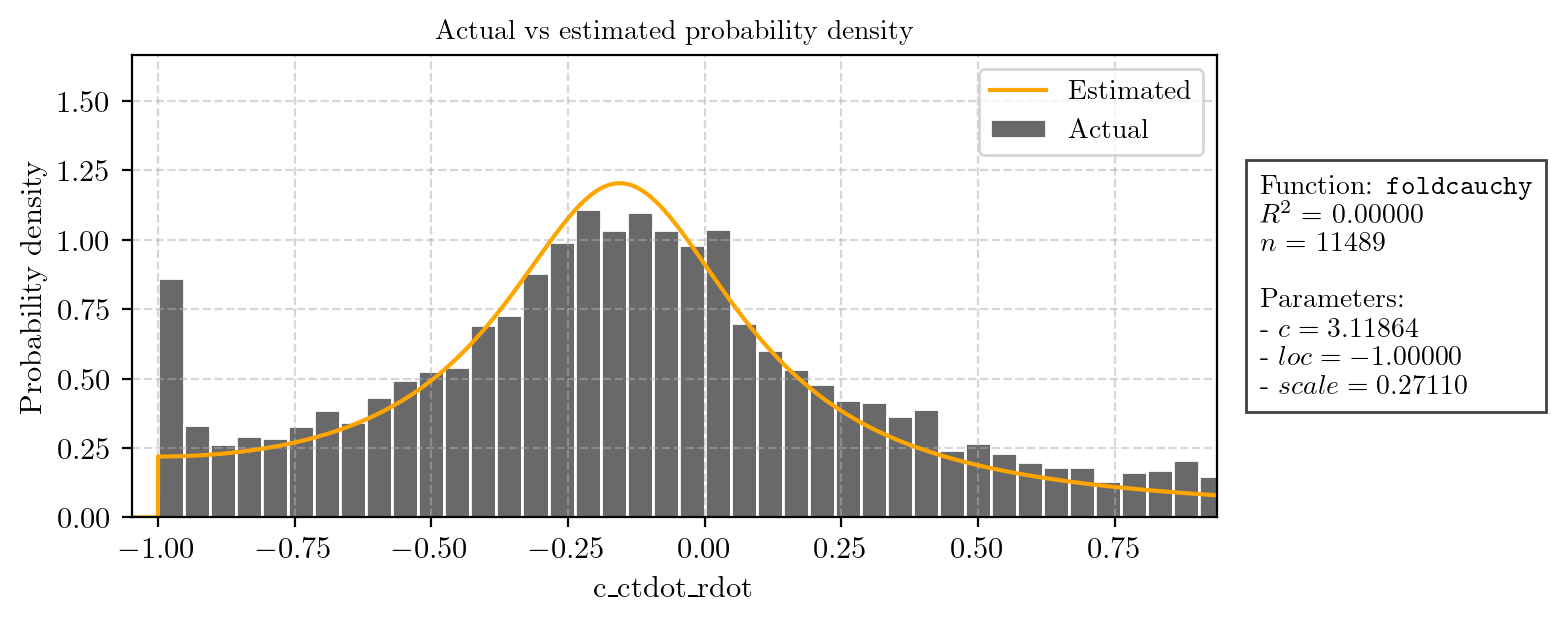

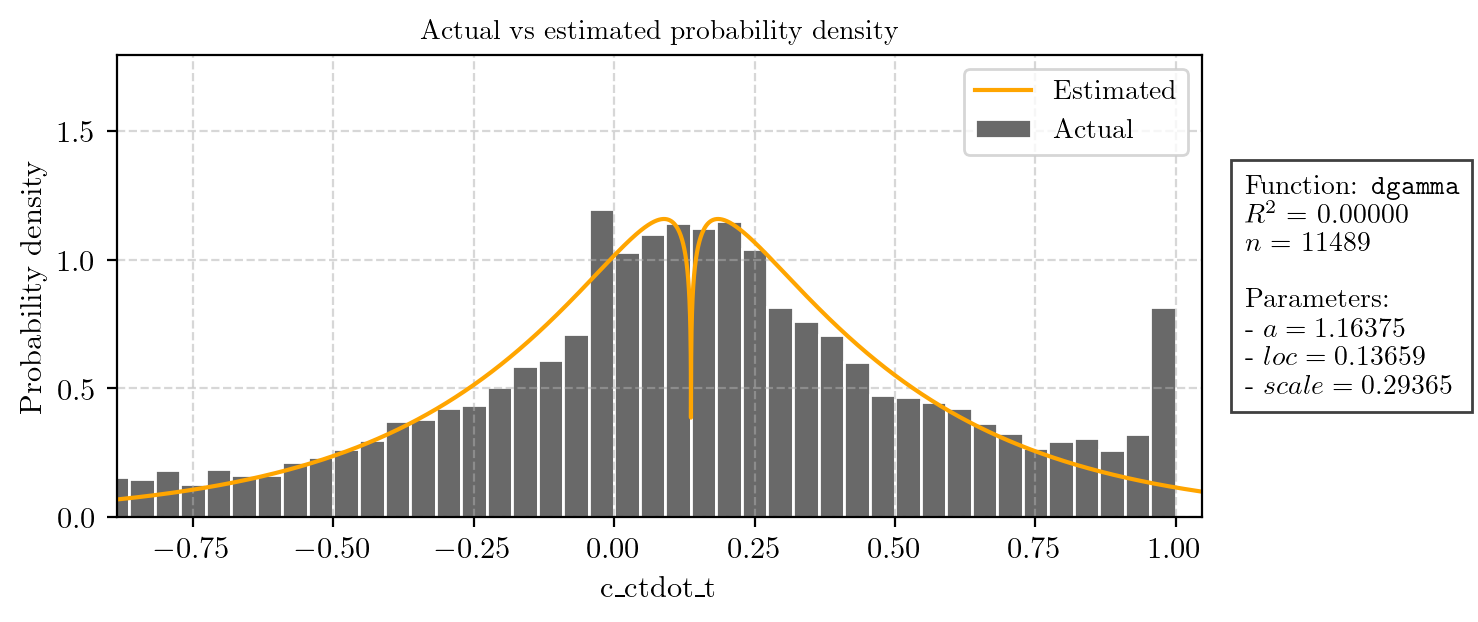

{
    "parametric": [],
    "non-parametric": [
        "time_to_tca",
        "risk",
        "max_risk_estimate",
        "max_risk_scaling",
        "miss_distance",
        "geocentric_latitude",
        "azimuth",
        "elevation",
        "mahalanobis_distance",
        "F10",
        "F3M",
        "SSN",
        "AP",
        "t_j2k_inc",
        "t_j2k_ecc",
        "t_h_per",
        "t_cd_area_over_mass",
        "t_cr_area_over_mass",
        "c_cd_area_over_mass",
        "c_cr_area_over_mass",
        "t_cn_r",
        "t_cn_t",
        "t_cndot_n",
        "t_cndot_r",
        "t_cndot_rdot",
        "t_cndot_t",
        "t_cndot_tdot",
        "t_crdot_n",
        "t_crdot_r",
        "t_crdot_t",
        "t_ct_r",
        "t_ctdot_n",
        "t_ctdot_r",
        "t_ctdot_rdot",
        "t_ctdot_t",
        "c_cn_r",
        "c_cn_t",
        "c_cndot_n",
        "c_cndot_r",
        "c_cndot_rdot",
        "c_cndot_t",
        "c_cndot_tdot",
        "c_crdot_n",
 

In [19]:
# Import ranking if available
ranking, best_dists, filepath = import_stdists_ranking()

methods = {'parametric':[],'non-parametric':[]}

for clusters in [column_clusters['conjunction'], 
                 ['t_j2k_inc', 't_j2k_ecc', 't_h_per'],
                 column_clusters['target']['coeff'],
                 column_clusters['chaser']['coeff'],
                 column_clusters['target']['cov'],
                 column_clusters['chaser']['cov']]:
            
    for feature in clusters:
        
        # Set column name to study and remove outliers. 
        data = df_lastCDM[feature]
        
        # if not feature in best_dists.keys(): continue
        if feature.find("sigma")!=-1: continue
            
        # data = np.array(data.values).flatten()
        # data = normalize([data[~np.isnan(data)]], norm='max').flatten()
            

        # Check if variable has already been processed
        if feature in ranking.columns:
            stdist = statistics.FitScipyDistribution(data, eval('st.' + best_dists[feature]['dist']))
        else:
            stdist, ranking_i = statistics.find_best_distribution(data, scipy_distributions)
            
            # Prepare ranking dataset to be exported as CSV
            ranking_i.set_index('distribution', inplace=True)
            ranking_i.rename(columns={'r2_score':feature}, inplace=True)
            ranking = ranking.join(ranking_i)

            # Export results to a CSV file
            ranking.to_csv(path_or_buf=filepath, sep=',', header=True, index=True, decimal='.')

        # If R2 is lower than 0.95 do not use parammetric approach
        if stdist.r2_score()>=0.95:
            methods['parametric'].append(feature)
        else:
            methods['non-parametric'].append(feature)

        # Print plot including histogram and distribution fitted
        plt_kwargs={'xlabel': feature, 'describe':True}
        plot_scipy_pdf(data, stdist, **plt_kwargs)

print(format_json(methods))

In [20]:
def import_synthetic_data(filename):
    
    # Check if parametric_ranking dataset is available in the temporary folder
    filepath = os.path.join(cwd,'data','synthetic',filename)

    # Import ranking dataframe if already available
    if os.path.exists(filepath):
        df_synthetic = pd.read_csv(filepath_or_buffer=filepath, sep=',', header='infer', 
                              index_col=0, decimal='.', encoding='utf-8')
    else:
        # Check if temp folder already exists, create new one otherwise
        if not os.path.exists(os.path.join(cwd,'data','synthetic')): 
            os.mkdir(os.path.join(cwd,'data','synthetic'))

        # Initialize ranking dataframe to evaluate best distributions per column
        df_synthetic = pd.DataFrame(index = range(size))
        
    return df_synthetic, filepath

In [21]:
# Import ranking if available
ranking, best_dists, filepath = import_stdists_ranking()

# Set the size of the synthetic dataset to create.
size=int(1e4)

df_synthetic, filepath = import_synthetic_data('synthetic_data_' + str(int(size/1000)) + 'k.csv')
df_synthetic.head(10)

for feature in methods['parametric']:
    
    # Set column name to study and remove outliers. 
    data = df_lastCDM[feature]
    
    # Check if variable has already been processed
    stdist = statistics.FitScipyDistribution(data, eval('st.' + best_dists[feature]['dist']))
    
    if feature in df_synthetic.columns:
        synthetic_data = df_synthetic[feature]
    else:

        # Set the Random variates keyword arguments for the synthetic data generation
        rvs_kwargs = {'size': size}

        if feature == 'elevation':
            rvs_kwargs.update({'limits':(-70, 70)})
        elif ((feature[0] in ['t', 'c']) and (feature[2:3]=='c')):
            rvs_kwargs.update({'limits':(-1, 1)}) 

        # Randomly create new synthetic data
        synthetic_data = stdist.rvs(**rvs_kwargs)
    
        df_synthetic = df_synthetic.join(pd.DataFrame(data=synthetic_data, columns=[feature]))
        
        # Export results to a CSV file
        df_synthetic.to_csv(path_or_buf=filepath, sep=',', header=True, index=True, decimal='.')
    
    
    # Compute bins and standard data limits for a better representation of the histograms
    bins = utils.nbins(data, 'fd')
    std_lims = utils.outliers_boundaries(data, threshold = 1.5, positive_only=(np.sum(data<0)==0))

    # Plot actual vs synthetic data vs PDF for comparison
    plt.figure(figsize=(7, 3))
    
    axes = plt.gca()
     
    om = '{:.2e}' if  max(utils.order_of_magnitude(data.min()), utils.order_of_magnitude(data.max()))>=5 else '{:.2f}'
    
    description = pd.DataFrame({'Actual': data}).describe()\
                  .join(pd.DataFrame({'Synthetic': synthetic_data}).describe())

    text = df_to_latex(description.applymap(om.format))

    t = axes.text(1.04, 0.5, text, size=10, ha='left', va='center', c='black', transform=axes.transAxes, 
              bbox=dict(facecolor='white', edgecolor='black', alpha=0.75, pad=5))
    
    n, bin_edges, patches = plt.hist([data, synthetic_data], bins=bins['n'], density=True, histtype='bar', 
                                     label=['Actual', 'Synthetic'], color=['dimgrey','lightskyblue'])

    pdf = stdist.pdf()
    plt.plot(pdf.index.to_numpy(), pdf.values, lw=1.5, 
             color = "orange", label=r"PDF (\texttt{" + stdist.name + "})")
    
    plt.ylabel(r'Probability density of ocurrence', fontsize=10)
    plt.xlabel(r'\texttt{' + feature + '}', fontsize=10)
    plt.xlim(max(bin_edges[0]  - bins['width'],std_lims[0]) , 
             min(bin_edges[-1] + bins['width'],std_lims[1]))

    plt.title(r'Actual vs synthetic data probability density', fontsize=10)
    plt.grid(True, linestyle='dashed', alpha=0.5)
    plt.legend(loc='best', fontsize=10)

    plt.show()



### 3.2. - Non-Parametric Probability Density Estimation using KDE

The keplerian elements that describle the orbits for both targets and chasers objects shows multimodal distributions that cannot be described by continuous stats models. As a consequence, the Non-parametric Probability Density Estimation (PDE) with KDE shall be used in order to fit a model that allows for synthetic data generation with a realistic distribution.

 - [Histograms and KDE by Michael Lerner](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28)
 - [Kernel Density Estimation in Python by Jake VanderPlas](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/)

Research paper sections:
- Abstract
- Introduction
- Literature review
- Methodology
- Results & Discussion
- Conclusion
- References